In [104]:
# Reset workspace

%reset -f

# **Start Here**

In [105]:
# Importing Python modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.signal import hilbert
from time import perf_counter, strftime, gmtime
import plotly.figure_factory as ff
from copy import deepcopy
import plotly.express as px

%matplotlib inline

begin_time = perf_counter()

# Loading files

In [106]:
# Loading the data matrix

rat_number: int = 1

data_train = pd.read_csv(f'../data/R{rat_number}_PreTreino.csv', delimiter=',', encoding="utf8")
data_test = pd.read_csv(f'../data/R{rat_number}_Teste.csv', delimiter=',', encoding="utf8")

## Train data

In [107]:
events_index_train = {
    "event_1": {
        "start": 2311160,
        "end": 2709580
    },
    "event_2": {
        "start": 3411840,
        "end": 3805760
    },
    "event_3": {
        "start": 4876650,
        "end": 5272240
    },
    "event_4": {
        "start": 6704690,
        "end": 7100290
    },
    "event_5": {
        "start": 7804430,
        "end": 8202540
    }
}

In [108]:
data_train = data_train.assign(event=np.empty(len(data_train), dtype=str))

In [109]:
data_train.loc[:, "event"] = "base"

In [110]:
for event_name, event_limits_dict in events_index_train.items():
    data_train.loc[event_limits_dict["start"]:event_limits_dict["end"], "event"] = event_name

In [111]:
data_train.event.unique()

array(['base', 'event_1', 'event_2', 'event_3', 'event_4', 'event_5'],
      dtype=object)

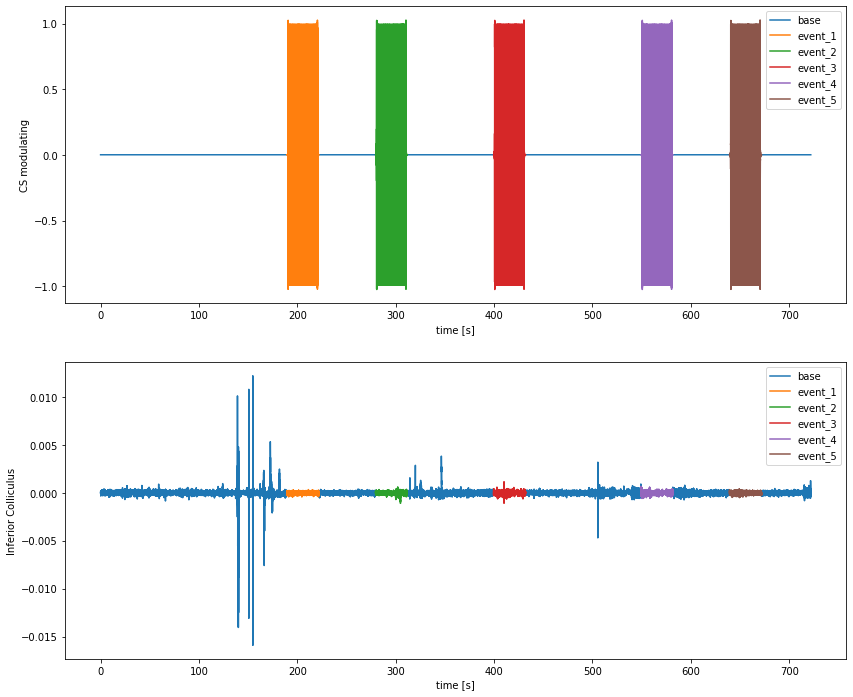

In [112]:
plt.figure(figsize=(14,12))

plt.subplot(211)
for event in data_train.event.unique():
    plt.plot(data_train.loc[data_train.event==event, "Time"], data_train.loc[data_train.event==event, "CS_modulating"], label=event)
plt.legend()
plt.xlabel("time [s]")
plt.ylabel("CS modulating")

plt.subplot(212)
for event in data_train.event.unique():
    plt.plot(data_train.loc[data_train.event==event, "Time"], data_train.loc[data_train.event==event, "Inferior_colliculus"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Inferior Colliculus")
plt.legend()

plt.show()

## Test data

In [113]:
events_index_test = {
    "event_1": {
        "start": 2315510,
        "end": 2708740
    },
    "event_2": {
        "start": 3409860,
        "end": 3808130
    },
    "event_3": {
        "start": 4880260,
        "end": 5270800
    },
    "event_4": {
        "start": 6708560,
        "end": 7103890
    },
    "event_5": {
        "start": 7808000,
        "end": 8208900
    }
}

In [114]:
data_test = data_test.assign(event=np.empty(len(data_test), dtype=str))

In [115]:
data_test.loc[:, "event"] = "base"

In [116]:
for event_name, event_limits_dict in events_index_test.items():
    data_test.loc[event_limits_dict["start"]:event_limits_dict["end"], "event"] = event_name

In [117]:
data_test.event.unique()

array(['base', 'event_1', 'event_2', 'event_3', 'event_4', 'event_5'],
      dtype=object)

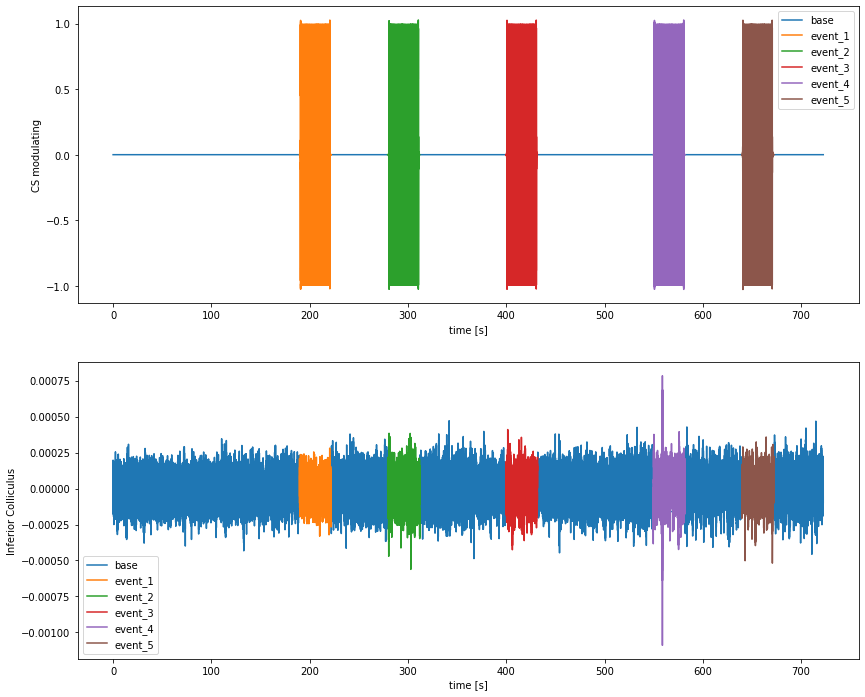

In [118]:
plt.figure(figsize=(14,12))

plt.subplot(211)
for event in data_train.event.unique():
    plt.plot(data_test.loc[data_test.event==event, "Time"], data_test.loc[data_test.event==event, "CS_modulating"], label=event)
plt.legend()
plt.xlabel("time [s]")
plt.ylabel("CS modulating")

plt.subplot(212)
for event in data_test.event.unique():
    plt.plot(data_test.loc[data_test.event==event, "Time"], data_test.loc[data_test.event==event, "Inferior_colliculus"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Inferior Colliculus")
plt.legend()

plt.show()

# Methods

In [119]:
# Method to extract events from dataframe

def select_event_window(
    df: pd.DataFrame, 
    event_name: str, 
    samples_before: int = 0, 
    samples_after: int = 0
) -> pd.DataFrame:
    """
    Method to extract the slice of the dataframe which contais the event, with some data before and after, 
    given number of samples to add to the begin and end, respectively.
    """

    window_index = np.argwhere(df.event.to_numpy() == event_name).flatten()
    begin_index = window_index[0] - samples_before
    end_index = window_index[-1] + samples_after
    return df[begin_index:end_index]

In [120]:
class PolarPlotPhasors:
    @classmethod
    def create_polar_plot(cls, figsize=(14,10), grid=True):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='polar')
        ax.set_yticklabels([])
        plt.grid(grid)
        plt.xticks(
            [
                0, 
                0.25*np.pi, 
                0.5*np.pi,
                0.75*np.pi, 
                np.pi, 
                1.25*np.pi, 
                1.5*np.pi, 
                1.75*np.pi
            ], 
            [
                "0", 
                "$\\frac{\pi}{4}$",
                "$\\frac{\pi}{2}$",
                "$\\frac{3 \pi}{4}$",
                "$\pi$",
                "$\\frac{5\pi}{4}$",
                "$\\frac{3\pi}{2}$",
                "$\\frac{7\pi}{4}$"
            ],
            fontsize=20
        )
        ax.set_theta_zero_location('E')
        return ax
    
    @classmethod
    def add_angle_polar(cls, ax, angle, color, linewidth):
        ax.plot([0, angle], [0, 1], color=color, linewidth=linewidth)
        return ax
    
    @classmethod
    def plot_array_angles_colored(cls, angles, color="gray", linewidth=1, grid=False):
        ax = cls.create_polar_plot(grid=grid)
        for angle in angles:
            ax = cls.add_angle_polar(ax, angle, color, linewidth)
        return ax
    
    @classmethod
    def add_vector_polar(cls, ax, angle, module, color, linewidth):
        ax.plot([0, angle], [0, module], color=color, linewidth=linewidth)
        return ax
    
    @classmethod
    def plot_array_angles(cls, angles, color="gray", linewidth=1, grid=False):

        ax = cls.create_polar_plot(grid=grid)

        new_angles = np.zeros((4,len(angles)))
        modules = np.zeros((4,len(angles)))

        new_angles[1, :] = new_angles[2, :] = angles
        new_angles = new_angles.T.reshape(-1)

        modules[1:3, :] = 1
        modules = modules.T.reshape(-1)

        ax.plot(new_angles, modules, color=color, linewidth=linewidth)

        return ax
    
    @classmethod
    def plot_two_array_angles(cls, angles1, angles2, color1="gray", color2="blue", linewidth=1, grid=False):
        ax = cls.create_polar_plot(grid=grid)

        new_angles = np.zeros((4,len(angles)))
        modules = np.zeros((4,len(angles)))

        new_angles[1, :] = new_angles[2, :] = angles
        new_angles = new_angles.T.reshape(-1)

        modules[1:3, :] = 1
        modules = modules.T.reshape(-1)

        ax.plot(new_angles, modules, color=color, linewidth=linewidth)

        return ax

In [121]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return signal.butter(order, [lowcut, highcut], fs=fs, btype='band')

In [122]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, filtfilt=False):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    if filtfilt:
        return signal.filtfilt(b, a, data)
    return signal.lfilter(b, a, data)

In [123]:
def sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
):


    # Mean synchronization using sliding window with 90% time overlap
    step = int(0.1*(sliding_window_size/TimeSampling))
    ic_number = 1
    number_of_windows_overlap = int((window_size/TimeSampling)//step)
    start_window = np.arange(0, len(ic_data_complete), step).astype(int)
    end_window = (start_window + int(sliding_window_size/TimeSampling)).astype(int)
    end_window[-1] = len(ic_data_complete) - 1

    clustering_phase_array = np.empty(shape=(number_of_windows_overlap,), dtype=np.float64)
    mean_phase_array = np.empty(shape=(number_of_windows_overlap,), dtype=np.float64)


    for i in range(number_of_windows_overlap):
        event_time_window = event_time[start_window[i]:end_window[i]]
        ic_data = ic_data_complete[start_window[i]:end_window[i]]
        phase_data_CS_event = phase_data_CS[start_window[i]:end_window[i]]
        analytic_signal_ic = hilbert(ic_data)
        phase_data_ic = np.unwrap(np.angle(analytic_signal_ic))
        phase_angle_diff = phase_data_CS_event - phase_data_ic
        euler_phase_diff = np.exp(1j*phase_angle_diff)
        mean_phase_diff = np.mean(euler_phase_diff)
        phase_sync = np.abs(mean_phase_diff)
        clustering_phase_array[i] = phase_sync
        mean_phase_array[i] = np.angle(mean_phase_diff)

    mean_phase_sync = clustering_phase_array.mean()
    mean_phase_angle = np.angle(np.mean(np.exp(1j*mean_phase_array)))
    ax = PolarPlotPhasors.plot_array_angles(mean_phase_array, color=None, linewidth=0.5)
    ax = PolarPlotPhasors.add_vector_polar(ax, angle=mean_phase_angle, module=mean_phase_sync, linewidth=10, color='red')
    ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
    plt.show()

## Spectogram

In [141]:
def run_and_plot(event_data: pd.DataFrame, fs: float) -> None:

    """
    Method to plot the waveform and spectogram of the CS modullating signal paired with each channel at time.
    """

    for index_of_channel in range(1,event_data.shape[1]-1):
        
        t0 = event_data.Time.iloc[0]

        name_of_channel = list(event_data.columns)[index_of_channel]

        print(f"Channel {index_of_channel - 1}: {name_of_channel.replace('_', ' ')}")

        f, t, Sxx = signal.spectrogram(event_data[name_of_channel], fs, nfft=2048)
        plt.figure(figsize=(12,10))
        plt.title(name_of_channel.replace("_", " "))
        plt.pcolormesh(t0+t, f, Sxx, cmap='hot')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.ylim([0, 500])
        plt.yticks([53.71])
        plt.show()

        print("-"*114)
        print("-"*114)
        print("\n\n")

Train Data - Event 1
Channel 0: CS modulating


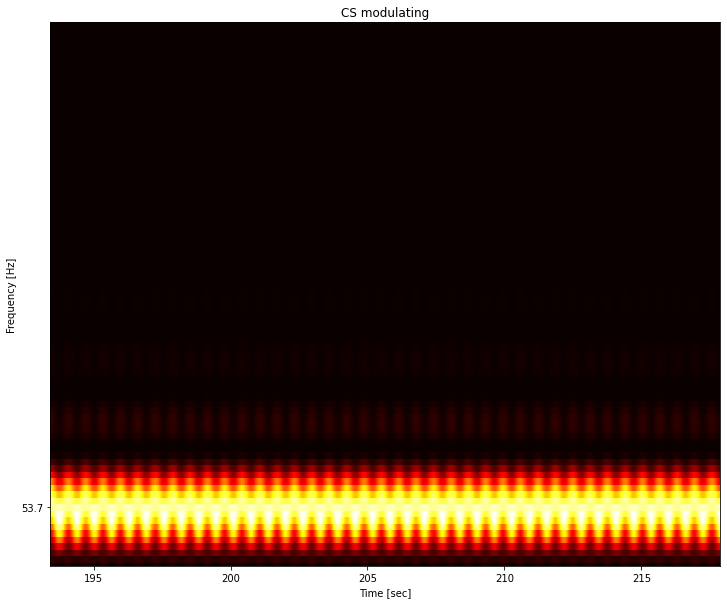

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 1: Inferior colliculus


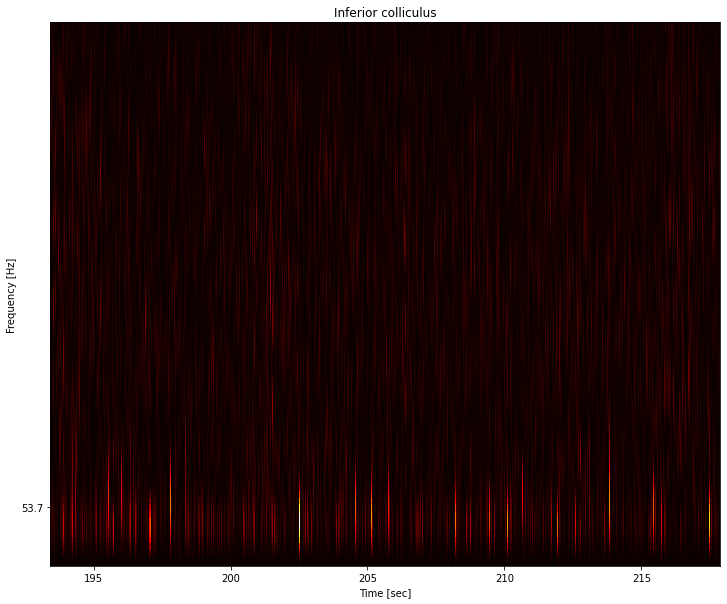

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Test Data - Event 1
Channel 0: CS modulating


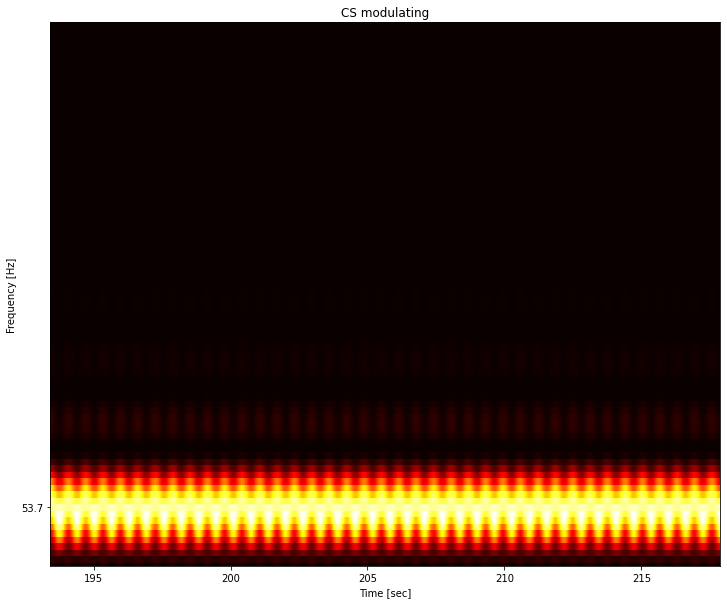

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 1: Inferior colliculus


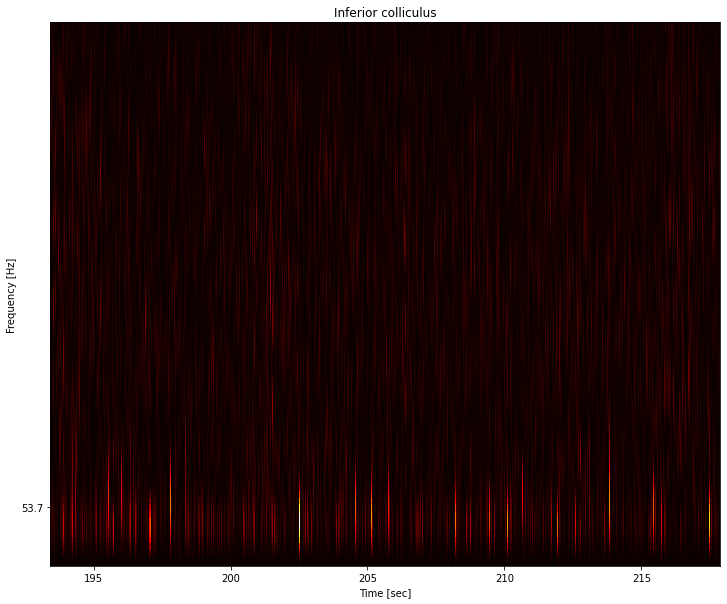

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Train Data - Event 2
Channel 0: CS modulating


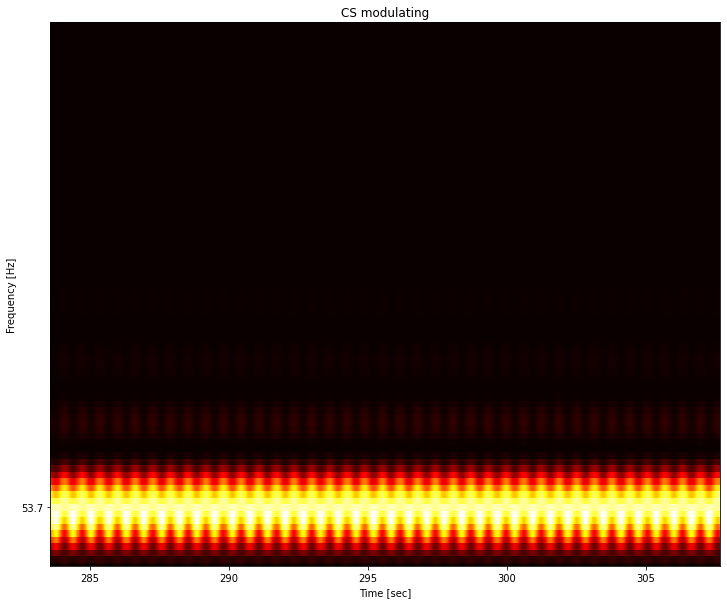

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 1: Inferior colliculus


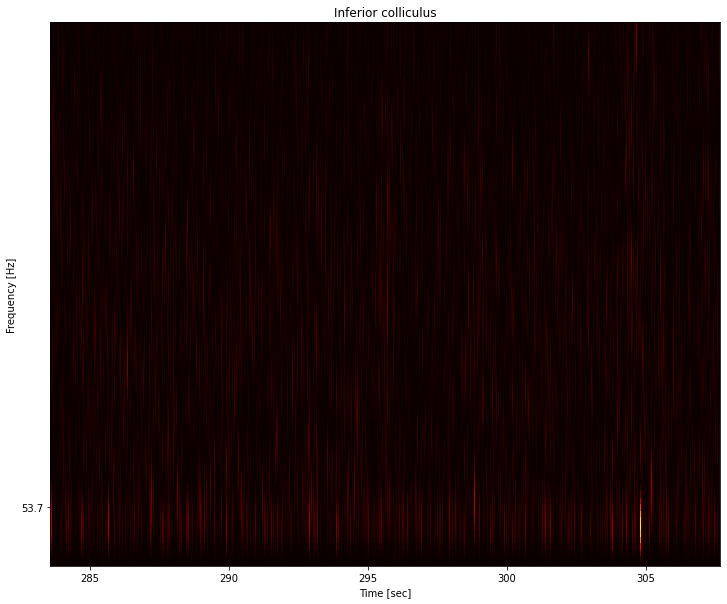

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Test Data - Event 2
Channel 0: CS modulating


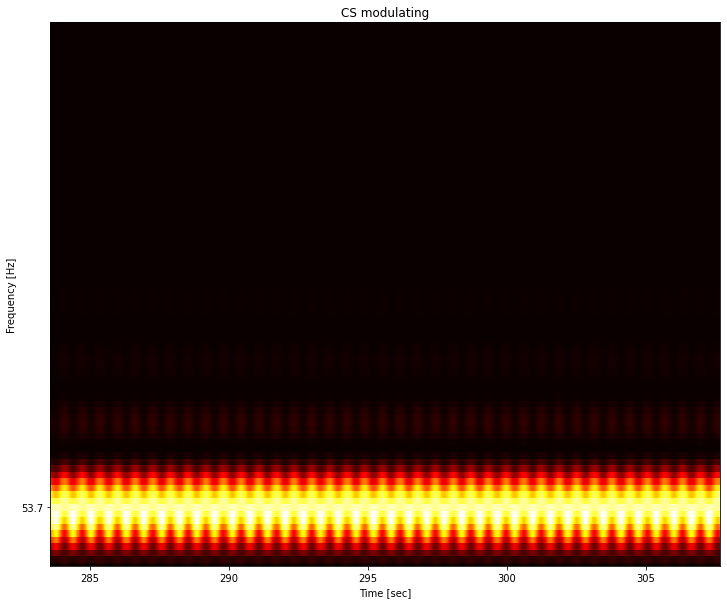

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 1: Inferior colliculus


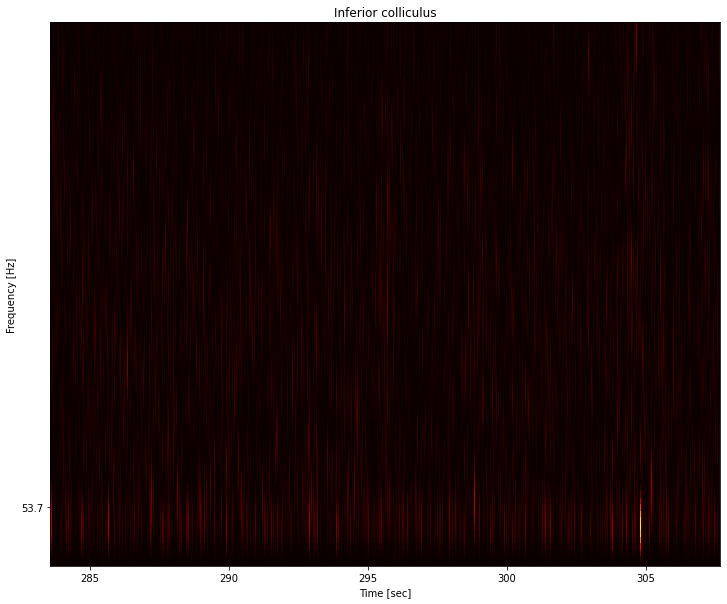

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Train Data - Event 3
Channel 0: CS modulating


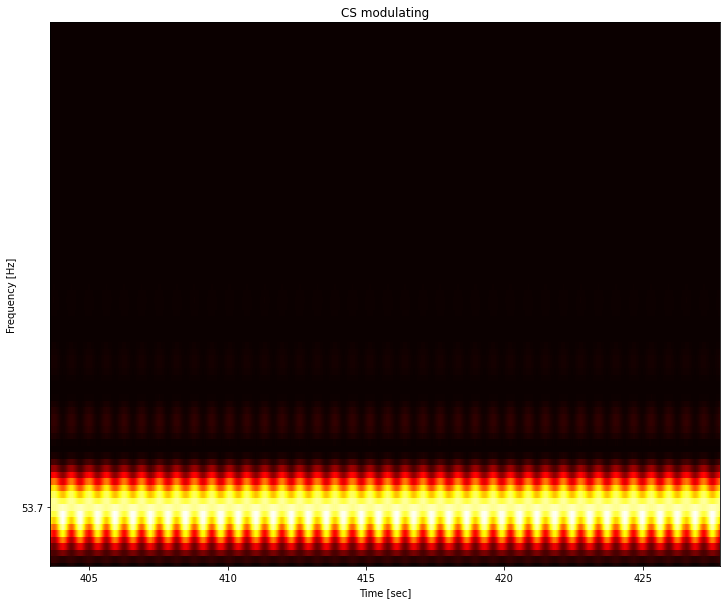

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 1: Inferior colliculus


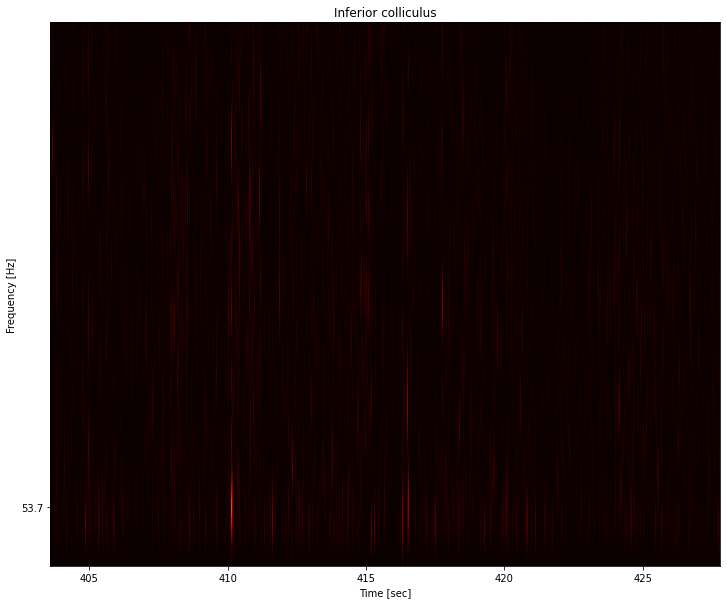

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Test Data - Event 3
Channel 0: CS modulating


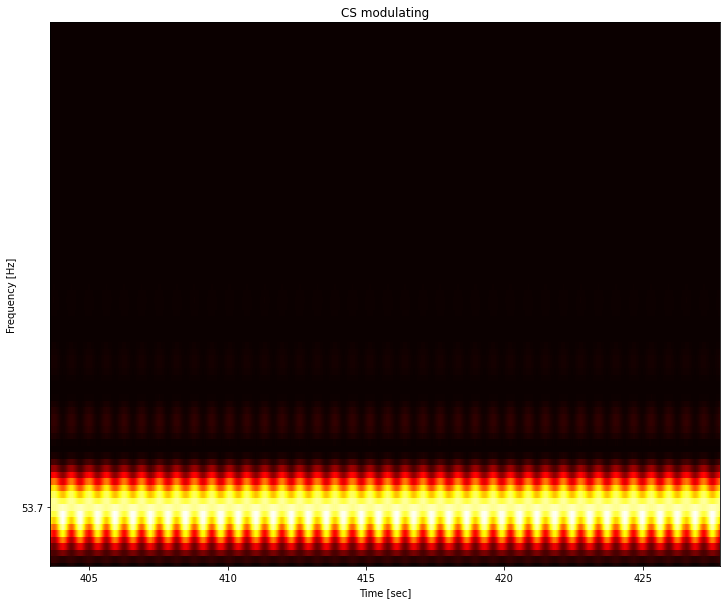

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 1: Inferior colliculus


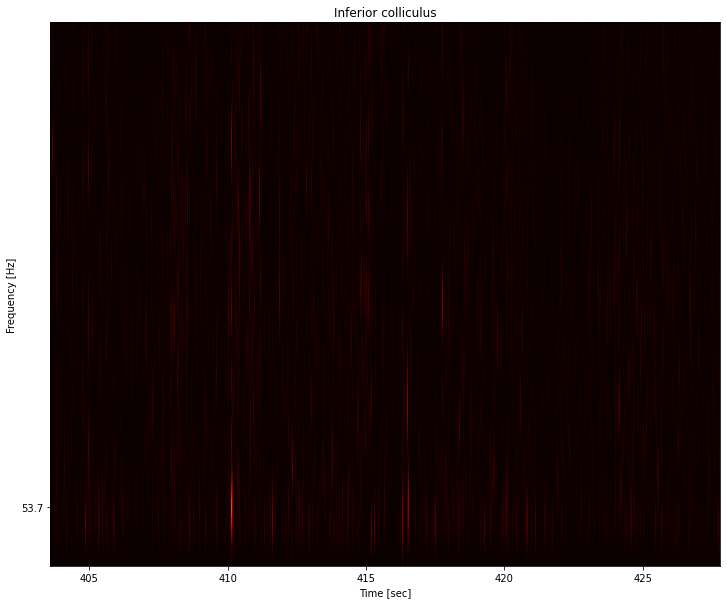

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Train Data - Event 4
Channel 0: CS modulating


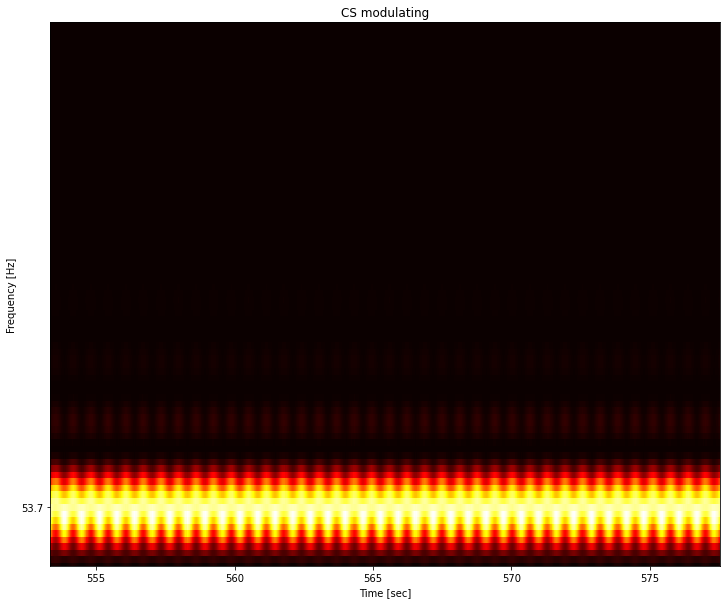

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 1: Inferior colliculus


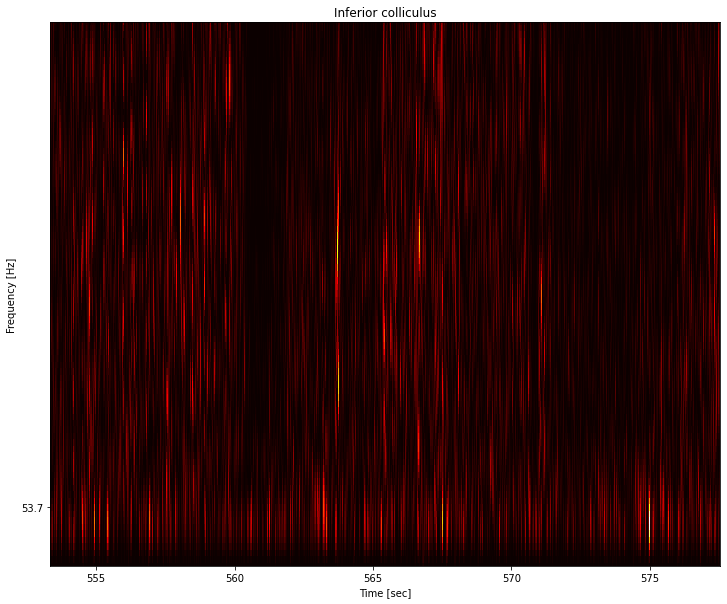

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Test Data - Event 4
Channel 0: CS modulating


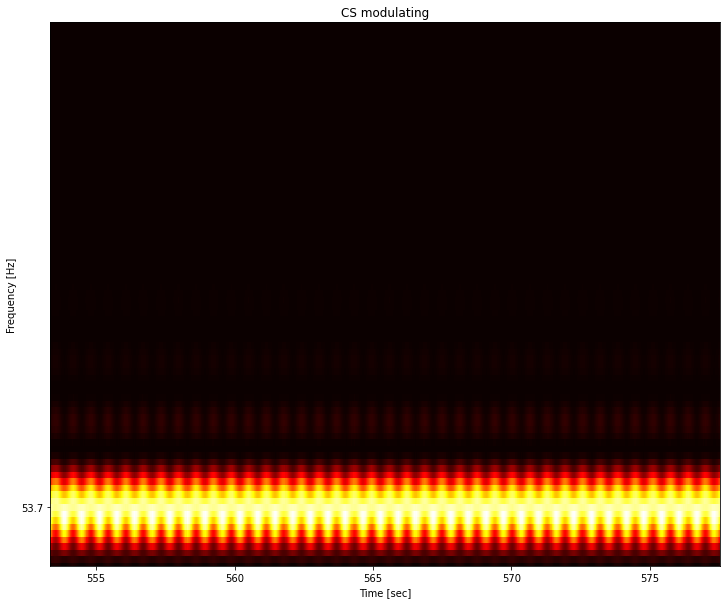

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 1: Inferior colliculus


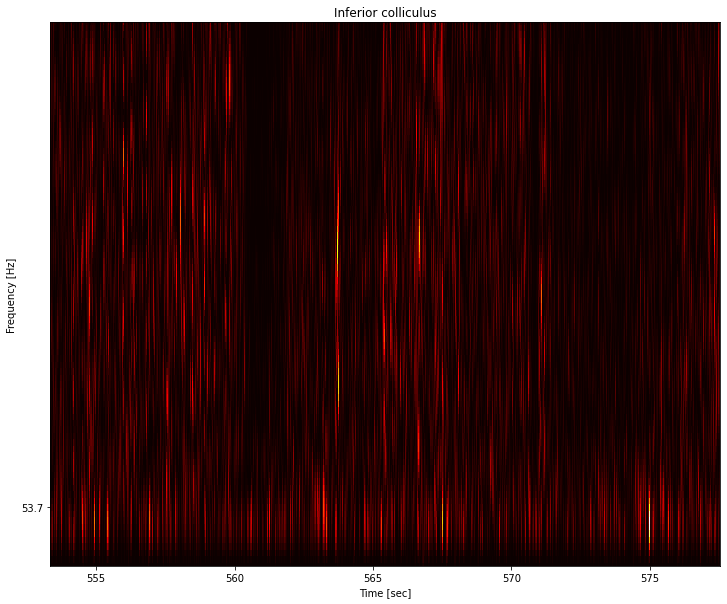

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Train Data - Event 5
Channel 0: CS modulating


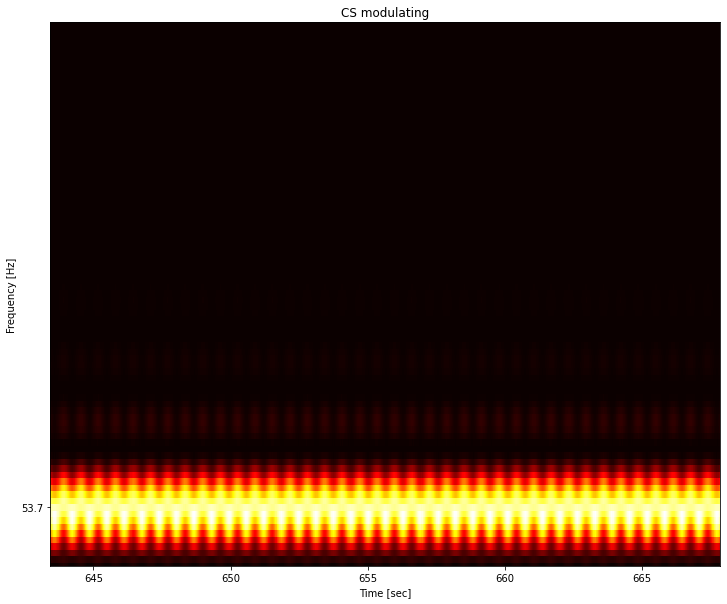

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 1: Inferior colliculus


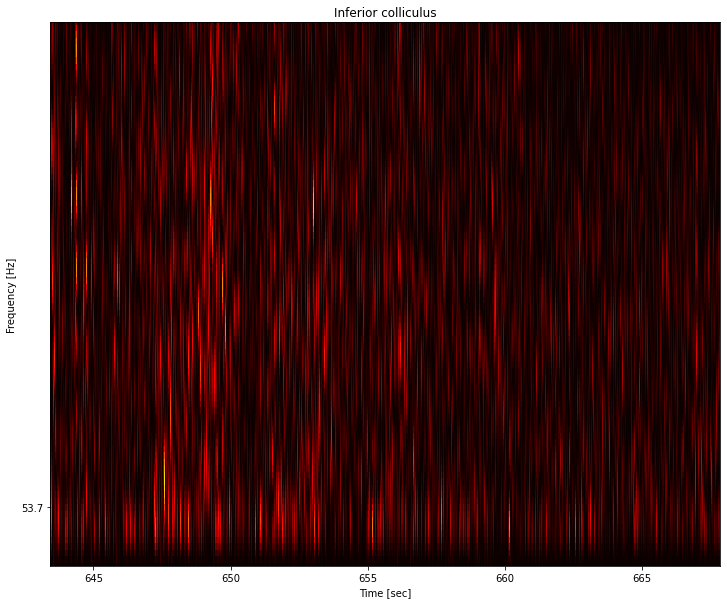

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Test Data - Event 5
Channel 0: CS modulating


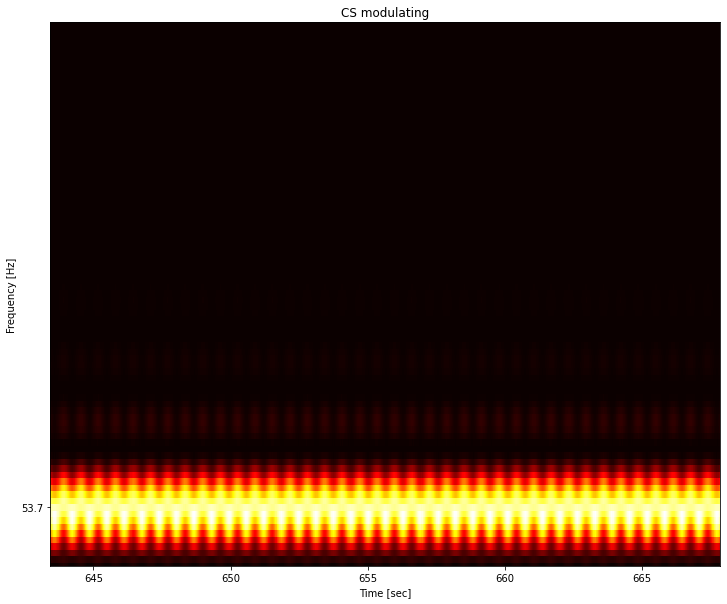

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 1: Inferior colliculus


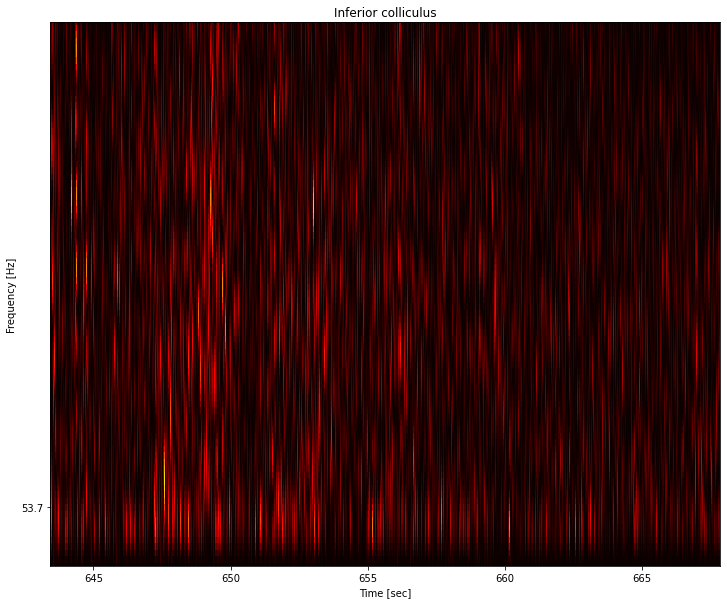

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------





In [148]:
for event_number in range(1, 6):

    print(f"Train Data - Event {event_number}")
    event_1_train_data = select_event_window(
        df=data_train, 
        event_name=f"event_{event_number}", 
        samples_before=-50000, 
        samples_after=-50000
    )

    time_event = event_1_train_data.Time.to_numpy()
    fs_event = 1.0/np.mean(time_event[1:] - time_event[0:-1])
    run_and_plot(event_1_train_data, fs=fs_event)

    print(f"Test Data - Event {event_number}")
    event_1_test_data = select_event_window(
        df=data_test, 
        event_name=f"event_{event_number}", 
        samples_before=-50000, 
        samples_after=-50000
    )

    time_event = event_1_train_data.Time.to_numpy()
    fs_event = 1.0/np.mean(time_event[1:] - time_event[0:-1])
    run_and_plot(event_1_train_data, fs=fs_event)

# Mathematical Basis

## Data Selection

The selection of the channels to perform the comparison between the probes in the inferior colliculus and amygdala (one amongst the four probes in each brain region) are made by the biggest amplitude.

## Phase of time series $x$

$$
\phi_x = \text{atan2}\left(\text{hilbert}(x)\right)
$$

Code: 

$\phi_x$ = np.unwrap(np.angle(hillbert(x)))


## Phase coherece (synchronization ratio)

$$
\overline{Z} = \dfrac{1}{N} \sum_{i=1}^{N} e^{j \cdot (\phi_x - \phi_y)}
$$

$$
\text{coherence}_{xy} =  \left| \overline{Z} \right|
$$

$$
\overline{\theta}_{xy} = \LARGE\measuredangle \normalsize \overline{Z}
$$

Code: 

$\overline{Z}$ = np.mean(np.exp(1j*($\phi_x$ - $\phi_y$)))

coherence = np.abs($\overline{Z}$)

$\overline{\theta}_{xy}$ = np.angle($\overline{Z}$)

# Decimating the data

In [265]:
decimation = True

In [269]:
data = backup_data

data

Time  CS_modulating  Amygdala_lateral_1  Amygdala_lateral_2  \
0         0.000            0.0           -6.460995           -6.543798   
1         0.001            0.0           -3.202456           -3.763833   
2         0.002            0.0            0.429514           -0.546489   
3         0.003            0.0            4.021344            2.742117   
4         0.004            0.0            7.162864            5.726545   
...         ...            ...                 ...                 ...   
990306  990.306            0.0            0.000960            0.001578   
990307  990.307            0.0           -0.001148           -0.000504   
990308  990.308            0.0           -0.002689           -0.002103   
990309  990.309            0.0           -0.003580           -0.003109   
990310  990.310            0.0           -0.003841           -0.003516   

        Amygdala_basolateral_1  Amygdala_basolateral_2  Inferior_colliculus_1  \
0                    -6.180304               -6.633740              -0.099498   
1                    -3.631591               -3.751247               4.166571   
2                    -0.667420               -0.426602               7.987135   
3                     2.375695                2.962568              10.929170   
4                     5.151744                6.029333              12.656386   
...                        ...                     ...                    ...   
990306                0.000335                0.001097              -0.000228   
990307               -0.001245               -0.000384               0.002065   
990308               -0.002353               -0.001519               0.003635   
990309               -0.002943               -0.002231               0.004431   
990310               -0.003048               -0.002515               0.004513   

        Inferior_colliculus_2  Inferior_colliculus_3  Inferior_colliculus_4  \
0                   -1.266950              -0.330344              -3.847179   
1                    5.065584               8.309619               0.915579   
2                   10.836838              15.996568               5.608383   
3                   15.395963              21.866313               9.709023   
4                   18.227957              25.261566              12.757782   
...                       ...                    ...                    ...   
990306              -0.001079              -0.004800              -0.002419   
990307               0.000637              -0.003528              -0.001085   
990308               0.001921              -0.002096               0.000102   
990309               0.002698              -0.000724               0.001021   
990310               0.002972               0.000422               0.001608   

       events_index events_behavior_TS_LFP  
0              None                   None  
1              None                   None  
2              None                   None  
3              None                   None  
4              None                   None  
...             ...                    ...  
990306         None                   None  
990307         None                   None  
990308         None                   None  
990309         None                   None  
990310         None                   None  

[990311 rows x 12 columns]

In [270]:
time = backup_data.Time.to_numpy()
TimeSampling = np.mean(time[1:] - time[:-1])
FrequencySampling = 1.0/TimeSampling
print(f"The time sampling is {TimeSampling} seconds and the frequency is "
      f"{FrequencySampling/float(1000**(FrequencySampling<=1000))} {'k'*bool(FrequencySampling>=1000)}Hz")

The time sampling is 0.001 seconds and the frequency is 1.0 kHz


In [271]:
if decimation:
    desired_frequency_sampling = 250 # Hz
    newTimeSampling = 1.0/desired_frequency_sampling
    decimation_rate = int(newTimeSampling/TimeSampling)
    print(f"The data will be decimated by the rate 1:{decimation_rate}")

    data = data[::decimation_rate]

    TimeSampling = newTimeSampling
    
    FrequencySampling = 1.0/TimeSampling
    print(f"The new time sampling is {np.round(TimeSampling, 5)} s and the new frequency is "
    f"{FrequencySampling/float(1000**(FrequencySampling>=1000))} {'k'*bool(FrequencySampling>=1000)}Hz")
    
    data

The data will be decimated by the rate 1:4
The new time sampling is 0.004 s and the new frequency is 250.0 Hz


# Data filtering

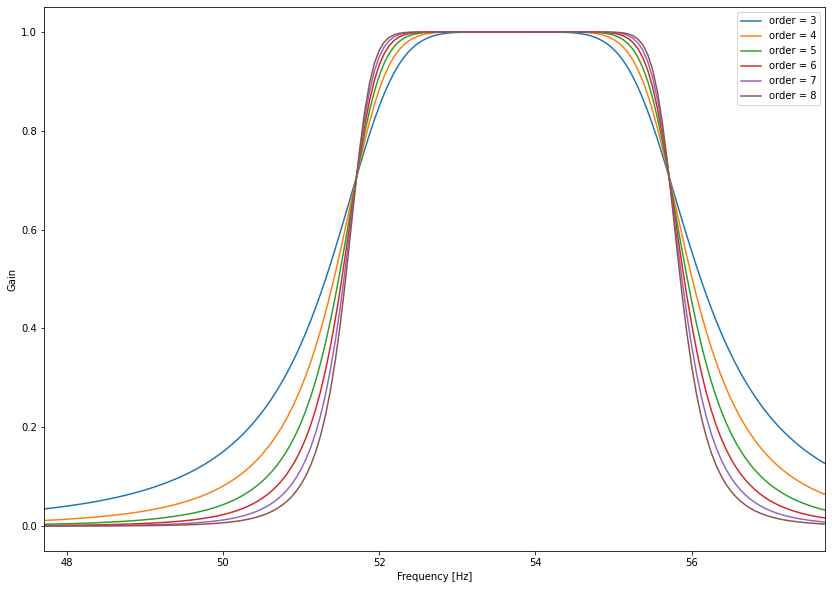

In [272]:
low_cut_hz = 53.71 - 2.0
high_cut_hz = 53.71 + 2.0
fs = 1.0/TimeSampling

plt.figure(figsize=(14,10))
plt.clf()
for order in range(3,9):
    b, a = butter_bandpass(low_cut_hz, high_cut_hz, fs, order=order)
    w, h = signal.freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)


plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.legend()
plt.xlim([low_cut_hz-4, high_cut_hz+2])
plt.show()

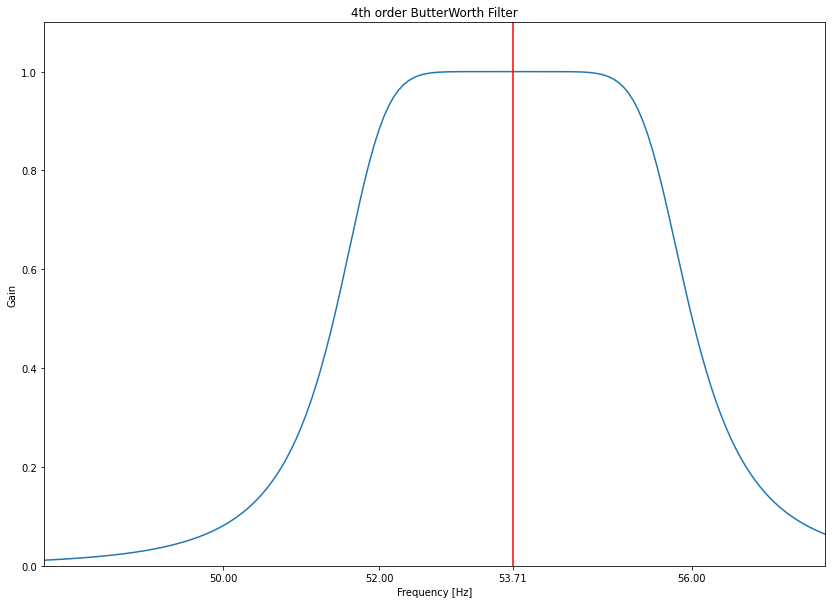

In [273]:
filter_order = 4
b, a = butter_bandpass(low_cut_hz, high_cut_hz, fs=fs, order=filter_order)

plt.figure(figsize=(14,10))
plt.clf()
w, h = signal.freqz(b, a, fs=fs, worN=2000)
plt.plot(w, abs(h))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.vlines(53.71, -1, 2, color='red')
plt.ylim([0, 1.1])
plt.xticks([50, 52, 53.71, 56])
plt.xlim([low_cut_hz-4, high_cut_hz+2])
plt.title(f"{filter_order}th order ButterWorth Filter")
plt.show()

## Filtering using filtfilt to avoid phase changes

In [274]:
filter_function = lambda column: butter_bandpass_filter(
    data=column, 
    lowcut=low_cut_hz, 
    highcut=high_cut_hz,
    fs=fs,
    order=filter_order, 
    filtfilt=True
)


filtered_data = data.iloc[:, 2:10].apply(filter_function)
data.iloc[:, 2:10] = filtered_data

# Data Visualization

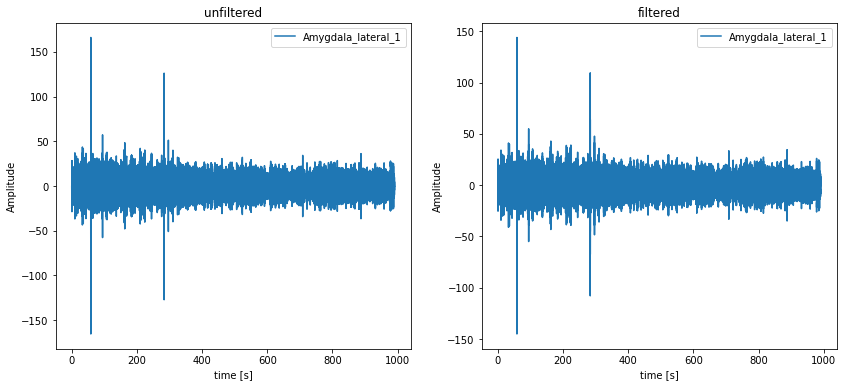

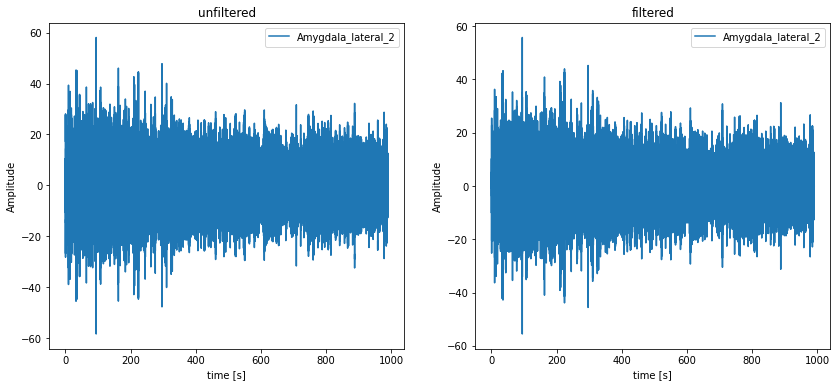

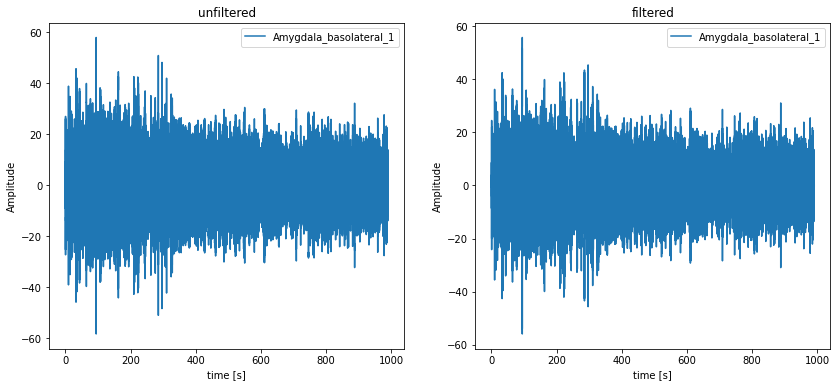

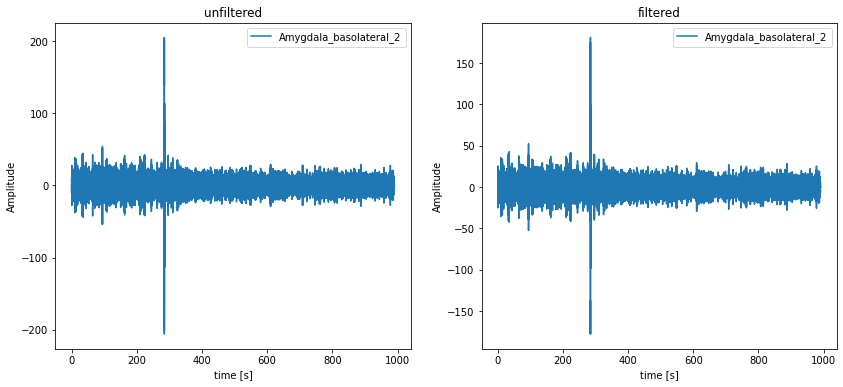

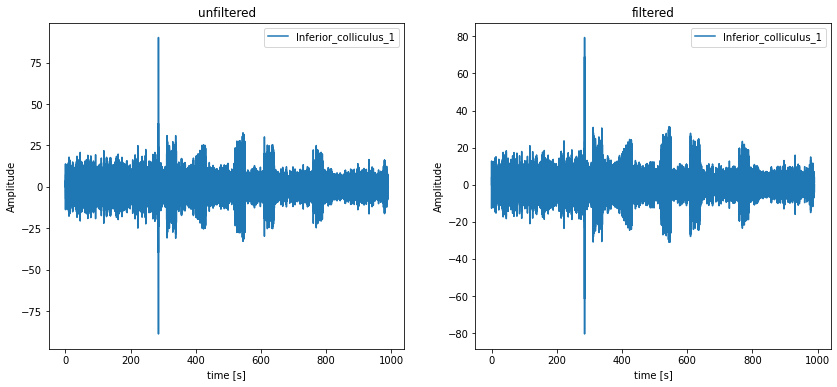

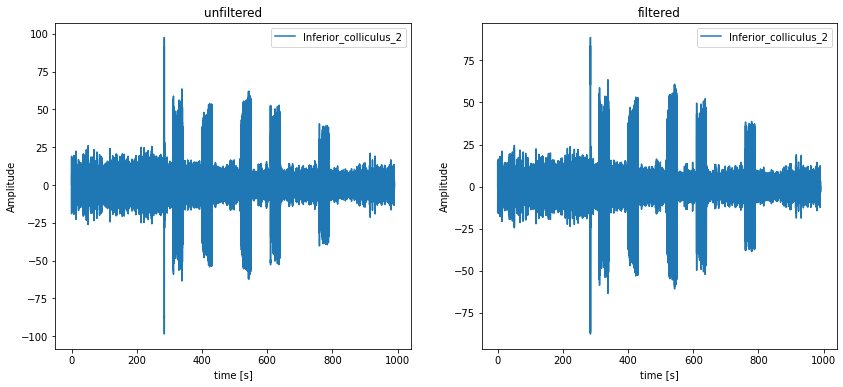

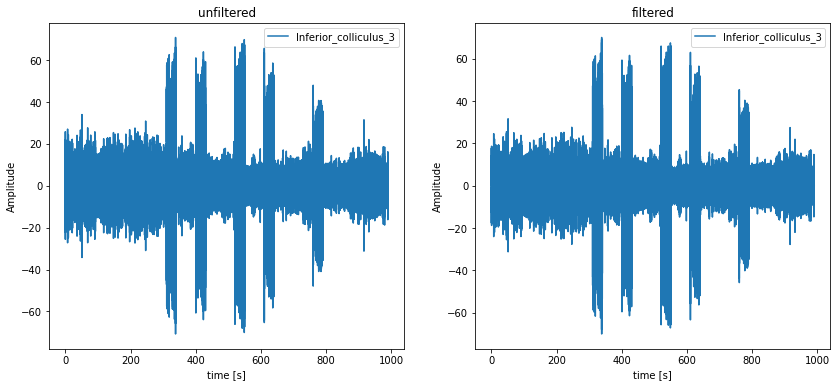

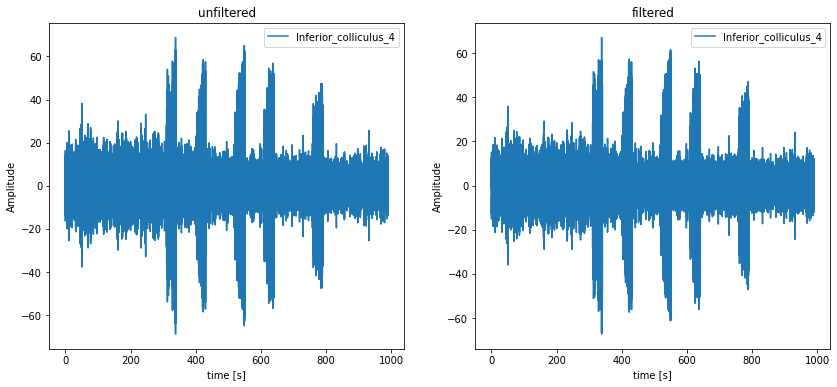

In [275]:
for i in range(2,10):
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.plot(backup_data.Time, backup_data.iloc[:,i], label=columns[i])
    plt.title("unfiltered")
    plt.legend()
    plt.xlabel("time [s]")
    plt.ylabel("Amplitude")
    
    plt.subplot(122)
    plt.plot(data.Time, data.iloc[:,i], label=columns[i])
    plt.title("filtered")
    plt.legend()
    plt.xlabel("time [s]")
    plt.ylabel("Amplitude")
    plt.show()

# Events Processing

In [276]:
# Método que calcula a FFT unilateral e retorna um plot,
# o vetor de frequências em Hertz e os ganhos
def fft(x, fs):
    N = len(x)
    FFT = np.fft.fft(x)
    P2 = np.abs(FFT/N)
    intensity = P2[0:N//2]
    intensity[1:-1] = 2*intensity[1:-1]
    frequency = fs*np.arange(0,N//2)/N
    angle = np.angle(FFT)
    angle = angle[0:N//2]
    return frequency, intensity, angle

In [277]:
def get_exact_value_between_two_points(x, y, x0):
    if len(x) != len(y):
        raise IndexError("The arrays x and y must have the same size.")
    
    two_points_x = [x[x<=x0][-1], x[x>=x0][0]]
    two_points_y = [y[x<=x0][-1], y[x>=x0][0]]
    
    f = scipy.interpolate.interp1d(two_points_x, two_points_y)
    return f(x0)

In [278]:
def intensity_fft_at_frequency(data, f0, fs):
    frequency, intensity, angle = fft(data, fs)
    return get_exact_value_between_two_points(x=frequency, y=np.power(intensity, 2), x0=f0)

In [279]:
energy_for_probe_selection = pd.concat(
    [
        pd.DataFrame({"event": events_in_the_data}),
        pd.DataFrame([dict.fromkeys([f"energy_{c}" for c in columns[2:10]]) for _ in range(len(events_in_the_data))])
    ],
    axis=1
)

energy_for_probe_selection_backup = energy_for_probe_selection
energy_for_probe_selection

event energy_Amygdala_lateral_1 energy_Amygdala_lateral_2  \
0     1                      None                      None   
1     2                      None                      None   
2     3                      None                      None   
3     4                      None                      None   
4     5                      None                      None   

  energy_Amygdala_basolateral_1 energy_Amygdala_basolateral_2  \
0                          None                          None   
1                          None                          None   
2                          None                          None   
3                          None                          None   
4                          None                          None   

  energy_Inferior_colliculus_1 energy_Inferior_colliculus_2  \
0                         None                         None   
1                         None                         None   
2                         None                         None   
3                         None                         None   
4                         None                         None   

  energy_Inferior_colliculus_3 energy_Inferior_colliculus_4  
0                         None                         None  
1                         None                         None  
2                         None                         None  
3                         None                         None  
4                         None                         None

In [280]:
energy_for_probe_selection = energy_for_probe_selection_backup
energy_for_probe_selection

event energy_Amygdala_lateral_1 energy_Amygdala_lateral_2  \
0     1                      None                      None   
1     2                      None                      None   
2     3                      None                      None   
3     4                      None                      None   
4     5                      None                      None   

  energy_Amygdala_basolateral_1 energy_Amygdala_basolateral_2  \
0                          None                          None   
1                          None                          None   
2                          None                          None   
3                          None                          None   
4                          None                          None   

  energy_Inferior_colliculus_1 energy_Inferior_colliculus_2  \
0                         None                         None   
1                         None                         None   
2                         None                         None   
3                         None                         None   
4                         None                         None   

  energy_Inferior_colliculus_3 energy_Inferior_colliculus_4  
0                         None                         None  
1                         None                         None  
2                         None                         None  
3                         None                         None  
4                         None                         None

In [281]:
def calculate_and_fill_energy_for_given_channel_and_event(
    data: pd.DataFrame, 
    channel: str,
    event: int,
    df: pd.DataFrame
) -> pd.DataFrame:
    

    selected_data = select_event_window(
        df=data,
        event_number=event,
        samples_before=0,
        samples_after=0
    ).loc[:, channel].to_numpy()
        
    central_frequency = 53.71  # Hz
    lateral_frequencies_steps = np.arange(0, 0.6, 0.1)
    frequencies_array = np.hstack(
        [
            -lateral_frequencies_steps[::-1]+central_frequency, 
            (lateral_frequencies_steps+central_frequency)[1:]
        ]
    ) 
    
    energies = np.vectorize(intensity_fft_at_frequency, excluded={"data", "fs"})(
        data=selected_data,
        f0=frequencies_array,
        fs=fs
    )
    
    energy_for_probe_selection.loc[:,f"energy_{channel}"].iloc[event-1] = np.pi = energies.mean()
    
    return df

In [282]:
for event in events_in_the_data:
    for channel in columns[2:10]:
        calculate_and_fill_energy_for_given_channel_and_event(
            data=data, 
            channel=channel, 
            event=event, 
            df=energy_for_probe_selection
        )
            

energy_for_probe_selection.loc['mean'] = energy_for_probe_selection.mean()
energy_for_probe_selection.loc['mean', "event"] = np.nan

energy_for_probe_selection

event energy_Amygdala_lateral_1 energy_Amygdala_lateral_2  \
0        1                  3.053228                  2.985634   
1        2                  3.097033                   2.94589   
2        3                  3.665858                  3.683872   
3        4                  1.390252                  1.469583   
4        5                  1.673388                  1.675829   
mean   NaN                  2.575952                  2.552161   

     energy_Amygdala_basolateral_1 energy_Amygdala_basolateral_2  \
0                         2.986501                      2.858833   
1                         2.940949                      2.746563   
2                         3.559375                      3.472796   
3                         1.522385                      1.412688   
4                         1.533642                      1.456722   
mean                      2.508571                      2.389521   

     energy_Inferior_colliculus_1 energy_Inferior_colliculus_2  \
0                       13.883717                    98.447895   
1                       11.054431                    95.397752   
2                       18.586318                   121.184126   
3                        7.700506                    56.032037   
4                        8.917323                    43.225464   
mean                    12.028459                    82.857455   

     energy_Inferior_colliculus_3 energy_Inferior_colliculus_4  
0                      122.582552                    87.466879  
1                      113.904511                    80.052507  
2                      144.760786                    96.105415  
3                       62.259485                    60.551927  
4                       48.153457                    63.415937  
mean                    98.332158                    77.518533

In [283]:
energy_df_amygdala = energy_for_probe_selection.iloc[:, 1:5].astype(np.float64)

energy_df_amygdala = energy_df_amygdala.assign(**{"channel with biggest energy": energy_df_amygdala.idxmax(axis=1)})

energy_df_amygdala.loc[:, "channel with biggest energy"] = energy_df_amygdala.loc[:, "channel with biggest energy"].apply(lambda x: x.replace("energy_", ""))

energy_df_amygdala

energy_Amygdala_lateral_1  energy_Amygdala_lateral_2  \
0                      3.053228                   2.985634   
1                      3.097033                   2.945890   
2                      3.665858                   3.683872   
3                      1.390252                   1.469583   
4                      1.673388                   1.675829   
mean                   2.575952                   2.552161   

      energy_Amygdala_basolateral_1  energy_Amygdala_basolateral_2  \
0                          2.986501                       2.858833   
1                          2.940949                       2.746563   
2                          3.559375                       3.472796   
3                          1.522385                       1.412688   
4                          1.533642                       1.456722   
mean                       2.508571                       2.389521   

     channel with biggest energy  
0             Amygdala_lateral_1  
1             Amygdala_lateral_1  
2             Amygdala_lateral_2  
3         Amygdala_basolateral_1  
4             Amygdala_lateral_2  
mean          Amygdala_lateral_1

In [284]:
energy_df_ic = energy_for_probe_selection.iloc[:, 5:10].astype(np.float64)

energy_df_ic = energy_df_ic.assign(**{"channel with biggest energy": energy_df_ic.idxmax(axis=1)})

energy_df_ic.loc[:, "channel with biggest energy"] = energy_df_ic.loc[:, "channel with biggest energy"].apply(lambda x: x.replace("energy_", ""))

energy_df_ic

energy_Inferior_colliculus_1  energy_Inferior_colliculus_2  \
0                        13.883717                     98.447895   
1                        11.054431                     95.397752   
2                        18.586318                    121.184126   
3                         7.700506                     56.032037   
4                         8.917323                     43.225464   
mean                     12.028459                     82.857455   

      energy_Inferior_colliculus_3  energy_Inferior_colliculus_4  \
0                       122.582552                     87.466879   
1                       113.904511                     80.052507   
2                       144.760786                     96.105415   
3                        62.259485                     60.551927   
4                        48.153457                     63.415937   
mean                     98.332158                     77.518533   

     channel with biggest energy  
0          Inferior_colliculus_3  
1          Inferior_colliculus_3  
2          Inferior_colliculus_3  
3          Inferior_colliculus_3  
4          Inferior_colliculus_4  
mean       Inferior_colliculus_3

In [285]:
selected_amygadala = energy_df_amygdala.loc["mean"].loc["channel with biggest energy"]
selected_ic = energy_df_ic.loc["mean"].loc["channel with biggest energy"]

print(f"The channels with biggest energy are {selected_amygadala} and {selected_ic}.")

The channels with biggest energy are Amygdala_lateral_1 and Inferior_colliculus_3.


In [286]:
data

Time  CS_modulating  Amygdala_lateral_1  Amygdala_lateral_2  \
0         0.000            0.0           -0.534901           -0.607710   
4         0.004            0.0            8.550136            7.397614   
8         0.008            0.0            4.301789            3.903954   
12        0.012            0.0           -6.881447           -5.875436   
16        0.016            0.0           -7.410394           -6.597441   
...         ...            ...                 ...                 ...   
990292  990.292            0.0           -0.109898           -0.084304   
990296  990.296            0.0           -0.109454           -0.117981   
990300  990.300            0.0            0.047769            0.022830   
990304  990.304            0.0            0.102488            0.099719   
990308  990.308            0.0           -0.000873            0.018550   

        Amygdala_basolateral_1  Amygdala_basolateral_2  Inferior_colliculus_1  \
0                    -0.589212               -0.744618              -0.051055   
4                     6.102372                8.002814              11.998019   
8                     3.289654                4.382102               5.407486   
12                   -4.804984               -6.250244              -9.780482   
16                   -5.466342               -7.309670              -9.847813   
...                        ...                     ...                    ...   
990292               -0.085643               -0.042174               0.253581   
990296               -0.073189               -0.082240               0.152486   
990300                0.041627                0.002923              -0.142708   
990304                0.071586                0.064216              -0.175181   
990308               -0.007253                0.020756               0.044073   

        Inferior_colliculus_2  Inferior_colliculus_3  Inferior_colliculus_4  \
0                    0.202401               0.531845              -1.088779   
4                   14.985692              17.802412              11.958431   
8                    6.460563               7.302476               6.815731   
12                 -12.226542             -14.604598              -8.899385   
16                 -11.931023             -13.717474             -11.171346   
...                       ...                    ...                    ...   
990292               0.195462               0.071842               0.115919   
990296               0.152626               0.223050               0.106009   
990300              -0.095703               0.031990              -0.053274   
990304              -0.157884              -0.164949              -0.105401   
990308               0.013209              -0.091064               0.002164   

       events_index events_behavior_TS_LFP  
0              None                   None  
4              None                   None  
8              None                   None  
12             None                   None  
16             None                   None  
...             ...                    ...  
990292         None                   None  
990296         None                   None  
990300         None                   None  
990304         None                   None  
990308         None                   None  

[247578 rows x 12 columns]

Channel 0: CS modulating


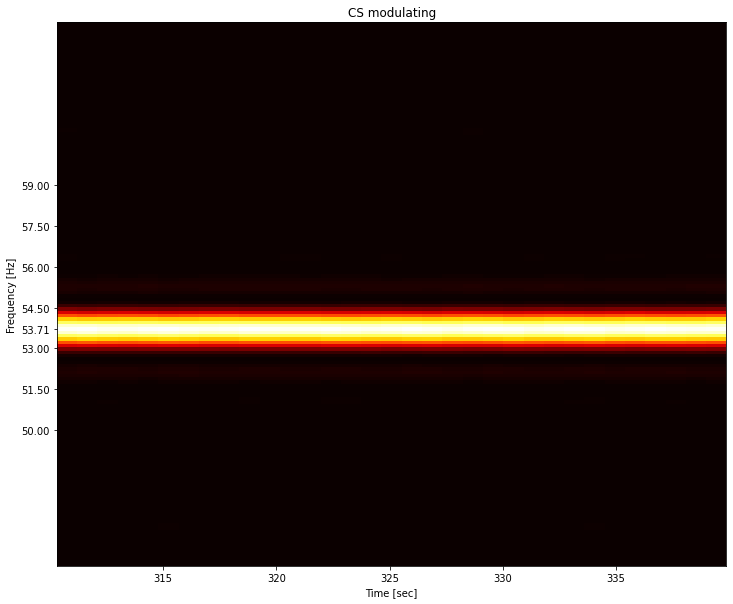

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 1: Amygdala lateral 1


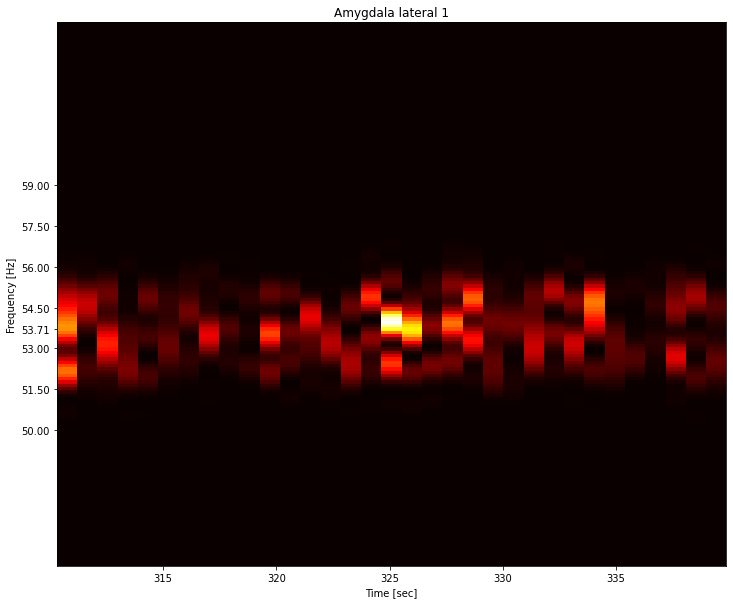

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 2: Amygdala lateral 2


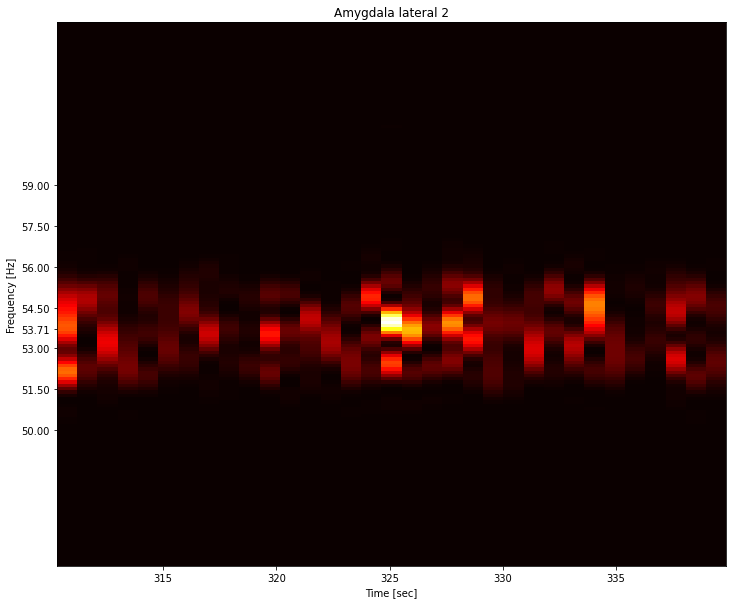

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 3: Amygdala basolateral 1


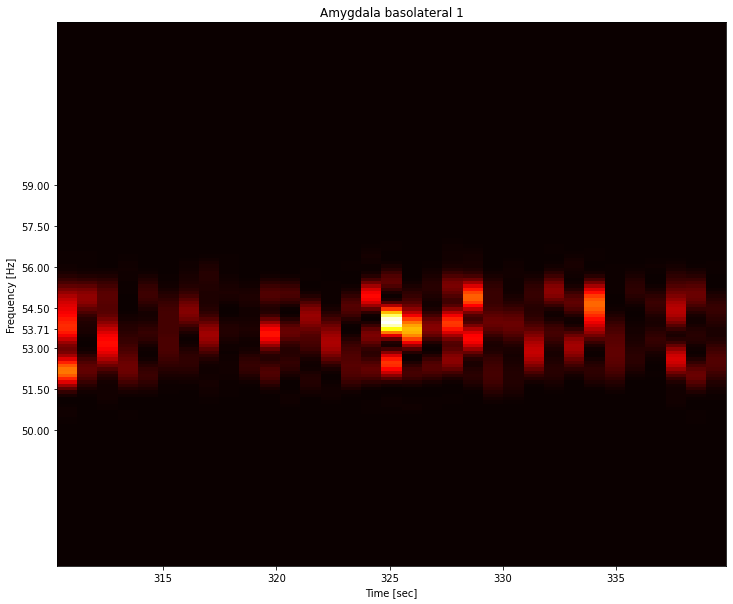

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 4: Amygdala basolateral 2


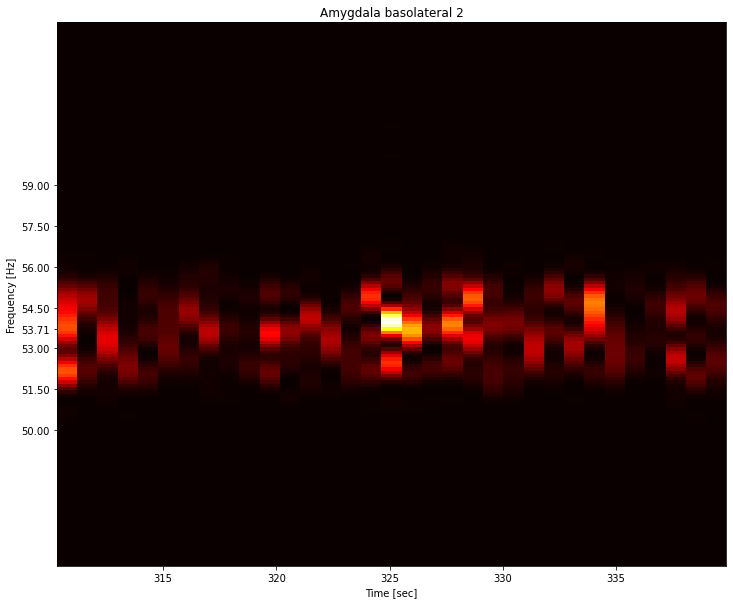

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 5: Inferior colliculus 1


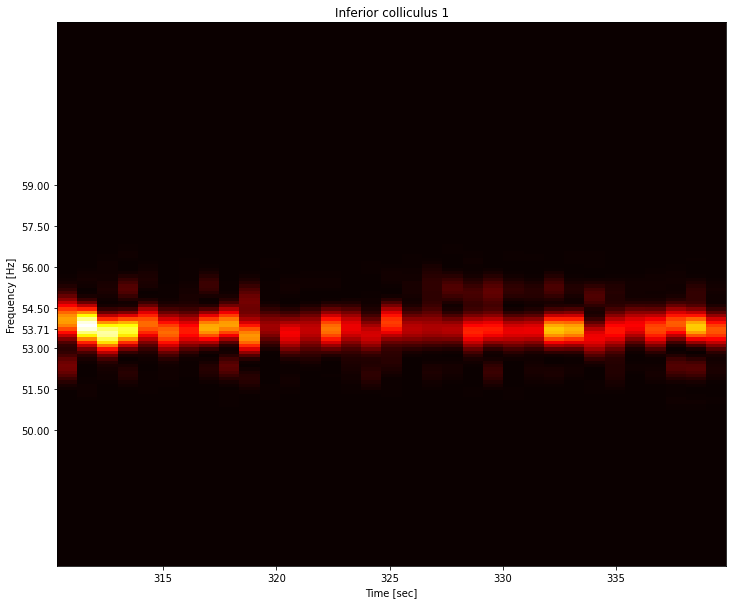

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 6: Inferior colliculus 2


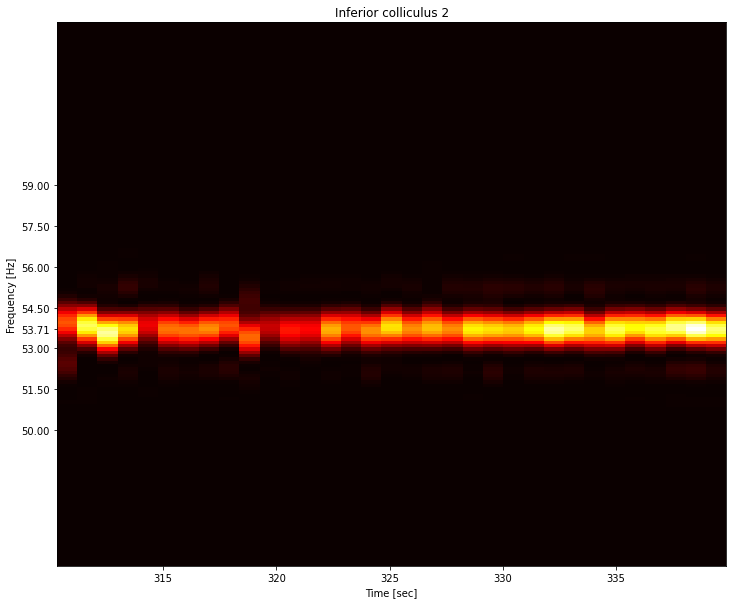

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 7: Inferior colliculus 3


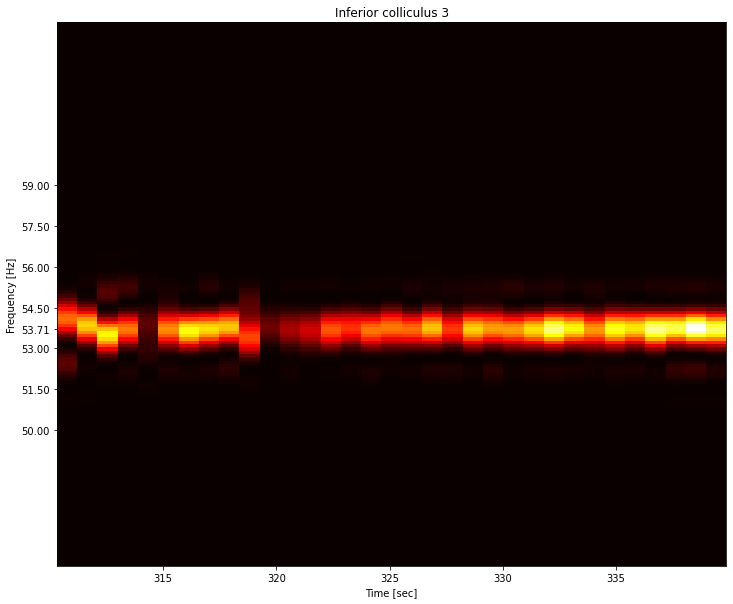

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 8: Inferior colliculus 4


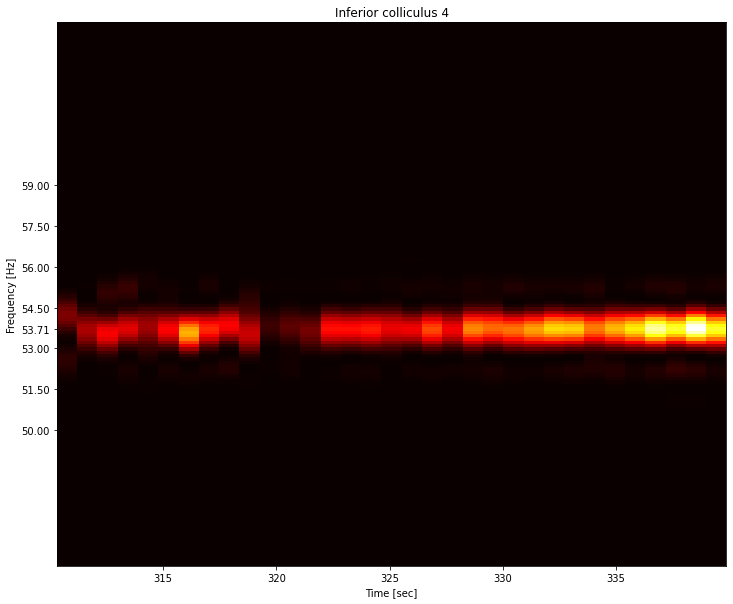

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------





In [288]:
event_number = 1

selected_data = select_event_window(
    df=data,
    event_number=event_number,
    samples_before=0,
    samples_after=0
)

run_and_plot(selected_data)

Channel 0: CS modulating


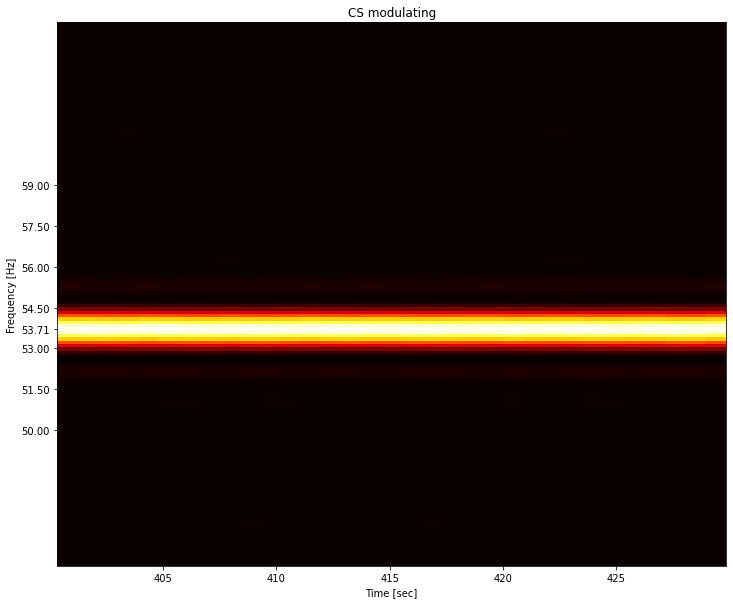

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 1: Amygdala lateral 1


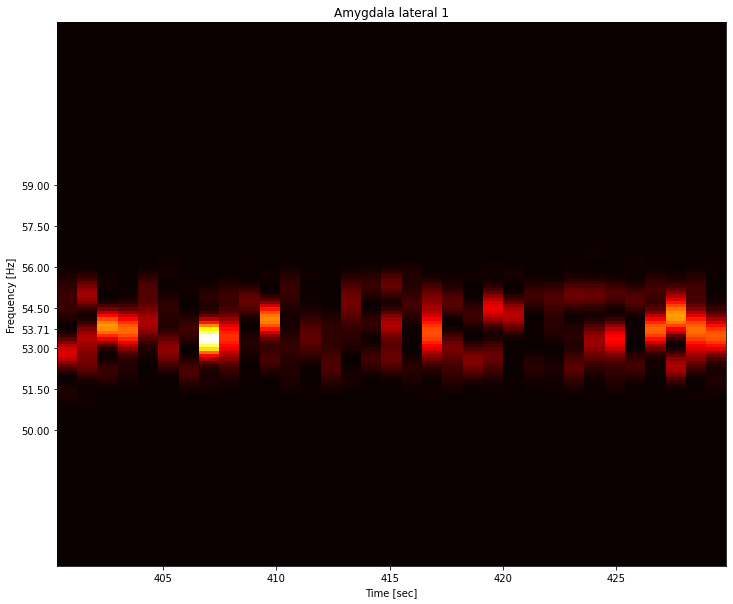

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 2: Amygdala lateral 2


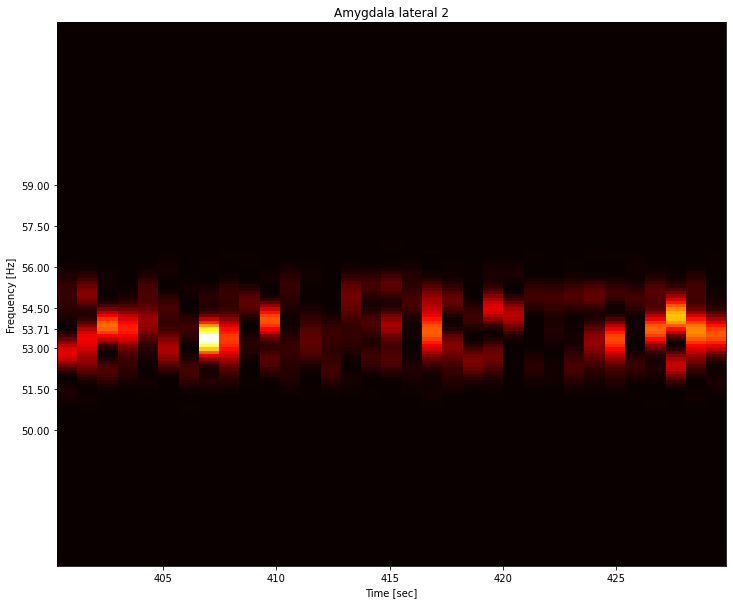

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 3: Amygdala basolateral 1


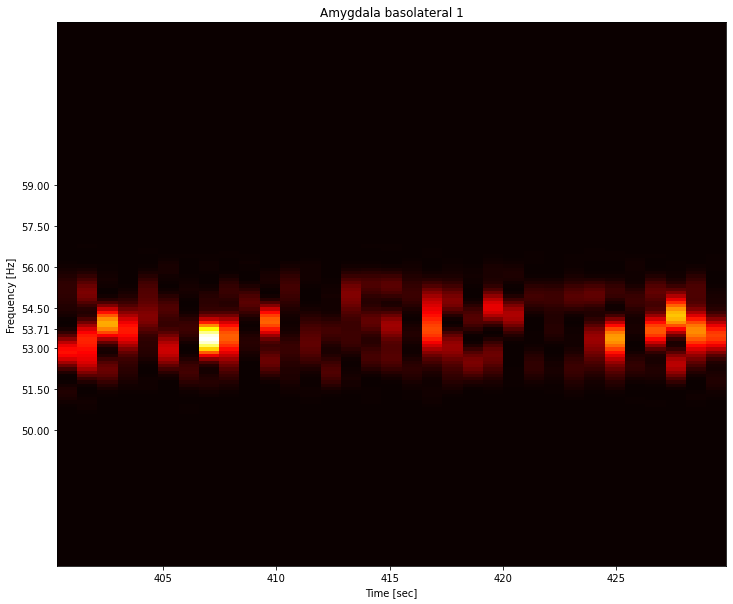

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 4: Amygdala basolateral 2


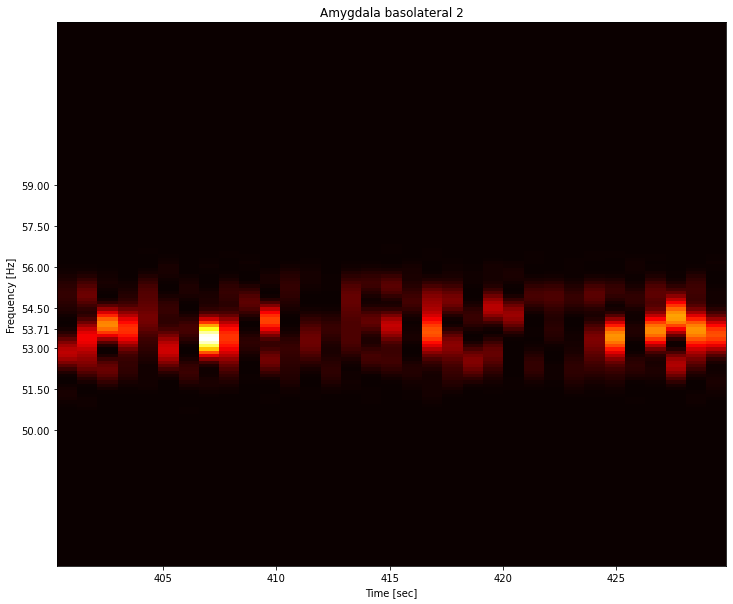

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 5: Inferior colliculus 1


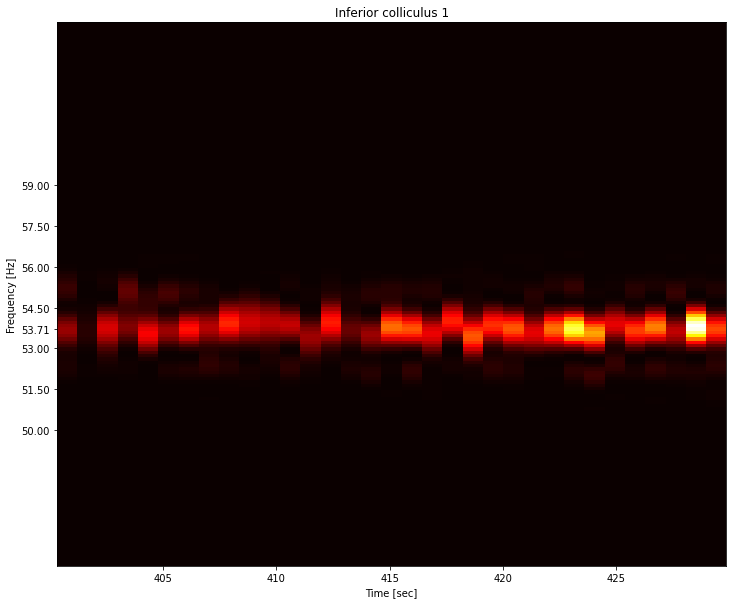

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 6: Inferior colliculus 2


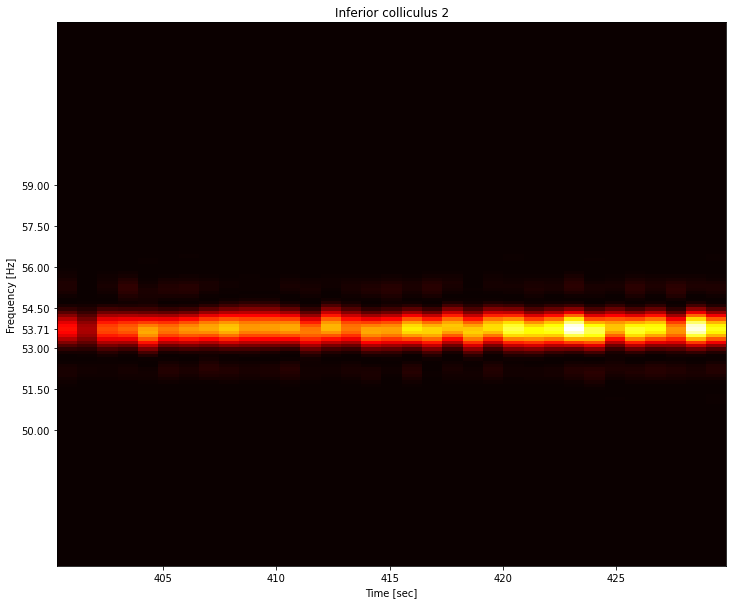

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 7: Inferior colliculus 3


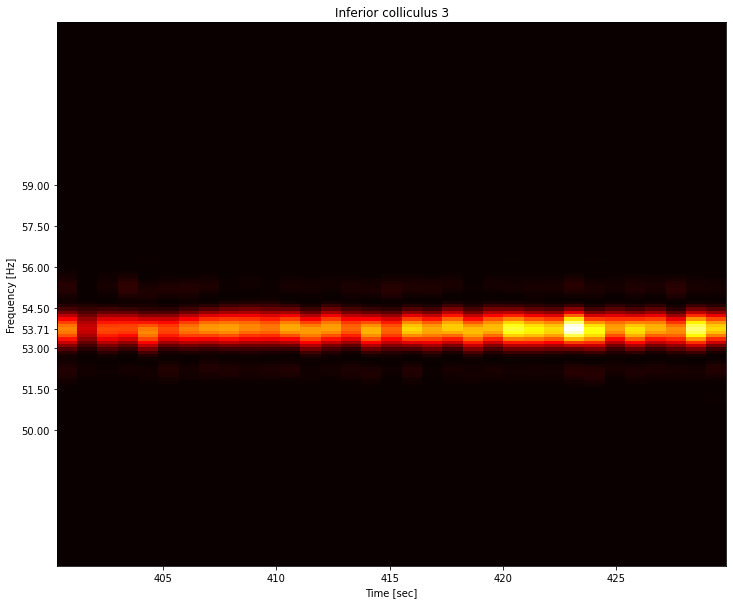

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 8: Inferior colliculus 4


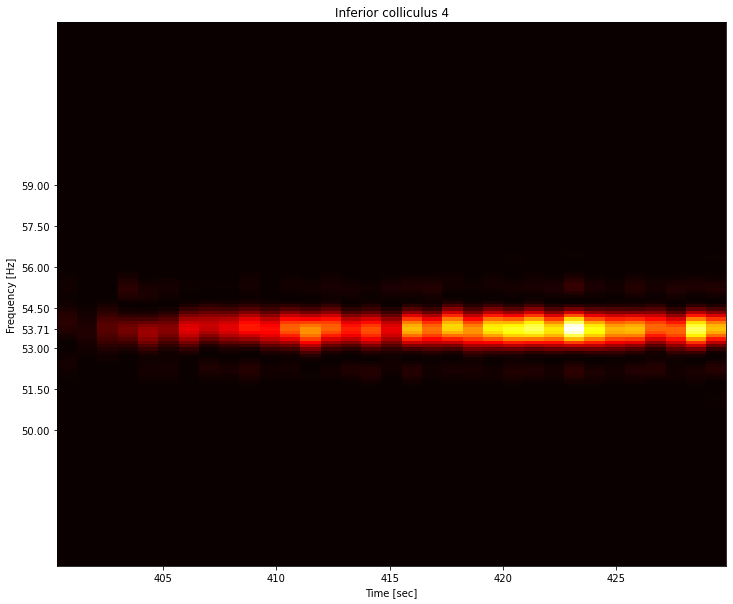

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------





In [289]:
event_number = 2

selected_data = select_event_window(
    df=data,
    event_number=event_number,
    samples_before=0,
    samples_after=0
)

run_and_plot(selected_data)

Channel 0: CS modulating


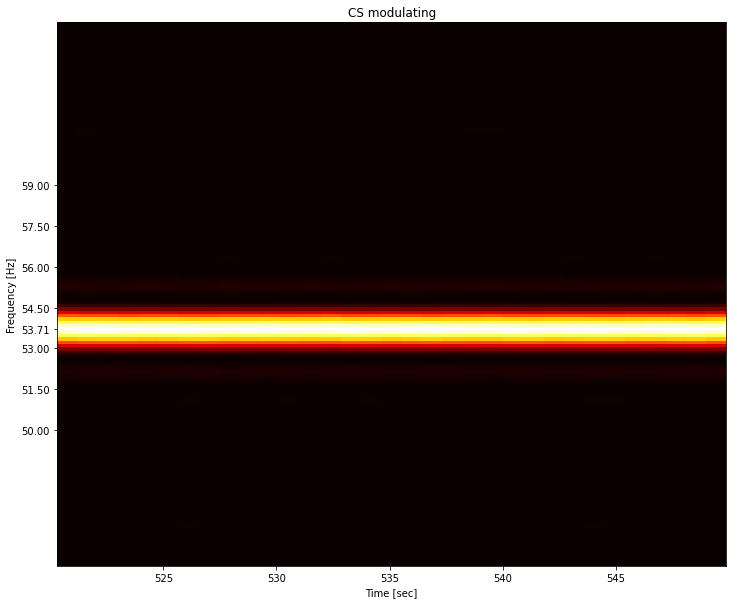

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 1: Amygdala lateral 1


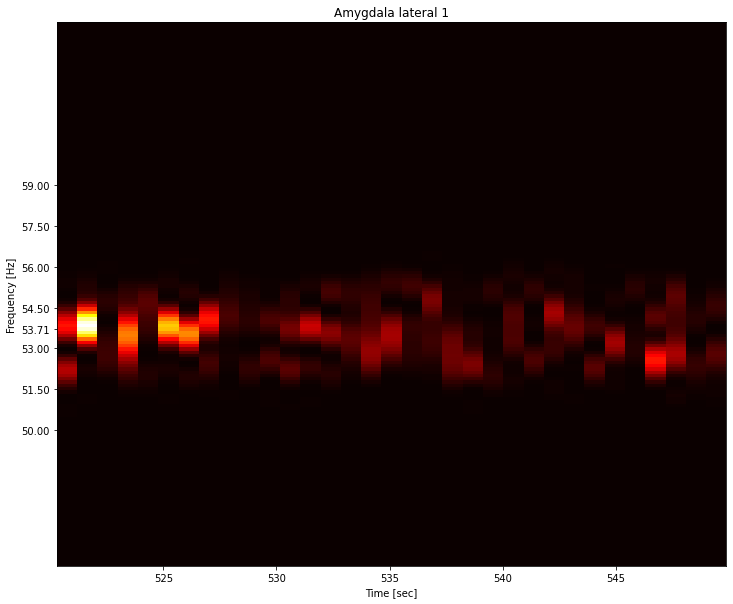

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 2: Amygdala lateral 2


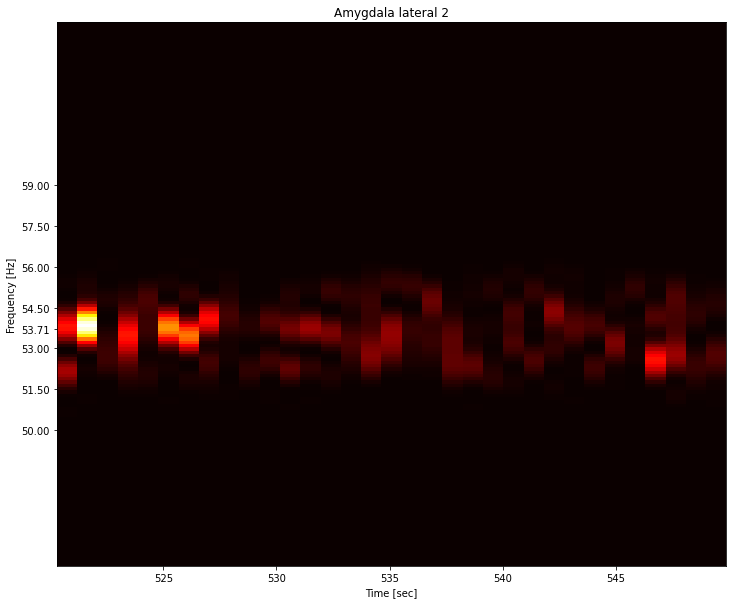

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 3: Amygdala basolateral 1


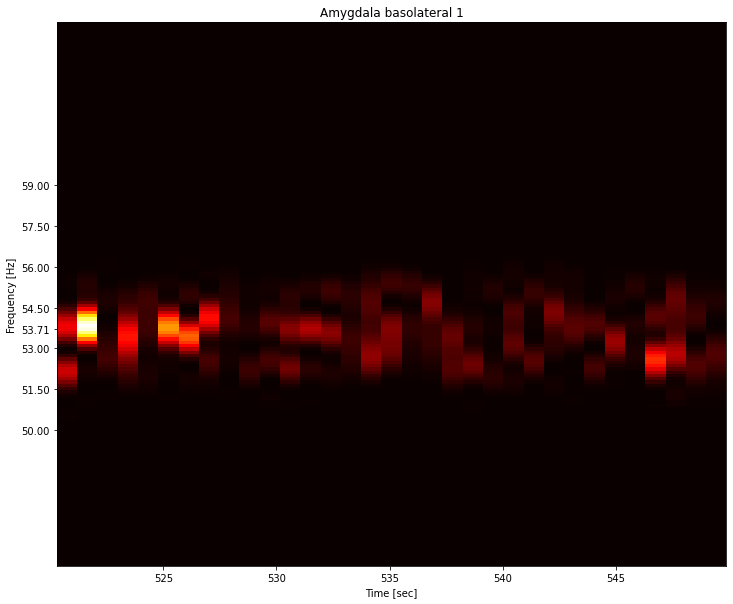

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 4: Amygdala basolateral 2


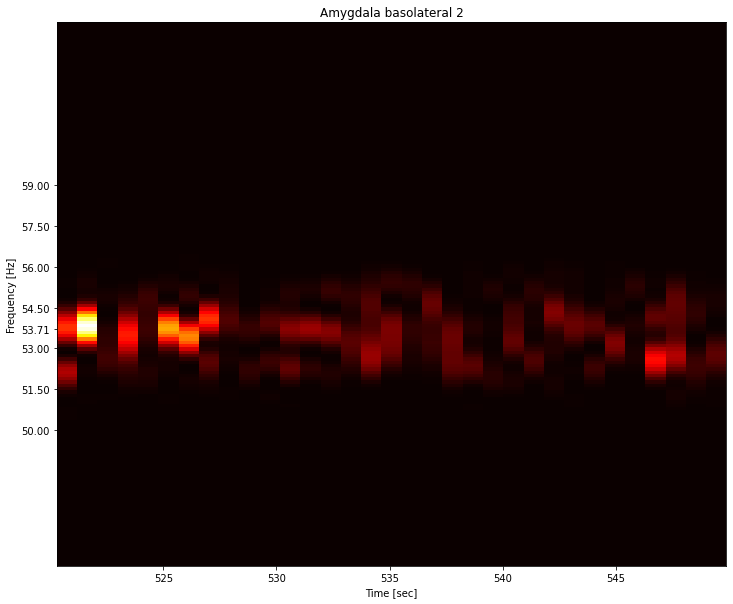

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 5: Inferior colliculus 1


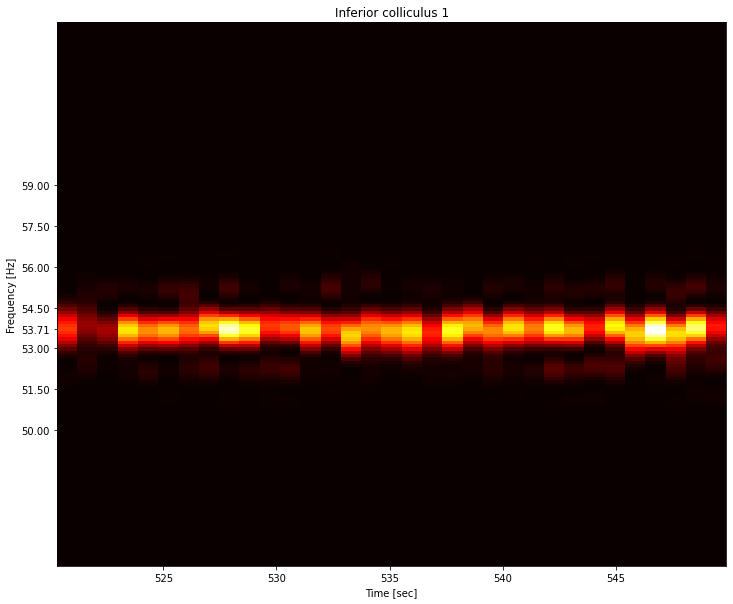

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 6: Inferior colliculus 2


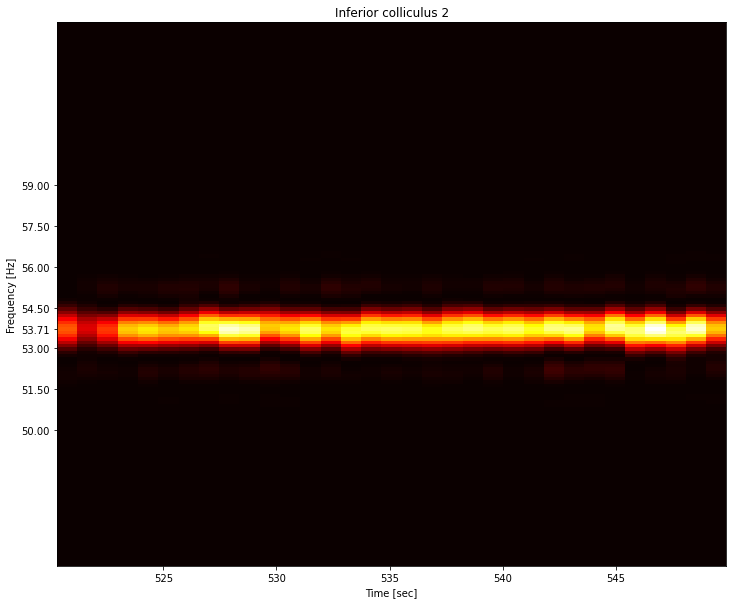

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 7: Inferior colliculus 3


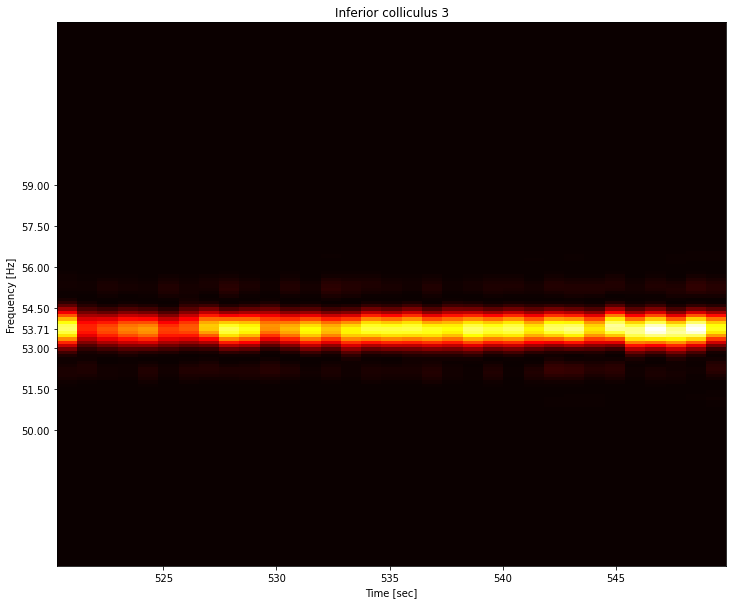

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 8: Inferior colliculus 4


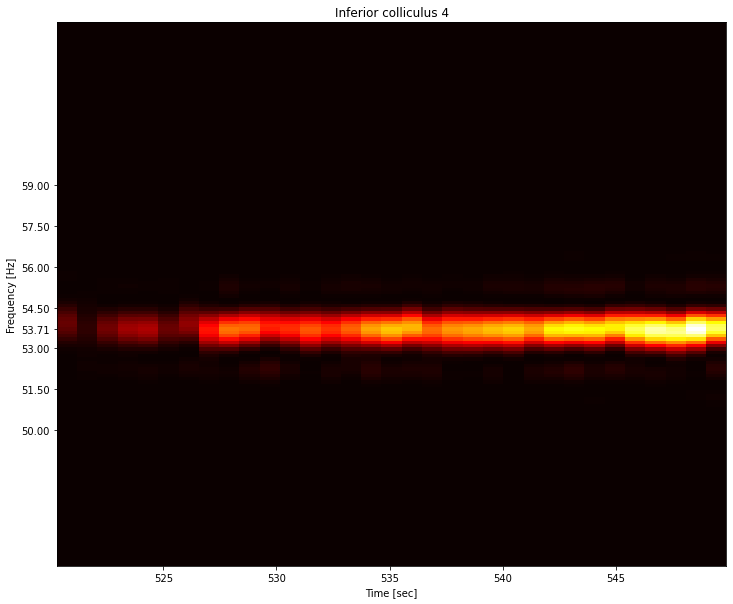

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------





In [290]:
event_number = 3

selected_data = select_event_window(
    df=data,
    event_number=event_number,
    samples_before=0,
    samples_after=0
)

run_and_plot(selected_data)

Channel 0: CS modulating


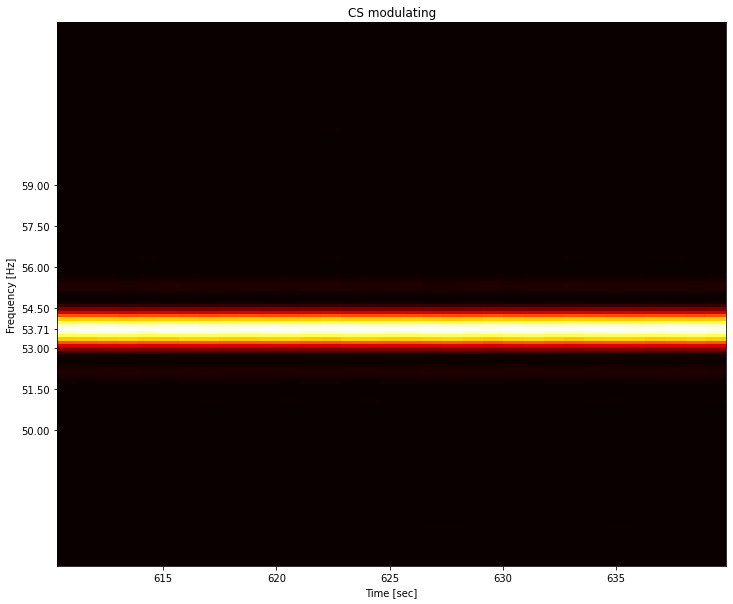

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 1: Amygdala lateral 1


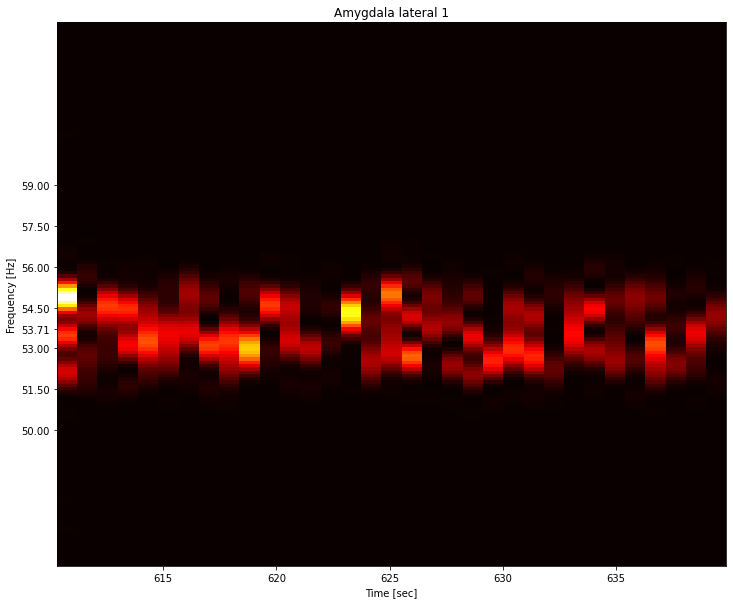

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 2: Amygdala lateral 2


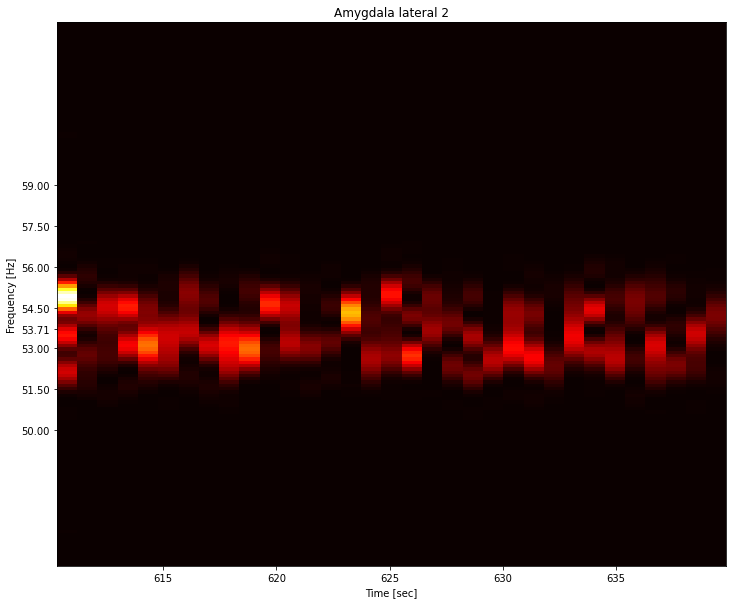

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 3: Amygdala basolateral 1


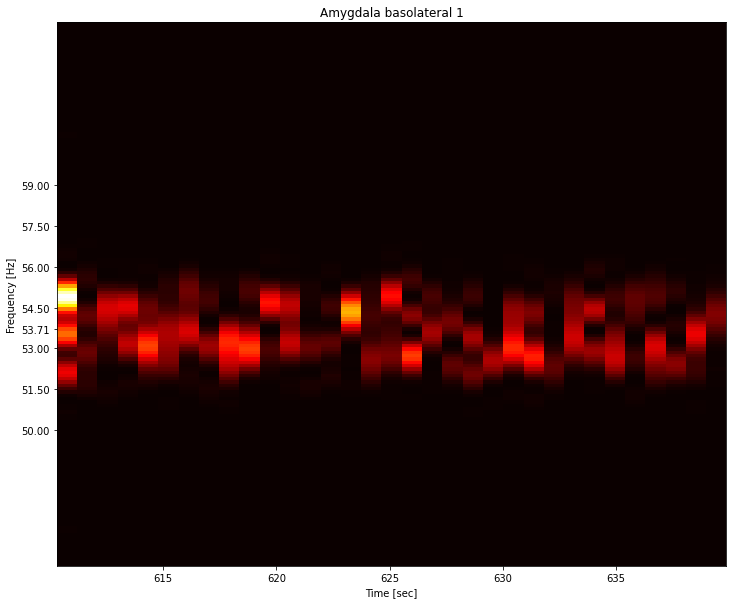

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 4: Amygdala basolateral 2


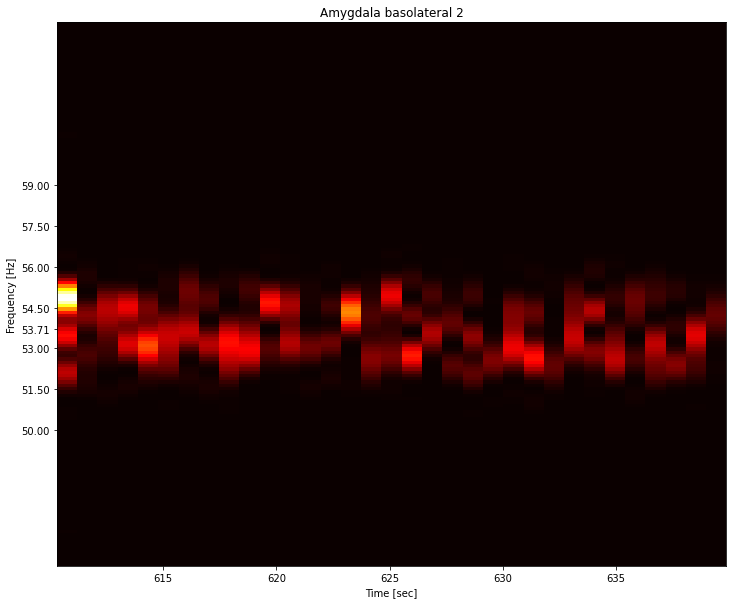

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 5: Inferior colliculus 1


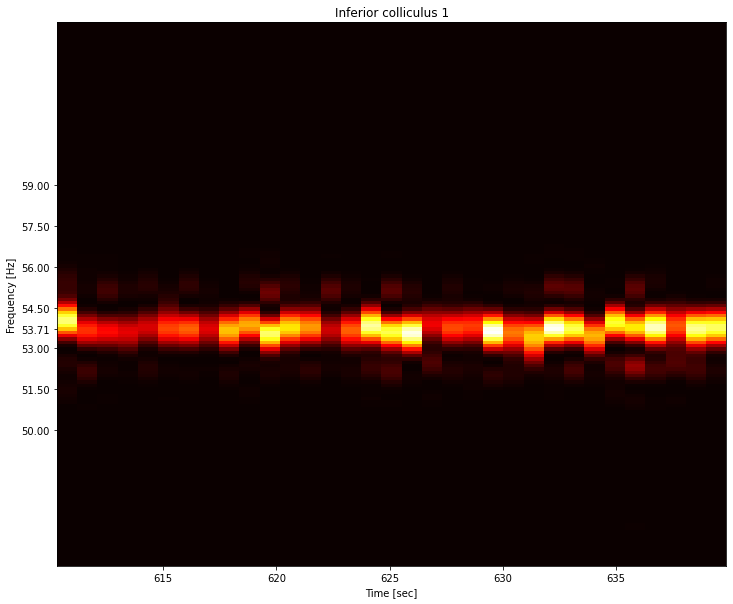

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 6: Inferior colliculus 2


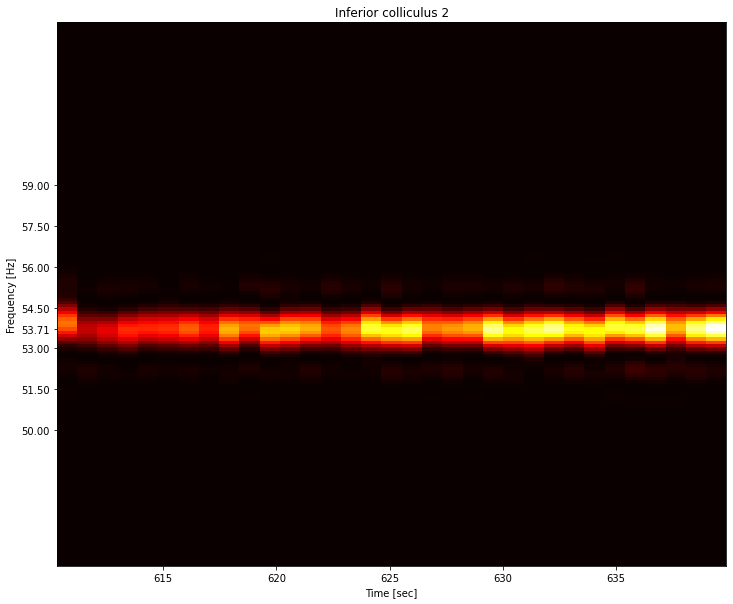

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 7: Inferior colliculus 3


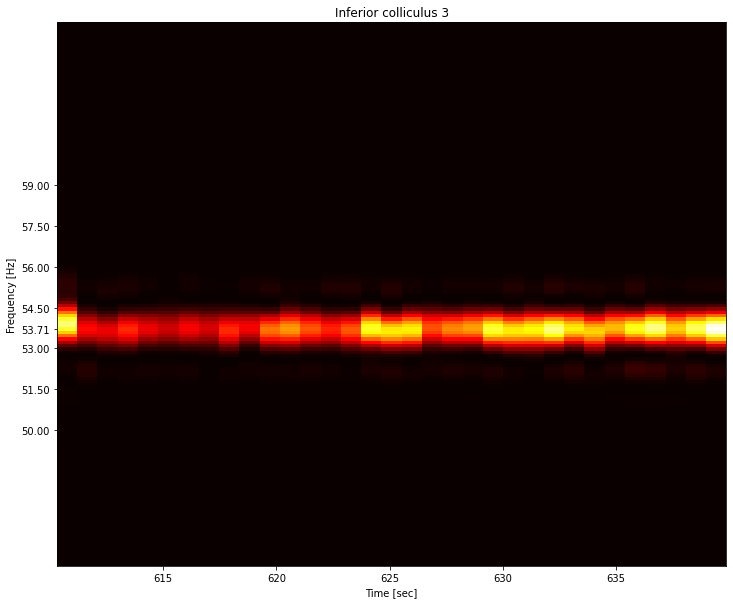

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 8: Inferior colliculus 4


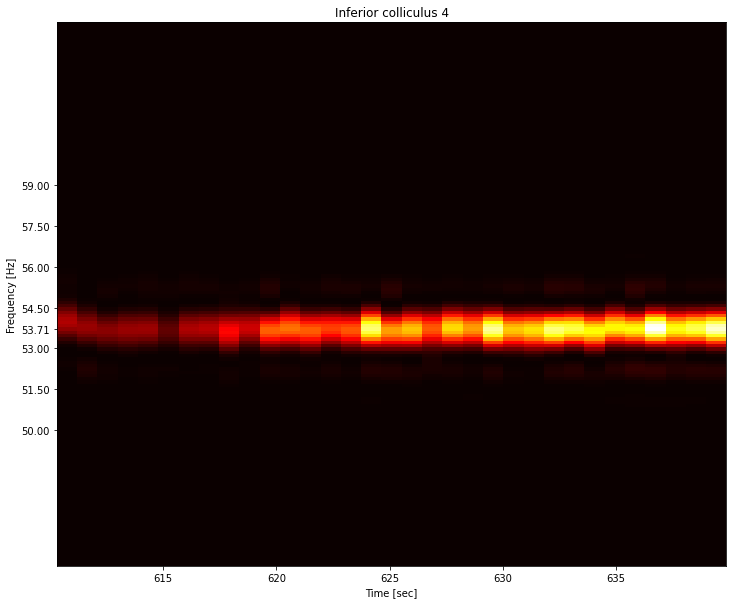

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------





In [291]:
event_number = 4

selected_data = select_event_window(
    df=data,
    event_number=event_number,
    samples_before=0,
    samples_after=0
)

run_and_plot(selected_data)

Channel 0: CS modulating


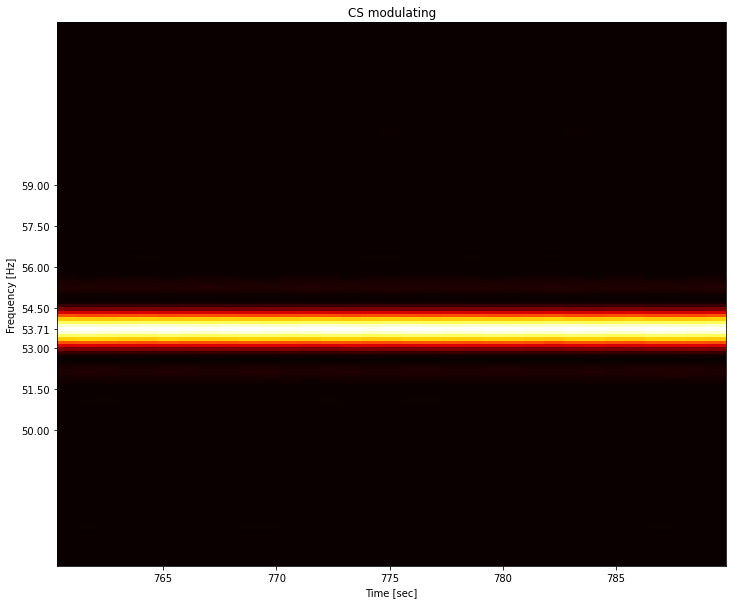

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 1: Amygdala lateral 1


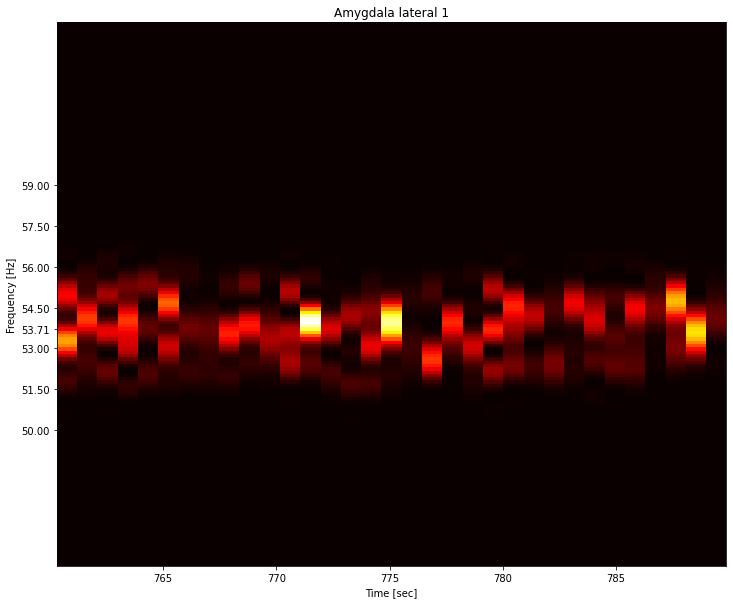

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 2: Amygdala lateral 2


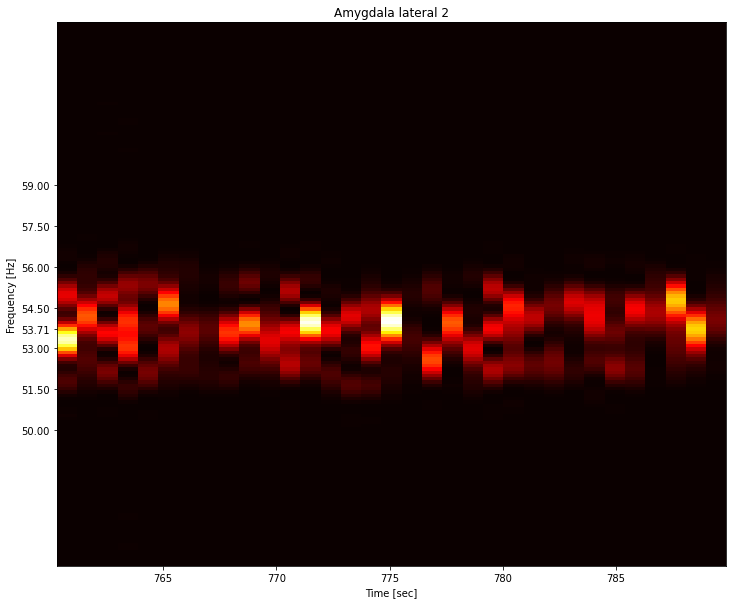

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 3: Amygdala basolateral 1


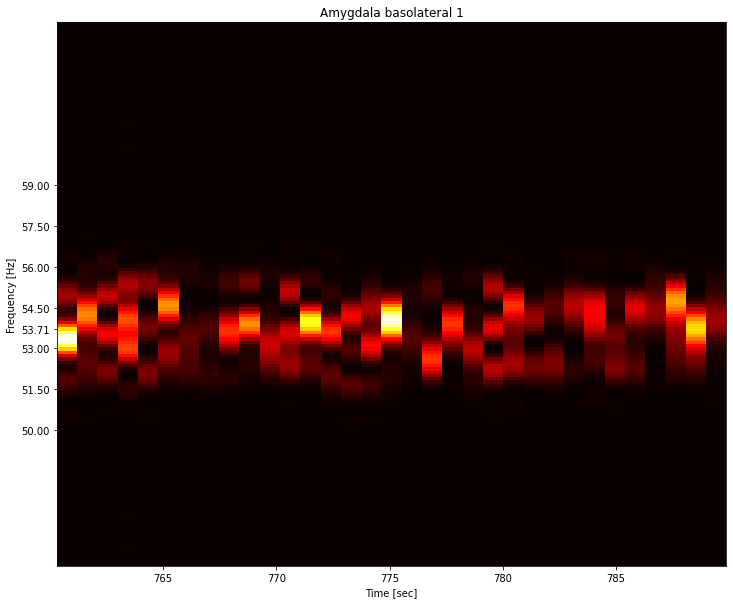

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 4: Amygdala basolateral 2


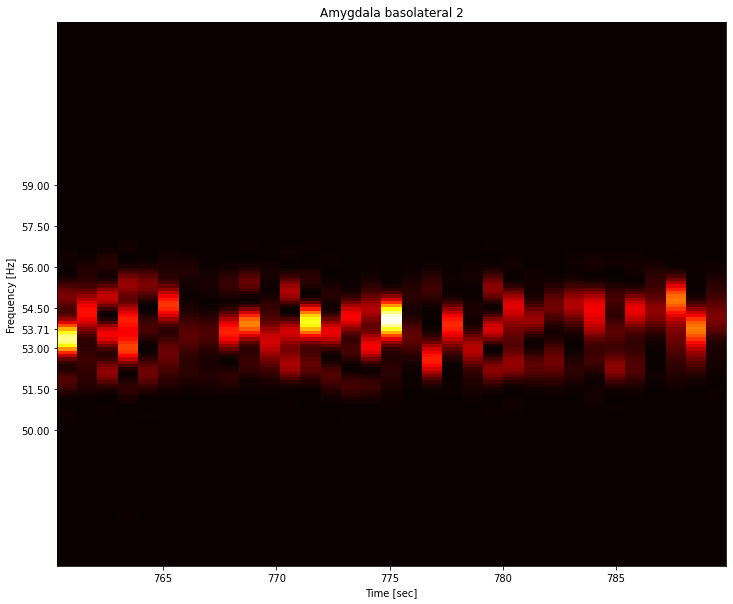

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 5: Inferior colliculus 1


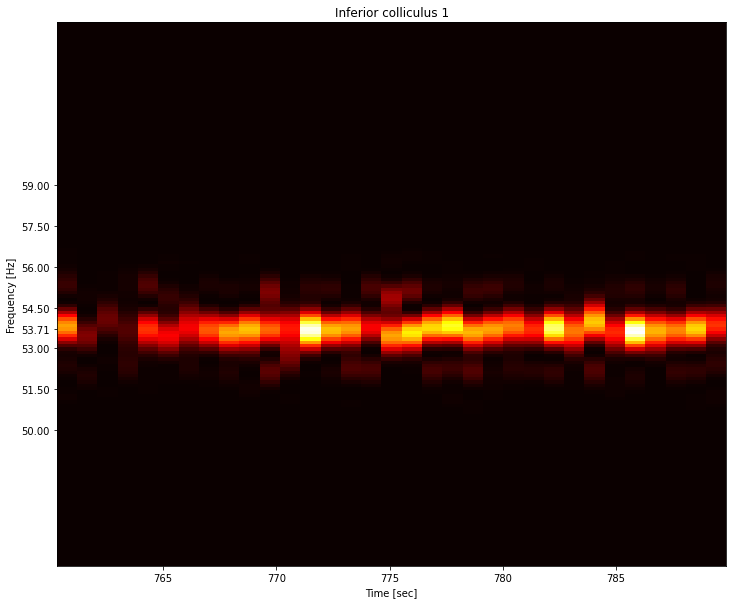

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 6: Inferior colliculus 2


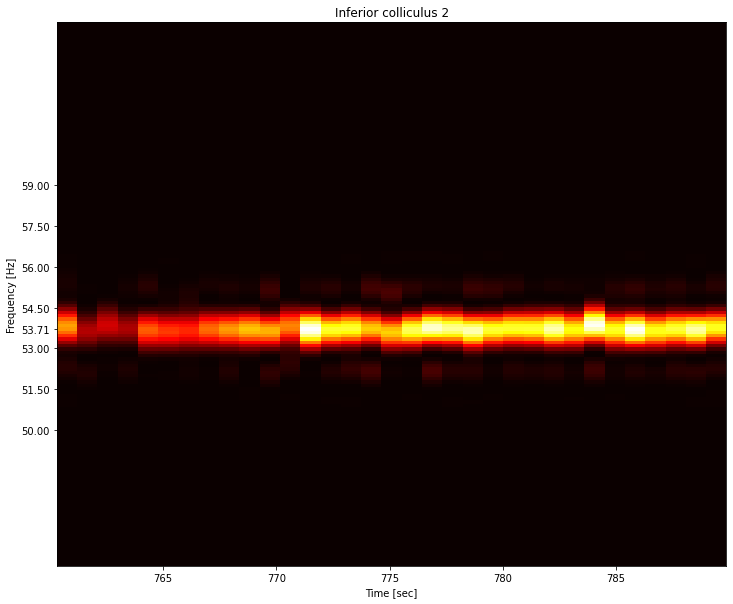

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 7: Inferior colliculus 3


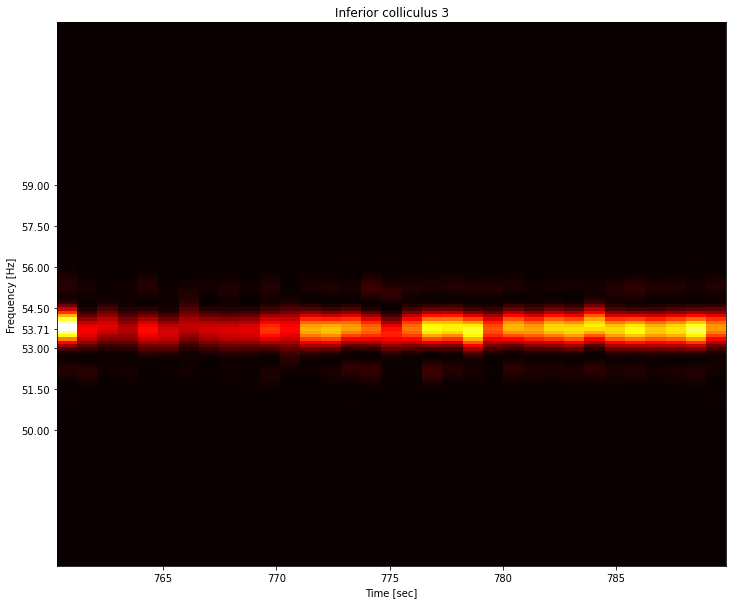

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------



Channel 8: Inferior colliculus 4


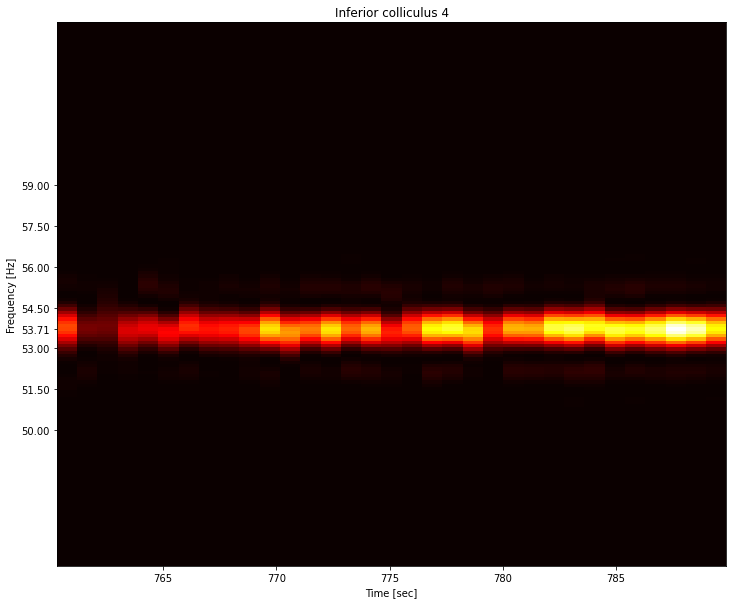

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------





In [292]:
event_number = 5

selected_data = select_event_window(
    df=data,
    event_number=event_number,
    samples_before=0,
    samples_after=0
)

run_and_plot(selected_data)

# Inferior Colliculus

# **Event 1**

In [55]:
event_number = 1


## Selecting the data related to the event 1

In [56]:
samples_before = 0
samples_after = 0
event_number = 1
fs = 1e3

event_data = select_event_window(
    df=data,
    event_number=event_number,
    samples_before=samples_before,
    samples_after=samples_after
)

In [57]:
event_data

Time  CS_modulating  Amygdala_lateral_1  Amygdala_lateral_2  \
310240  310.240      -0.766044           14.775451           14.576169   
310248  310.248       0.309017          -12.840002          -12.206013   
310256  310.256       0.173648            9.800977            8.877668   
310264  310.264      -0.500000           -6.080660           -5.053063   
310272  310.272       0.809017            2.130790            1.187406   
...         ...            ...                 ...                 ...   
340176  340.176       0.173648           -5.966997           -7.074189   
340184  340.184      -0.587785            3.802850            5.251467   
340192  340.192       0.939693           -1.121782           -2.919069   
340200  340.200      -1.000000           -1.570660            0.498548   
340208  340.208       0.939693            3.760132            1.584319   

        Amygdala_basolateral_1  Amygdala_basolateral_2  Inferior_colliculus_1  \
310240               13.650979               13.374914              14.851928   
310248              -11.710375              -11.304154             -11.817004   
310256                8.787161                8.377473               7.718673   
310264               -5.304444               -4.996811              -2.991314   
310272                1.692492                1.551314              -1.874234   
...                        ...                     ...                    ...   
340176              -10.600101               -8.486896              14.847482   
340184                7.653419                5.901649             -13.242075   
340192               -3.818569               -2.762233               9.206882   
340200               -0.280765               -0.425298              -3.278339   
340208                3.985757                3.161783              -3.668677   

        Inferior_colliculus_2  Inferior_colliculus_3  Inferior_colliculus_4  \
310240              12.973613              12.430515              26.372591   
310248              -6.689360              -1.986873             -19.600532   
310256              -0.284754              -8.581819              10.297623   
310264               7.043754              17.788036               0.181099   
310272             -12.713439             -24.345955             -10.353401   
...                       ...                    ...                    ...   
340176              26.326536              27.542430              15.849365   
340184             -24.138574             -26.586861             -14.438182   
340192              17.872364              21.096374               8.737373   
340200              -8.514864             -11.939160               0.409922   
340208              -2.444580               0.592929             -11.406721   

       events_index events_behavior_TS_LFP  
310240            1                   None  
310248            1                   None  
310256            1                   None  
310264            1                   None  
310272            1                   None  
...             ...                    ...  
340176            1                      3  
340184            1                      3  
340192            1                      3  
340200            1                      3  
340208            1                      3  

[3747 rows x 12 columns]

In [58]:
time = event_data.Time

In [59]:
CS = event_data.CS_modulating
analytic_signal_CS = hilbert(CS)
phase_data_CS = np.unwrap(np.angle(analytic_signal_CS))

# Inferior Colliculus I

In [60]:
ic1 = event_data.Inferior_colliculus_1
analytic_signal_ic1 = hilbert(ic1)
phase_data_ic1 = np.unwrap(np.angle(analytic_signal_ic1))

In [61]:
phase_angle_diff = phase_data_CS - phase_data_ic1

In [62]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [63]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.3843


In [64]:
sliding_window_size = 3.0 # seconds
event_time = event_data.Time.to_numpy()
window_size = np.round(event_time[-1] - event_time[0], 0)
print(f"The event has a duration of {window_size} seconds")
number_of_windows = int(window_size//sliding_window_size)
print(f"The {number_of_windows} sliding windows has durations of {sliding_window_size} seconds")

The event has a duration of 30.0 seconds
The 10 sliding windows has durations of 3.0 seconds


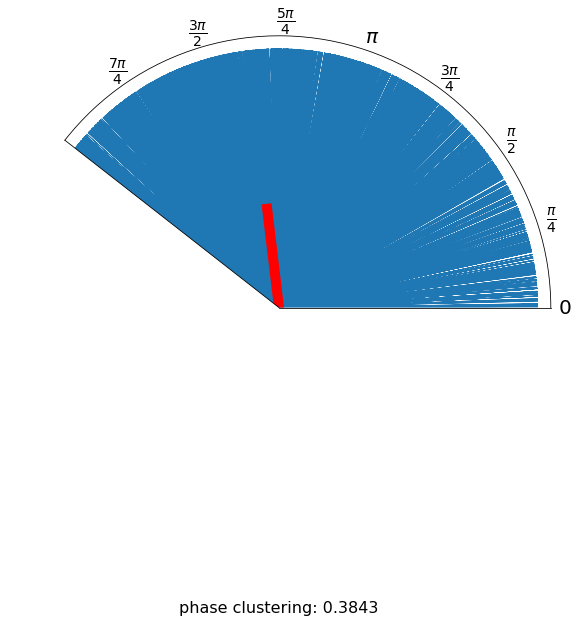

In [65]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

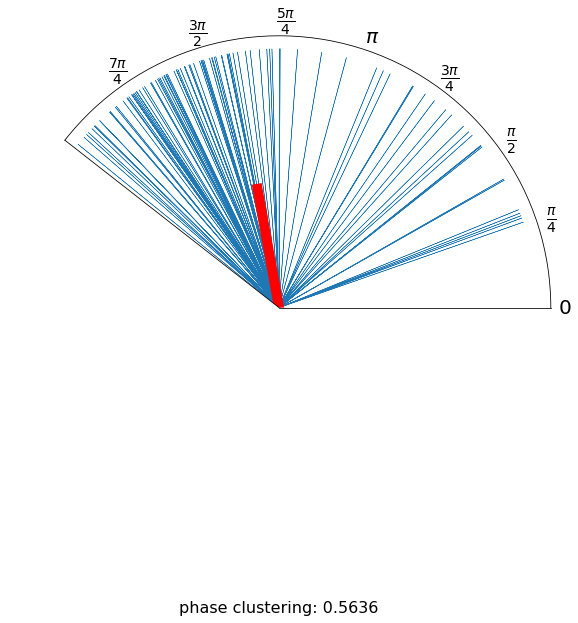

In [66]:
ic_data_complete = event_data.Inferior_colliculus_1


sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Inferior Colliculus II

In [67]:
ic2 = event_data.Inferior_colliculus_2
analytic_signal_ic2 = hilbert(ic2)
phase_data_ic2 = np.unwrap(np.angle(analytic_signal_ic2))

In [68]:
phase_angle_diff = phase_data_CS - phase_data_ic2

In [69]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [70]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.7347


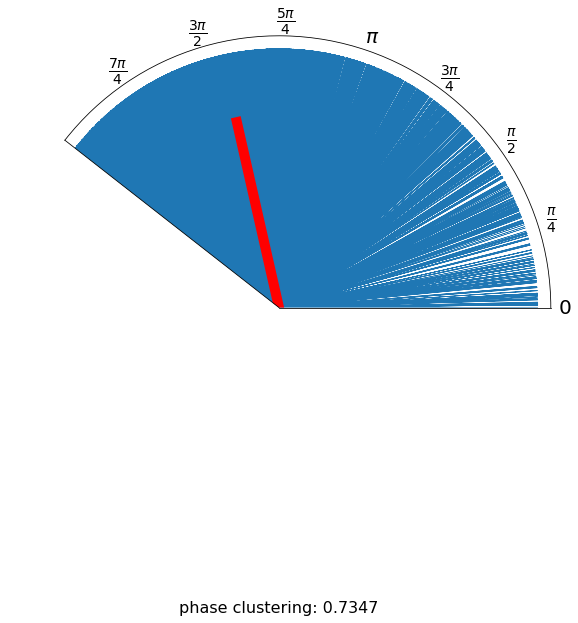

In [71]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

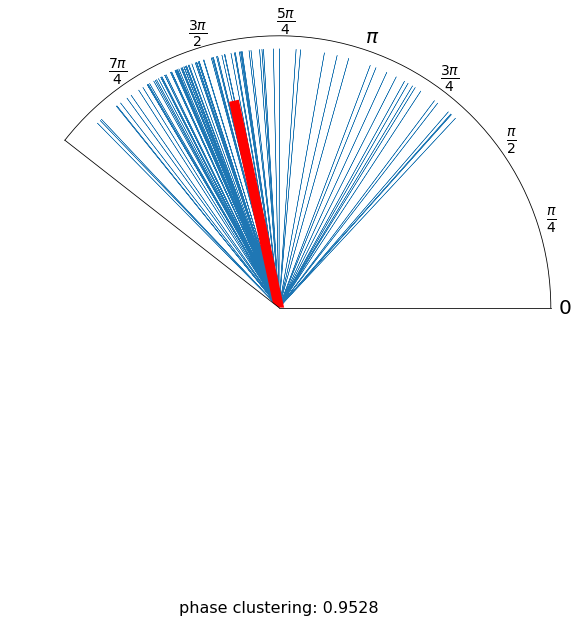

In [72]:
ic_data_complete = event_data.Inferior_colliculus_2

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Inferior Colliculus III

In [73]:
ic3 = event_data.Inferior_colliculus_3
analytic_signal_ic3 = hilbert(ic3)
phase_data_ic3 = np.unwrap(np.angle(analytic_signal_ic3))

In [74]:
phase_angle_diff = phase_data_CS - phase_data_ic3

In [75]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [76]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.7087


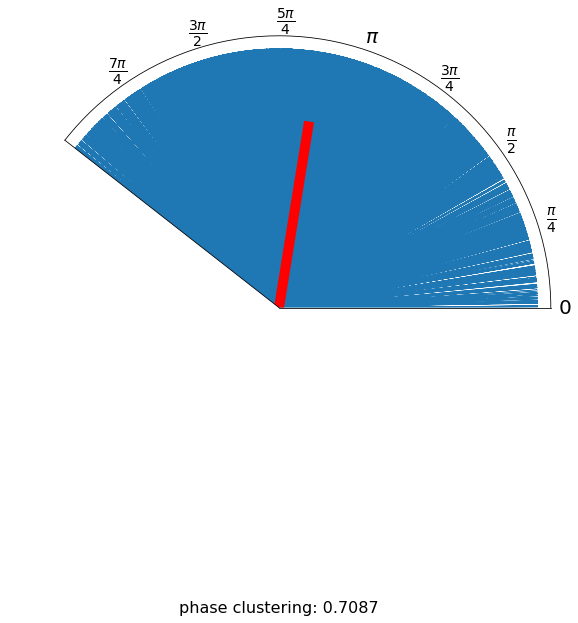

In [77]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

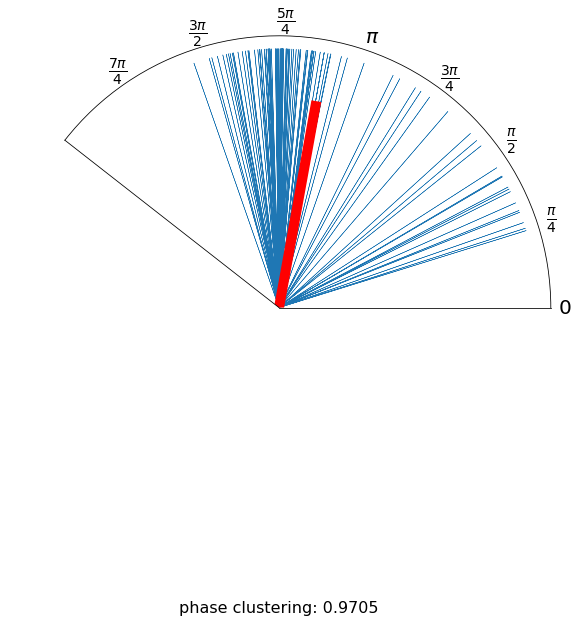

In [78]:
ic_data_complete = event_data.Inferior_colliculus_3

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Inferior Colliculus IV

In [79]:
ic4 = event_data.Inferior_colliculus_4
analytic_signal_ic4 = hilbert(ic4)
phase_data_ic4 = np.unwrap(np.angle(analytic_signal_ic4))

In [80]:
phase_angle_diff = phase_data_CS - phase_data_ic4

In [81]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [82]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.6741


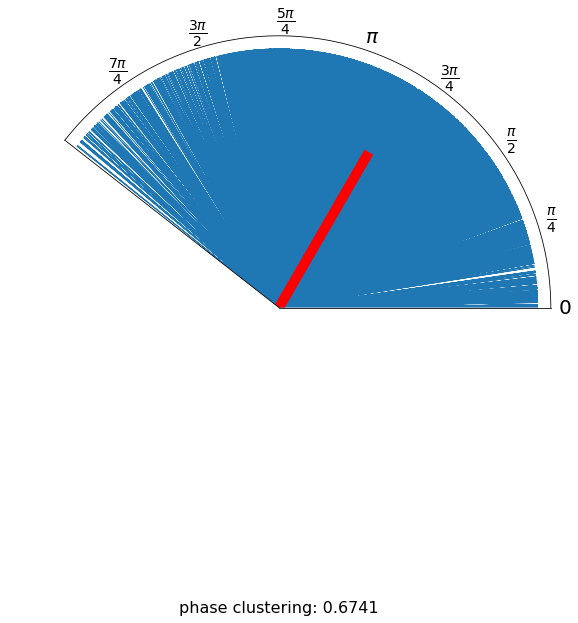

In [83]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

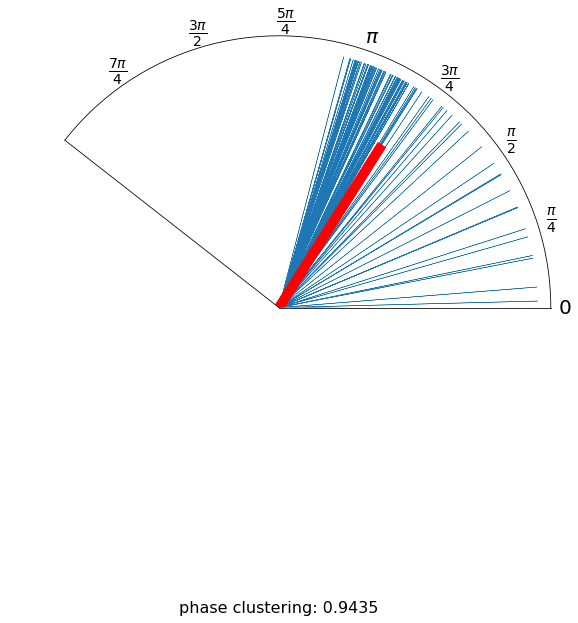

In [84]:
ic_data_complete = event_data.Inferior_colliculus_4

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# **Event 2**

## Selecting the data related to the event 2

In [85]:
samples_before = 0
samples_after = 0
event_number = 2
fs = 1e3

event_data = select_event_window(
    df=data,
    event_number=event_number,
    samples_before=samples_before,
    samples_after=samples_after
)

In [86]:
event_data

Time  CS_modulating  Amygdala_lateral_1  Amygdala_lateral_2  \
400240  400.240      -0.500000            4.866218            1.095011   
400248  400.248       0.173648            2.506965            6.352816   
400256  400.256       0.309017           -9.412458          -12.824331   
400264  400.264      -0.766044           15.088085           17.588919   
400272  400.272       0.939693          -18.958519          -20.170706   
...         ...            ...                 ...                 ...   
430176  430.176       0.500000            4.863143            2.688116   
430184  430.184      -0.809017           -3.085498           -0.528218   
430192  430.192       1.000000            0.590815           -2.046403   
430200  430.200      -0.939693            2.408898            4.830795   
430208  430.208       0.766044           -5.590614           -7.545799   

        Amygdala_basolateral_1  Amygdala_basolateral_2  Inferior_colliculus_1  \
400240                4.792058                7.755800              36.443401   
400248                2.292787               -1.236152             -33.740388   
400256               -8.738500               -5.140274              27.316267   
400264               13.862494               10.641224             -17.930732   
400272              -17.196057              -14.686078               6.726856   
...                        ...                     ...                    ...   
430176                0.943270                1.013920               5.320562   
430184                1.654613                1.098485              -4.114197   
430192               -4.506479               -3.471731               2.219431   
430200                7.386872                5.880570               0.101677   
430208              -10.007999               -8.050812              -2.516979   

        Inferior_colliculus_2  Inferior_colliculus_3  Inferior_colliculus_4  \
400240              48.144182              61.678290              37.609109   
400248             -39.843675             -50.411706             -29.035383   
400256              26.555675              32.589321              16.980293   
400264              -9.893887             -10.429038              -3.018316   
400272              -8.019574             -13.175906             -11.006700   
...                       ...                    ...                    ...   
430176              22.692203              20.536145               6.838703   
430184             -20.344832             -22.692594             -11.773342   
430192              15.086745              21.516888              14.672745   
430200              -7.808120             -17.346264             -15.381166   
430208              -0.326753              10.955975              14.094579   

       events_index events_behavior_TS_LFP  
400240            2                      3  
400248            2                      3  
400256            2                      3  
400264            2                      3  
400272            2                      3  
...             ...                    ...  
430176            2                      4  
430184            2                      4  
430192            2                      4  
430200            2                      4  
430208            2                      4  

[3747 rows x 12 columns]

In [87]:
time = event_data.Time

In [88]:
CS = event_data.CS_modulating
analytic_signal_CS = hilbert(CS)
phase_data_CS = np.unwrap(np.angle(analytic_signal_CS))

# Inferior Colliculus I

In [89]:
ic1 = event_data.Inferior_colliculus_1
analytic_signal_ic1 = hilbert(ic1)
phase_data_ic1 = np.unwrap(np.angle(analytic_signal_ic1))

In [90]:
phase_angle_diff = phase_data_CS - phase_data_ic1

In [91]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [92]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.4017


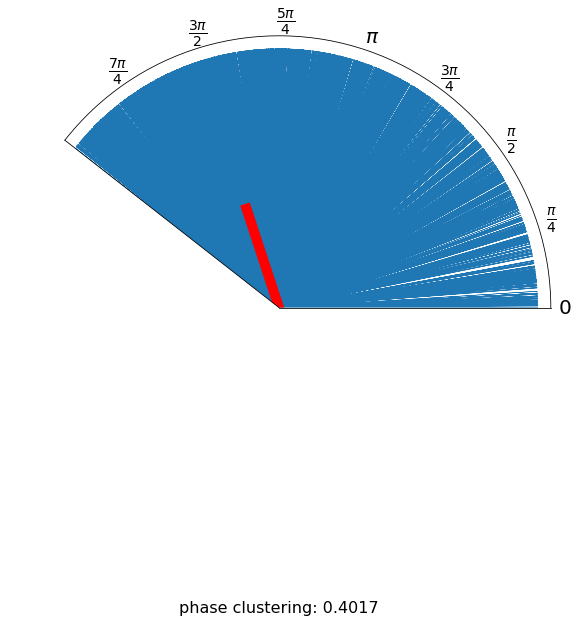

In [93]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

In [94]:
sliding_window_size = 3.0 # seconds
event_time = event_data.Time.to_numpy()
window_size = np.round(event_time[-1] - event_time[0], 0)
print(f"The event has a duration of {window_size} seconds")
number_of_windows = int(window_size//sliding_window_size)
print(f"The {number_of_windows} sliding windows has durations of {sliding_window_size} seconds")

The event has a duration of 30.0 seconds
The 10 sliding windows has durations of 3.0 seconds


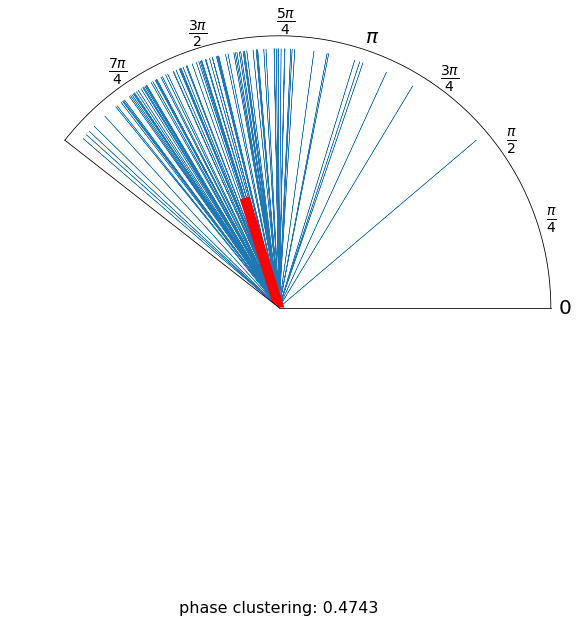

In [95]:
ic_data_complete = event_data.Inferior_colliculus_1

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Inferior Colliculus II

In [96]:
ic2 = event_data.Inferior_colliculus_2
analytic_signal_ic2 = hilbert(ic2)
phase_data_ic2 = np.unwrap(np.angle(analytic_signal_ic2))

In [97]:
phase_angle_diff = phase_data_CS - phase_data_ic2

In [98]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [99]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.8029


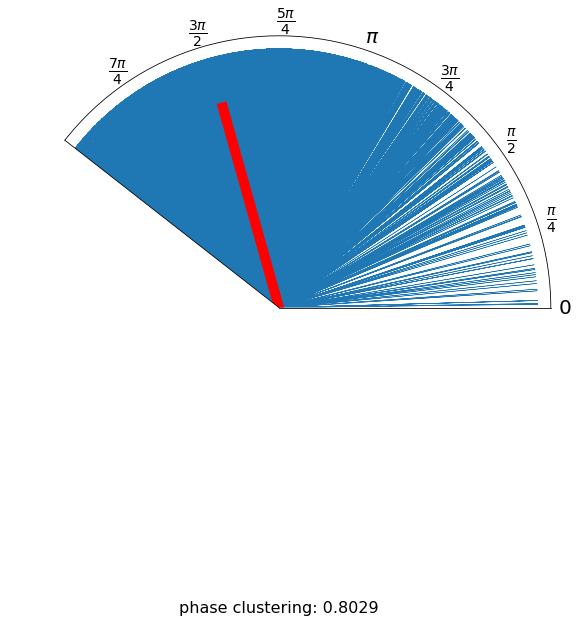

In [100]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

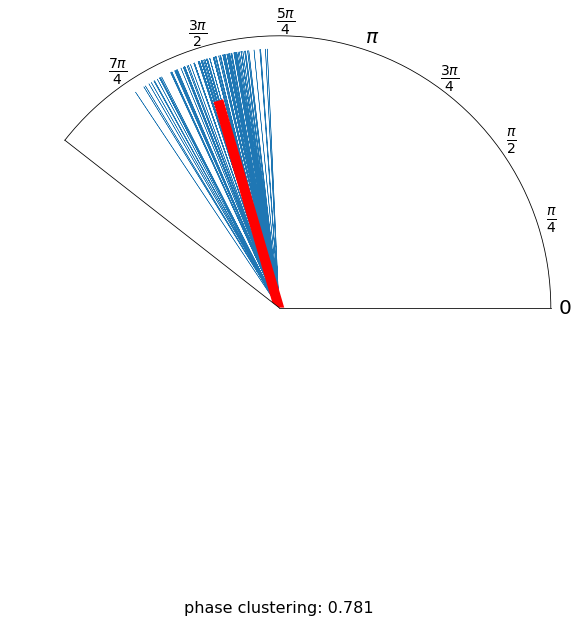

In [101]:
ic_data_complete = event_data.Inferior_colliculus_2

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Inferior Colliculus III

In [102]:
ic3 = event_data.Inferior_colliculus_3
analytic_signal_ic3 = hilbert(ic3)
phase_data_ic3 = np.unwrap(np.angle(analytic_signal_ic3))

In [103]:
phase_angle_diff = phase_data_CS - phase_data_ic3

In [104]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [105]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.802


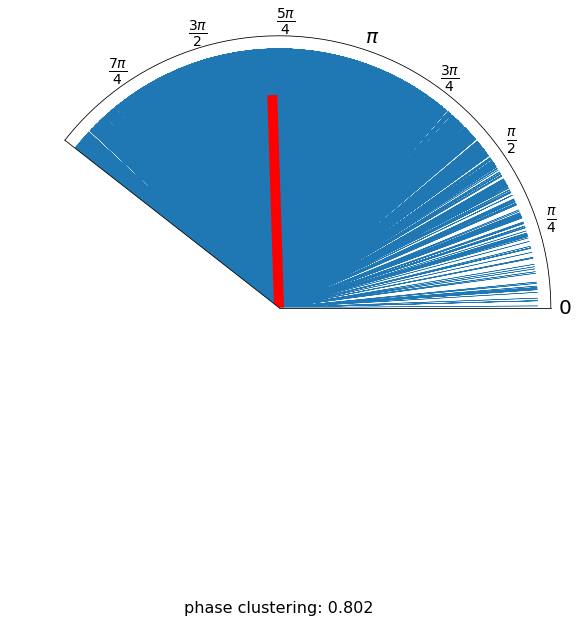

In [106]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

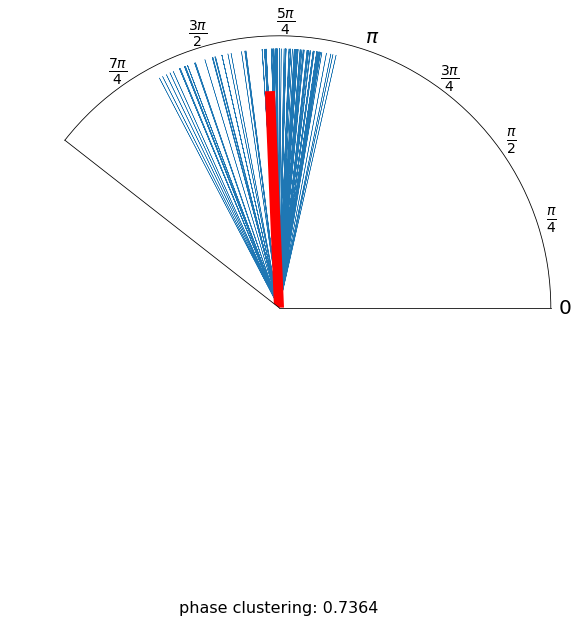

In [107]:
ic_data_complete = event_data.Inferior_colliculus_3

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Inferior Colliculus IV

In [108]:
ic4 = event_data.Inferior_colliculus_4
analytic_signal_ic4 = hilbert(ic4)
phase_data_ic4 = np.unwrap(np.angle(analytic_signal_ic4))

In [109]:
phase_angle_diff = phase_data_CS - phase_data_ic4

In [110]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [111]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.6874


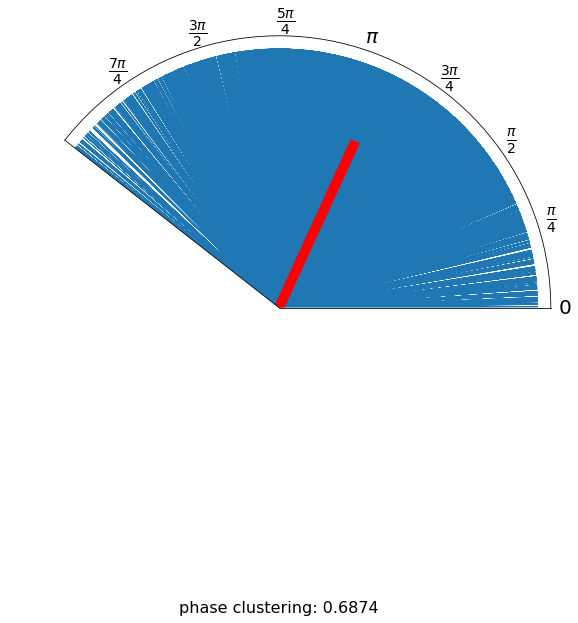

In [112]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

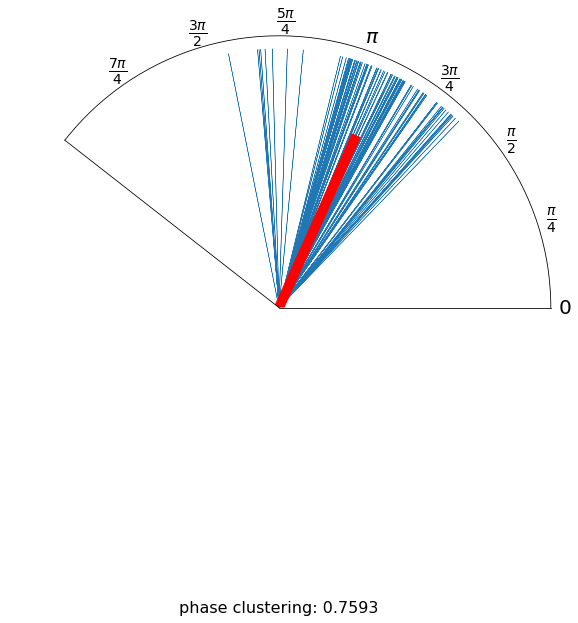

In [113]:
ic_data_complete = event_data.Inferior_colliculus_4

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# **Event 3**

## Selecting the data related to the event 1

In [114]:
samples_before = 0
samples_after = 0
event_number = 3
fs = 1e3

event_data = select_event_window(
    df=data,
    event_number=event_number,
    samples_before=samples_before,
    samples_after=samples_after
)

In [115]:
event_data

Time  CS_modulating  Amygdala_lateral_1  Amygdala_lateral_2  \
520240  520.240      -0.173648           -3.501990           -3.776079   
520248  520.248      -0.309017            4.834970            5.768018   
520256  520.256       0.766044           -5.788149           -7.172259   
520264  520.264      -0.939693            6.405101            7.979520   
520272  520.272       1.000000           -6.765532           -8.256112   
...         ...            ...                 ...                 ...   
550176  550.176       0.766044          -15.076109          -14.181513   
550184  550.184      -0.951057           16.452882           16.093282   
550192  550.192       0.951057          -16.183987          -16.316111   
550200  550.200      -0.766044           14.382624           14.870592   
550208  550.208       0.500000          -11.351616          -11.994900   

        Amygdala_basolateral_1  Amygdala_basolateral_2  Inferior_colliculus_1  \
520240               -1.644388                1.036850               8.525648   
520248                2.830253                0.062199              -4.519717   
520256               -3.805697               -1.186692              -0.096468   
520264                4.621928                2.317811               4.818218   
520272               -5.347612               -3.439753              -9.102947   
...                        ...                     ...                    ...   
550176              -12.870169              -11.030080              14.459988   
550184               14.027292               12.499130             -12.267548   
550192              -13.706037              -12.591960               8.857276   
550200               12.023099               11.386914              -4.606489   
550208               -9.272219               -9.133190              -0.026678   

        Inferior_colliculus_2  Inferior_colliculus_3  Inferior_colliculus_4  \
520240              18.575080              23.230603              14.442785   
520248              -7.978286              -7.996758              -6.284061   
520256              -3.824229              -8.706032              -2.514487   
520264              15.355198              24.743469              10.852383   
520272             -25.126858             -37.987206             -17.674236   
...                       ...                    ...                    ...   
550176              33.565596              36.291178              37.447845   
550184             -26.078777             -31.512082             -36.993710   
550192              15.703951              22.887105              32.137786   
550200              -3.836559             -11.603795             -23.491909   
550208              -7.991085              -0.822568              12.174891   

       events_index events_behavior_TS_LFP  
520240            3                      4  
520248            3                      4  
520256            3                      4  
520264            3                      4  
520272            3                      4  
...             ...                    ...  
550176            3                      7  
550184            3                      7  
550192            3                      7  
550200            3                      7  
550208            3                      7  

[3747 rows x 12 columns]

In [116]:
time = event_data.Time

In [117]:
CS = event_data.CS_modulating
analytic_signal_CS = hilbert(CS)
phase_data_CS = np.unwrap(np.angle(analytic_signal_CS))

# Inferior Colliculus I

In [118]:
ic1 = event_data.Inferior_colliculus_1
analytic_signal_ic1 = hilbert(ic1)
phase_data_ic1 = np.unwrap(np.angle(analytic_signal_ic1))

In [119]:
phase_angle_diff = phase_data_CS - phase_data_ic1

In [120]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [121]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.5666


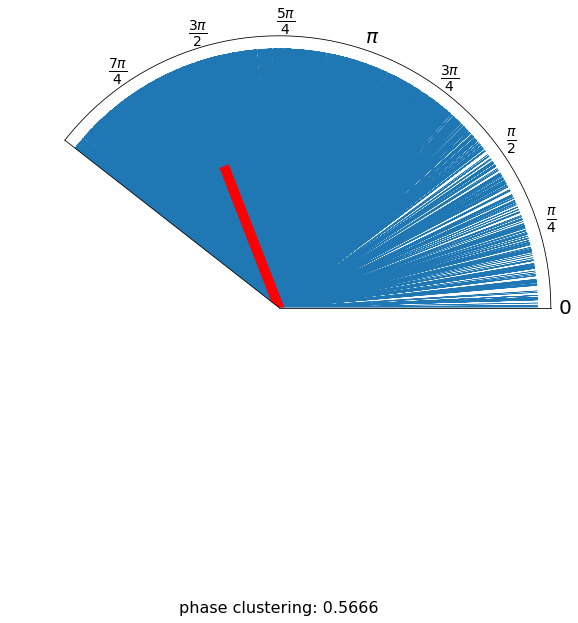

In [122]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

In [123]:
sliding_window_size = 3.0 # seconds
event_time = event_data.Time.to_numpy()
window_size = np.round(event_time[-1] - event_time[0], 0)
print(f"The event has a duration of {window_size} seconds")
number_of_windows = int(window_size//sliding_window_size)
print(f"The {number_of_windows} sliding windows has durations of {sliding_window_size} seconds")

The event has a duration of 30.0 seconds
The 10 sliding windows has durations of 3.0 seconds


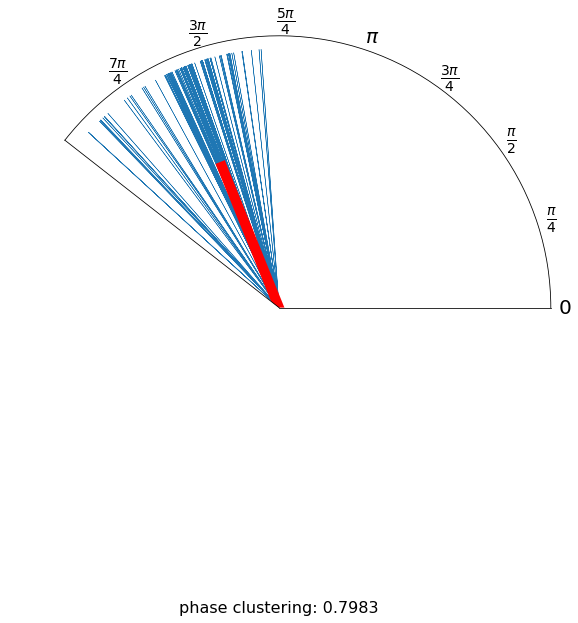

In [124]:
ic_data_complete = event_data.Inferior_colliculus_1

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Inferior Colliculus II

In [125]:
ic2 = event_data.Inferior_colliculus_2
analytic_signal_ic2 = hilbert(ic2)
phase_data_ic2 = np.unwrap(np.angle(analytic_signal_ic2))

In [126]:
phase_angle_diff = phase_data_CS - phase_data_ic2

In [127]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [128]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.8699


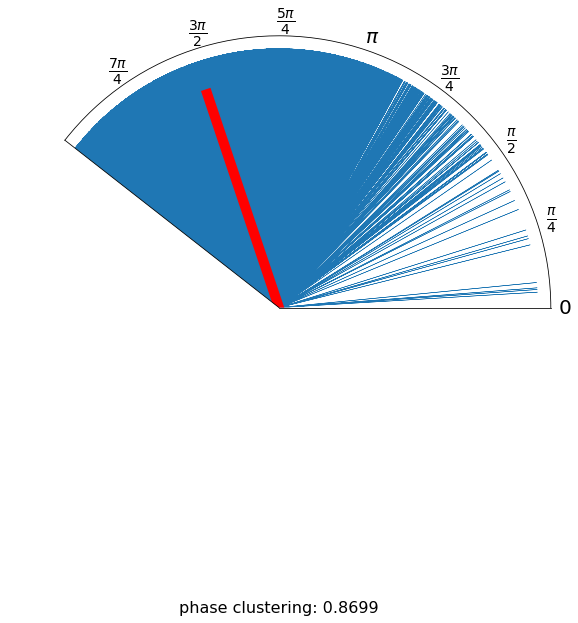

In [129]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

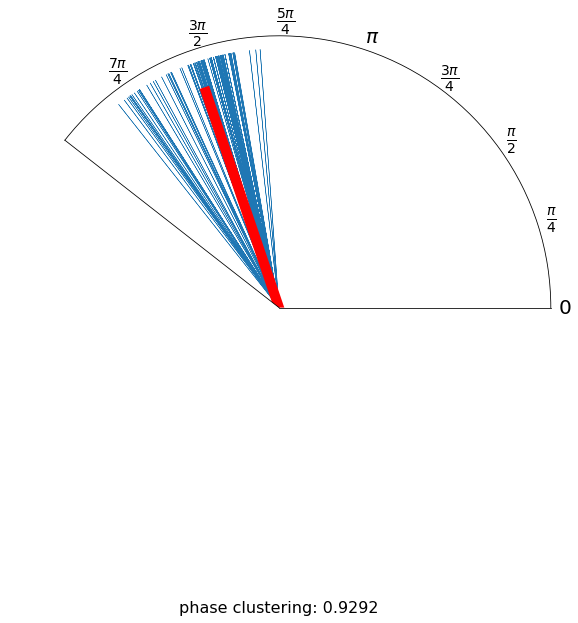

In [130]:
ic_data_complete = event_data.Inferior_colliculus_2

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Inferior Colliculus III

In [131]:
ic3 = event_data.Inferior_colliculus_3
analytic_signal_ic3 = hilbert(ic3)
phase_data_ic3 = np.unwrap(np.angle(analytic_signal_ic3))

In [132]:
phase_angle_diff = phase_data_CS - phase_data_ic3

In [133]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [134]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.8862


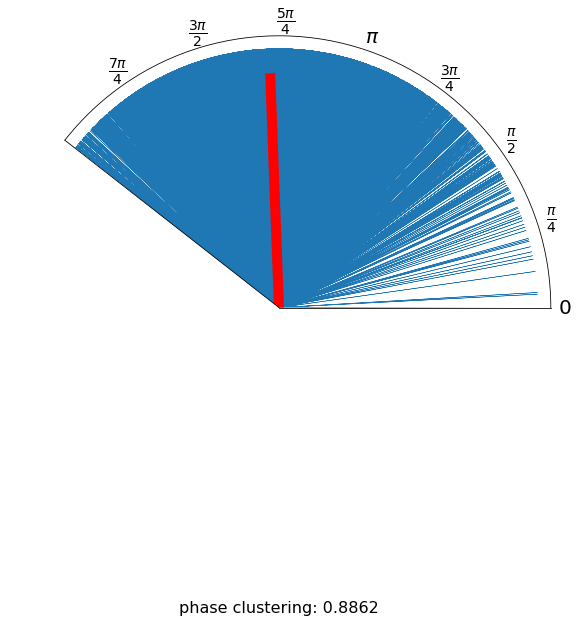

In [135]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

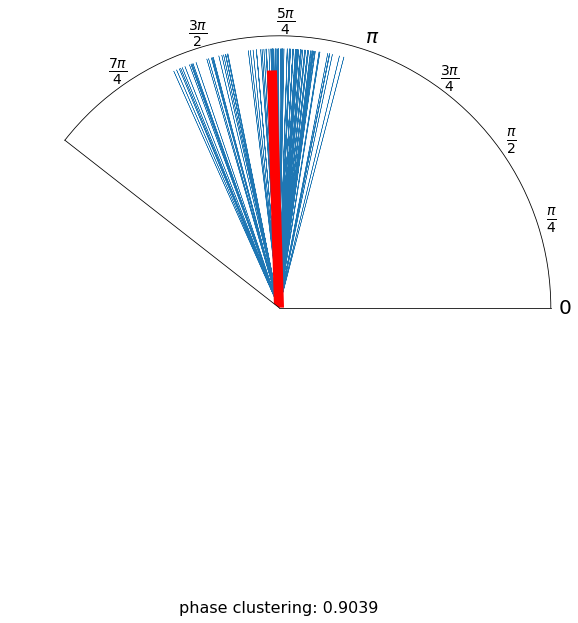

In [136]:
ic_data_complete = event_data.Inferior_colliculus_3

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Inferior Colliculus IV

In [137]:
ic4 = event_data.Inferior_colliculus_4
analytic_signal_ic4 = hilbert(ic4)
phase_data_ic4 = np.unwrap(np.angle(analytic_signal_ic4))

In [138]:
phase_angle_diff = phase_data_CS - phase_data_ic4

In [139]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [140]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.7782


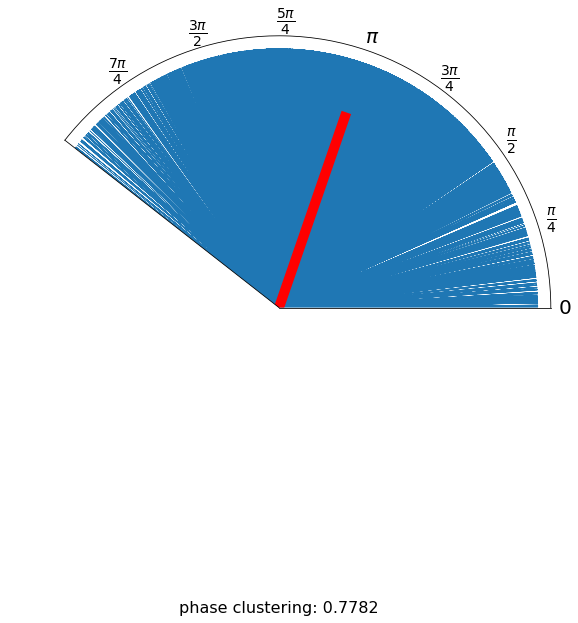

In [141]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

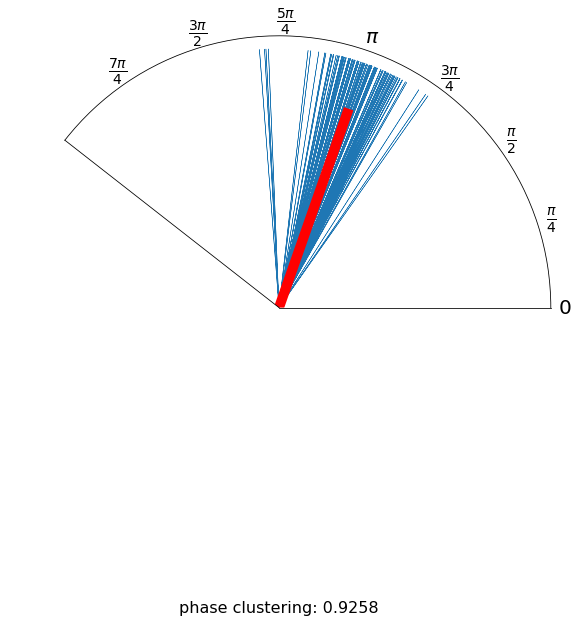

In [142]:
ic_data_complete = event_data.Inferior_colliculus_4

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# **Event 4**

## Selecting the data related to the event 4

In [143]:
samples_before = 0
samples_after = 0
event_number = 4
fs = 1e3

event_data = select_event_window(
    df=data,
    event_number=event_number,
    samples_before=samples_before,
    samples_after=samples_after
)

In [144]:
event_data

Time  CS_modulating  Amygdala_lateral_1  Amygdala_lateral_2  \
610240  610.240       0.173648          -13.024661          -12.852006   
610248  610.248      -0.500000           15.085270           14.123895   
610256  610.256       0.809017          -16.282790          -14.552082   
610264  610.264      -1.000000           16.137073           13.699493   
610272  610.272       0.939693          -14.286471          -11.249820   
...         ...            ...                 ...                 ...   
640176  640.176       0.939693           14.301195           10.801601   
640184  640.184      -1.000000          -16.953621          -13.440398   
640192  640.192       0.809017           17.075379           13.973483   
640200  640.200      -0.500000          -14.610085          -12.312826   
640208  640.208       0.173648            9.892485            8.707207   

        Amygdala_basolateral_1  Amygdala_basolateral_2  Inferior_colliculus_1  \
610240              -15.088716               -8.471792              -0.208327   
610248               15.931197                9.279509               3.430279   
610256              -15.813686               -9.851769              -6.694223   
610264               14.368152                9.751975               9.287150   
610272              -11.345320               -8.576941             -10.550844   
...                        ...                     ...                    ...   
640176                8.682055                8.203476               5.622173   
640184              -10.652963              -10.302590              -2.389133   
640192               10.748996               10.630479              -1.170900   
640200               -8.962778               -9.143784               4.613669   
640208                5.594551                6.089048              -7.510695   

        Inferior_colliculus_2  Inferior_colliculus_3  Inferior_colliculus_4  \
610240              -5.920724              -8.393288              18.427344   
610248              13.957618              17.823414              -6.704876   
610256             -21.008665             -25.998726              -6.133224   
610264              25.679186              31.239768              18.211875   
610272             -26.852353             -32.207463             -27.749859   
...                       ...                    ...                    ...   
640176              15.003283              15.263024              11.084645   
640184              -8.727984             -10.651648              -7.252613   
640192               1.332639               4.351503               2.176537   
640200               6.106543               2.660409               3.124859   
640208             -12.539068              -9.311135              -7.605574   

       events_index events_behavior_TS_LFP  
610240            4                      7  
610248            4                      7  
610256            4                      7  
610264            4                      7  
610272            4                      7  
...             ...                    ...  
640176            4                      8  
640184            4                      8  
640192            4                      8  
640200            4                      8  
640208            4                      8  

[3747 rows x 12 columns]

In [145]:
time = event_data.Time

In [146]:
CS = event_data.CS_modulating
analytic_signal_CS = hilbert(CS)
phase_data_CS = np.unwrap(np.angle(analytic_signal_CS))

# Inferior Colliculus I

In [147]:
ic1 = event_data.Inferior_colliculus_1
analytic_signal_ic1 = hilbert(ic1)
phase_data_ic1 = np.unwrap(np.angle(analytic_signal_ic1))

In [148]:
phase_angle_diff = phase_data_CS - phase_data_ic1

In [149]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [150]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.4629


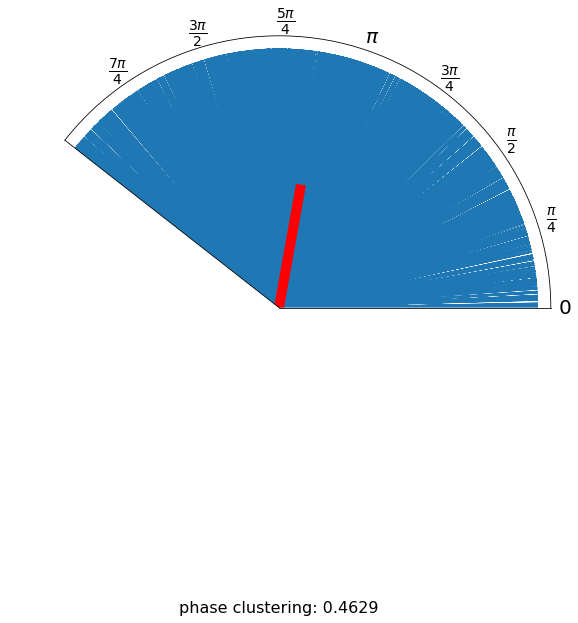

In [151]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

In [152]:
sliding_window_size = 3.0 # seconds
event_time = event_data.Time.to_numpy()
window_size = np.round(event_time[-1] - event_time[0], 0)
print(f"The event has a duration of {window_size} seconds")
number_of_windows = int(window_size//sliding_window_size)
print(f"The {number_of_windows} sliding windows has durations of {sliding_window_size} seconds")

The event has a duration of 30.0 seconds
The 10 sliding windows has durations of 3.0 seconds


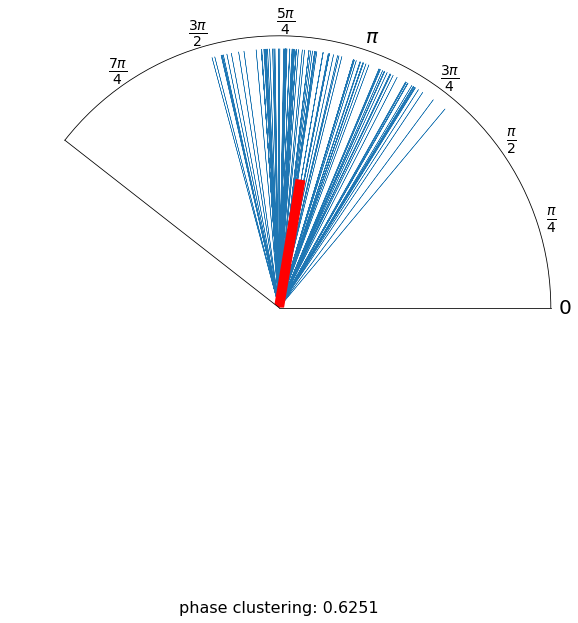

In [153]:
ic_data_complete = event_data.Inferior_colliculus_1

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Inferior Colliculus II

In [154]:
ic2 = event_data.Inferior_colliculus_2
analytic_signal_ic2 = hilbert(ic2)
phase_data_ic2 = np.unwrap(np.angle(analytic_signal_ic2))

In [155]:
phase_angle_diff = phase_data_CS - phase_data_ic2

In [156]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [157]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.786


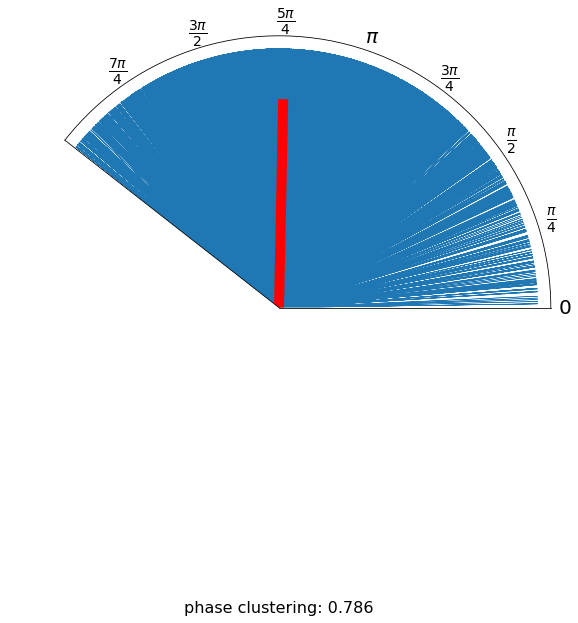

In [158]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

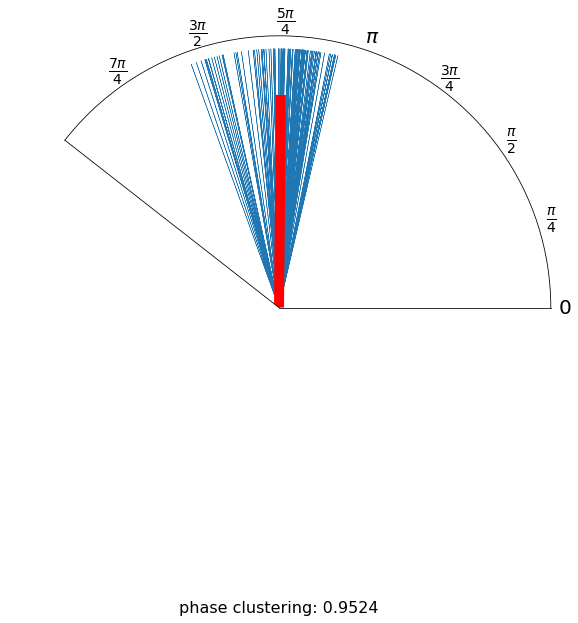

In [159]:
ic_data_complete = event_data.Inferior_colliculus_2

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Inferior Colliculus III

In [160]:
ic3 = event_data.Inferior_colliculus_3
analytic_signal_ic3 = hilbert(ic3)
phase_data_ic3 = np.unwrap(np.angle(analytic_signal_ic3))

In [161]:
phase_angle_diff = phase_data_CS - phase_data_ic3

In [162]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [163]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.7487


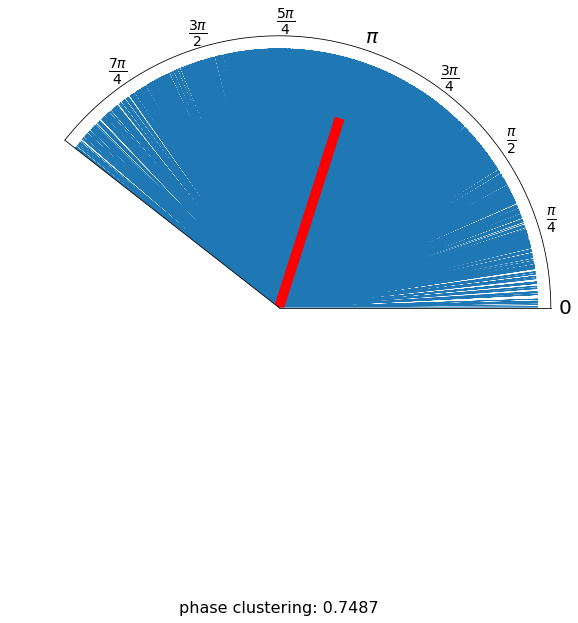

In [164]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

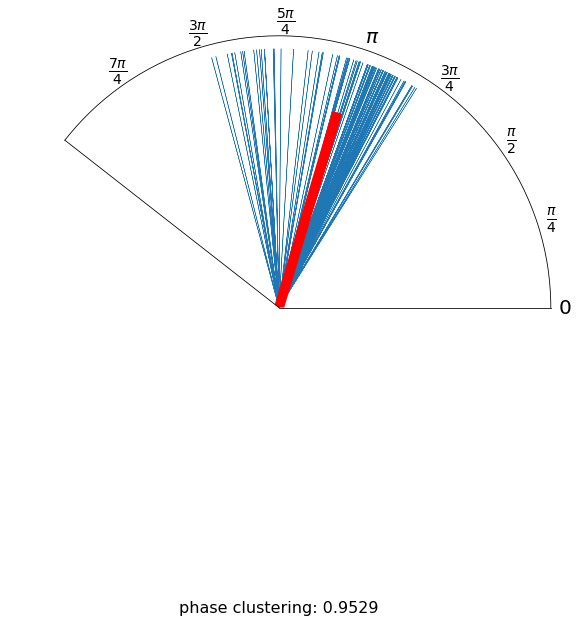

In [165]:
ic_data_complete = event_data.Inferior_colliculus_3

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Inferior Colliculus IV

In [166]:
ic4 = event_data.Inferior_colliculus_4
analytic_signal_ic4 = hilbert(ic4)
phase_data_ic4 = np.unwrap(np.angle(analytic_signal_ic4))

In [167]:
phase_angle_diff = phase_data_CS - phase_data_ic4

In [168]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [169]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.7177


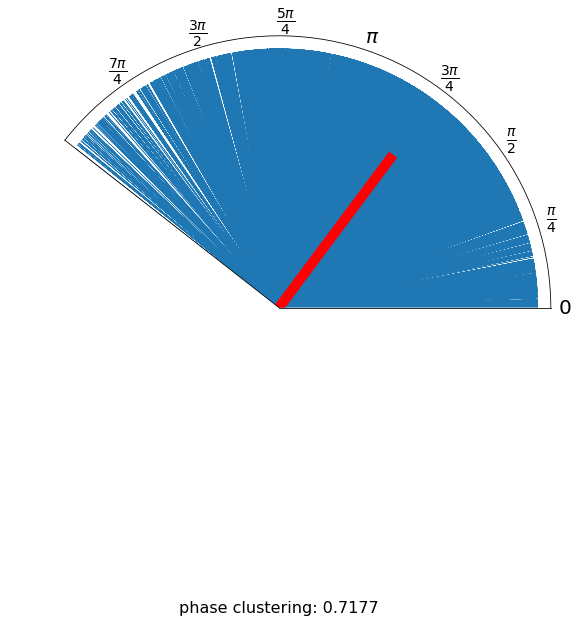

In [170]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

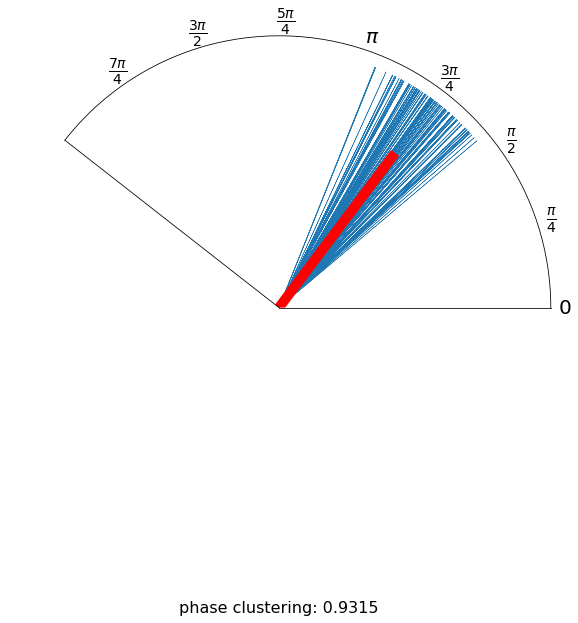

In [171]:
ic_data_complete = event_data.Inferior_colliculus_4

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# **Event 5**

## Selecting the data related to the event 5

In [172]:
samples_before = 0
samples_after = 0
event_number = 5
fs = 1e3

event_data = select_event_window(
    df=data,
    event_number=event_number,
    samples_before=samples_before,
    samples_after=samples_after
)

In [173]:
event_data

Time  CS_modulating  Amygdala_lateral_1  Amygdala_lateral_2  \
760240  760.240       0.500000           10.665259            7.922911   
760248  760.248      -0.809017          -11.258911           -8.465192   
760256  760.256       1.000000           10.809818            8.251833   
760264  760.264      -0.939693           -9.590887           -7.518544   
760272  760.272       0.766044            7.948096            6.547630   
...         ...            ...                 ...                 ...   
790176  790.176       1.000000            5.483226            1.896763   
790184  790.184      -0.809017           -5.922023           -2.491737   
790192  790.192       0.500000            5.397006            2.504349   
790200  790.200      -0.173648           -4.062463           -2.033950   
790208  790.208      -0.309017            2.182180            1.245870   

        Amygdala_basolateral_1  Amygdala_basolateral_2  Inferior_colliculus_1  \
760240               11.850670               11.540955              33.097675   
760248              -12.941807              -12.094085             -28.289385   
760256               12.787215               11.446704              20.148359   
760264              -11.576661               -9.871646              -9.998040   
760272                9.614831                7.745146              -0.576591   
...                        ...                     ...                    ...   
790176                0.485737                0.827029               0.661356   
790184               -0.439711               -1.412421               0.689201   
790192                0.105425                1.643984              -1.864833   
790200                0.363743               -1.594532               2.732780   
790208               -0.798183                1.368186              -3.222157   

        Inferior_colliculus_2  Inferior_colliculus_3  Inferior_colliculus_4  \
760240              19.969063              11.376879              26.149781   
760248             -16.794528              -6.397163             -21.628095   
760256              11.744044               0.958398              14.412422   
760264              -5.845233               3.857917              -5.513503   
760272               0.204518              -7.100026              -3.801905   
...                       ...                    ...                    ...   
790176              -1.273204               4.167843              10.351633   
790184               4.285472              -0.497711              -7.398977   
790192              -6.485224              -2.934921               4.496194   
790200               7.582421               5.586618              -1.894919   
790208              -7.497131              -7.099217              -0.348973   

       events_index events_behavior_TS_LFP  
760240            5                      8  
760248            5                      8  
760256            5                      8  
760264            5                      8  
760272            5                      8  
...             ...                    ...  
790176            5                      9  
790184            5                      9  
790192            5                      9  
790200            5                      9  
790208            5                      9  

[3747 rows x 12 columns]

In [174]:
time = event_data.Time

In [175]:
CS = event_data.CS_modulating
analytic_signal_CS = hilbert(CS)
phase_data_CS = np.unwrap(np.angle(analytic_signal_CS))

# Inferior Colliculus I

In [176]:
ic1 = event_data.Inferior_colliculus_1
analytic_signal_ic1 = hilbert(ic1)
phase_data_ic1 = np.unwrap(np.angle(analytic_signal_ic1))

In [177]:
phase_angle_diff = phase_data_CS - phase_data_ic1

In [178]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [179]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.4167


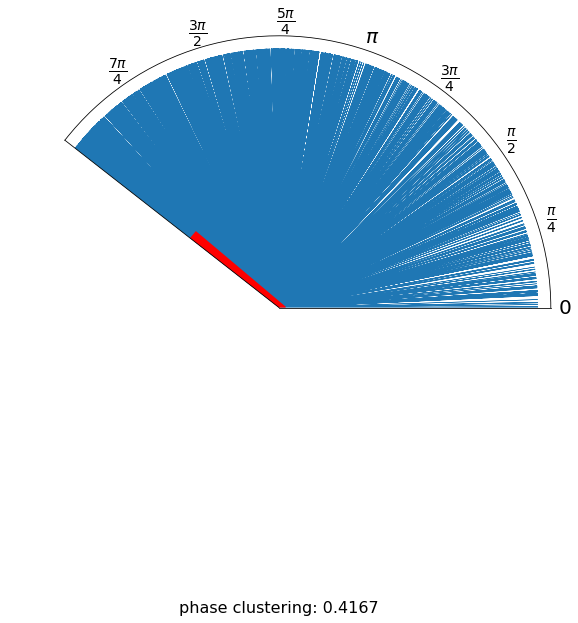

In [180]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

In [181]:
sliding_window_size = 3.0 # seconds
event_time = event_data.Time.to_numpy()
window_size = np.round(event_time[-1] - event_time[0], 0)
print(f"The event has a duration of {window_size} seconds")
number_of_windows = int(window_size//sliding_window_size)
print(f"The {number_of_windows} sliding windows has durations of {sliding_window_size} seconds")

The event has a duration of 30.0 seconds
The 10 sliding windows has durations of 3.0 seconds


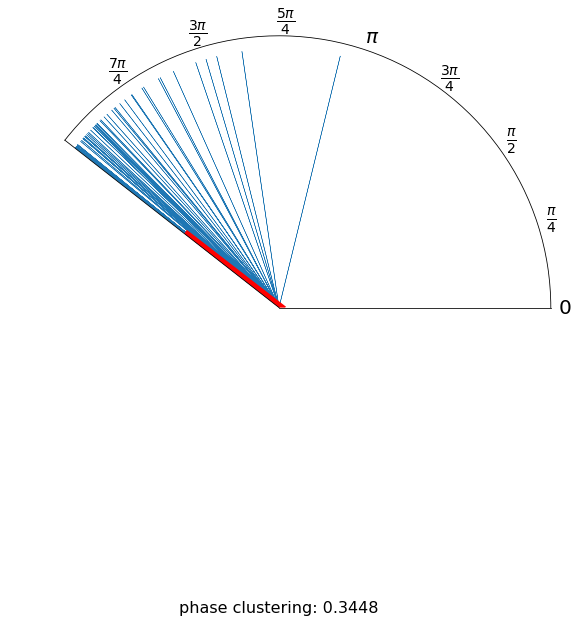

In [182]:
ic_data_complete = event_data.Inferior_colliculus_1

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Inferior Colliculus II

In [183]:
ic2 = event_data.Inferior_colliculus_2
analytic_signal_ic2 = hilbert(ic2)
phase_data_ic2 = np.unwrap(np.angle(analytic_signal_ic2))

In [184]:
phase_angle_diff = phase_data_CS - phase_data_ic2

In [185]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [186]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.7057


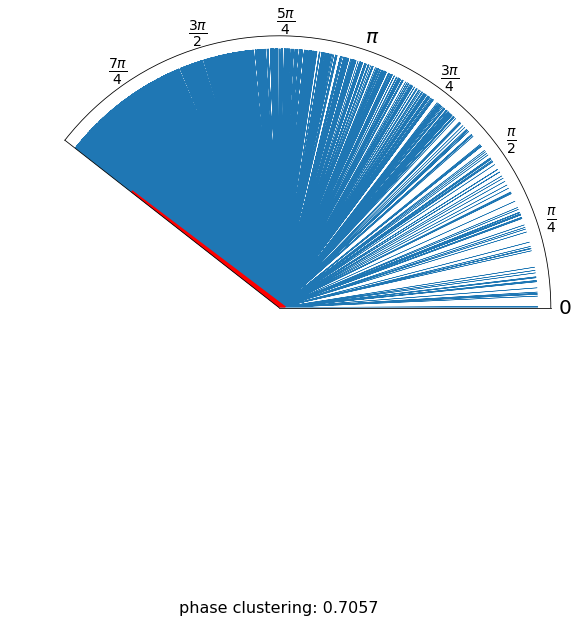

In [187]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

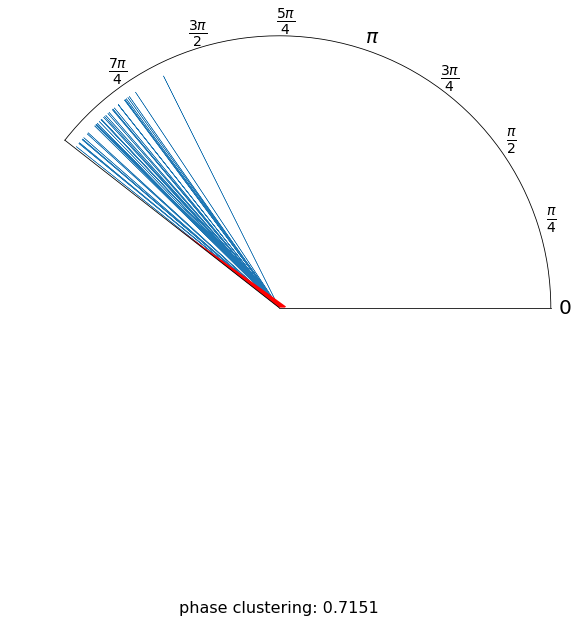

In [188]:
ic_data_complete = event_data.Inferior_colliculus_2

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Inferior Colliculus III

In [189]:
ic3 = event_data.Inferior_colliculus_3
analytic_signal_ic3 = hilbert(ic3)
phase_data_ic3 = np.unwrap(np.angle(analytic_signal_ic3))

In [190]:
phase_angle_diff = phase_data_CS - phase_data_ic3

In [191]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [192]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.6782


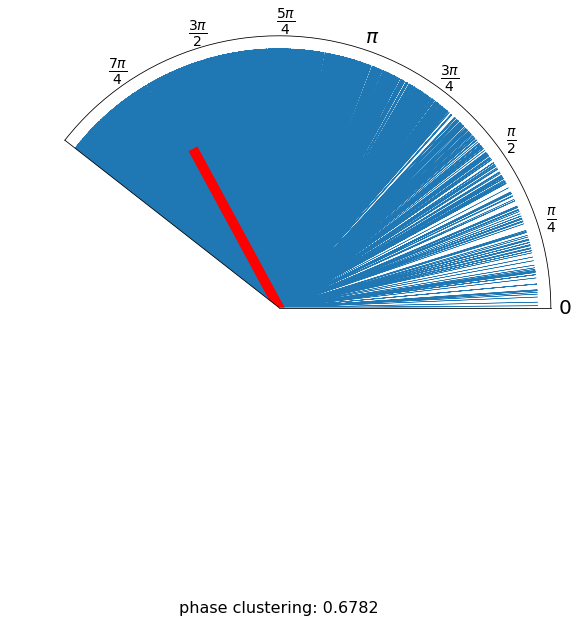

In [193]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

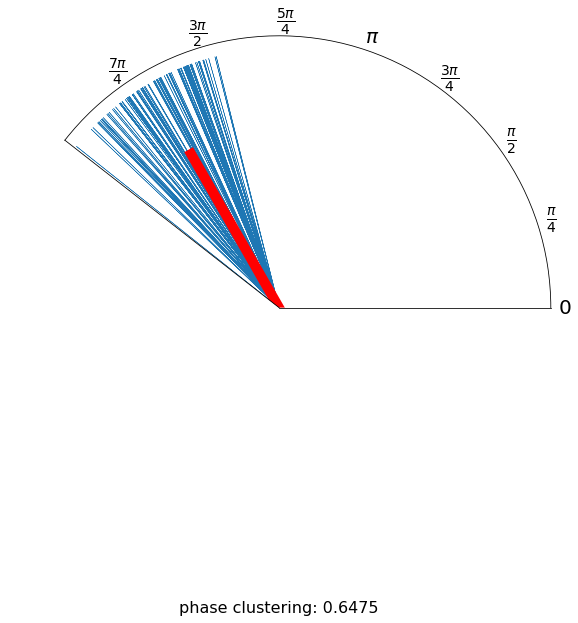

In [194]:
ic_data_complete = event_data.Inferior_colliculus_3

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Inferior Colliculus IV

In [195]:
ic4 = event_data.Inferior_colliculus_4
analytic_signal_ic4 = hilbert(ic4)
phase_data_ic4 = np.unwrap(np.angle(analytic_signal_ic4))

In [196]:
phase_angle_diff = phase_data_CS - phase_data_ic4

In [197]:
euler_phase_diff = np.exp(1j*phase_angle_diff)

In [198]:
mean_phase_diff = np.mean(euler_phase_diff)
phase_sync = np.abs(mean_phase_diff)
print(f"The synchronization between CS and Inferior Colliculus 1 is {np.round(phase_sync, 4)}")

The synchronization between CS and Inferior Colliculus 1 is 0.6959


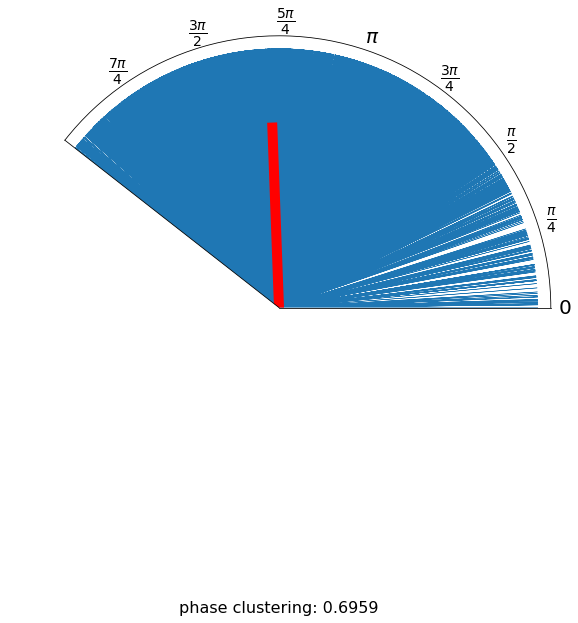

In [199]:
ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
plt.show()

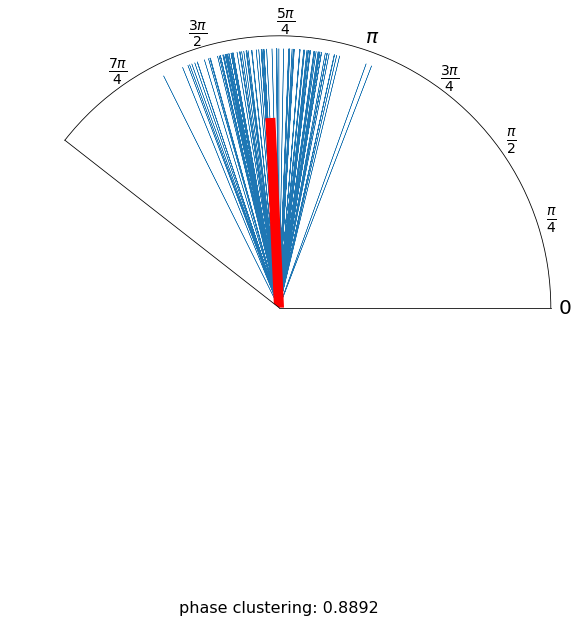

In [200]:
ic_data_complete = event_data.Inferior_colliculus_4

sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# Amygdala

# **Event 1**

## Selecting the data related to the event 1

In [201]:
samples_before = 0
samples_after = 0
event_number = 1
fs = 1e3

event_data = select_event_window(
    df=data,
    event_number=event_number,
    samples_before=samples_before,
    samples_after=samples_after
)

In [202]:
event_data

Time  CS_modulating  Amygdala_lateral_1  Amygdala_lateral_2  \
310240  310.240      -0.766044           14.775451           14.576169   
310248  310.248       0.309017          -12.840002          -12.206013   
310256  310.256       0.173648            9.800977            8.877668   
310264  310.264      -0.500000           -6.080660           -5.053063   
310272  310.272       0.809017            2.130790            1.187406   
...         ...            ...                 ...                 ...   
340176  340.176       0.173648           -5.966997           -7.074189   
340184  340.184      -0.587785            3.802850            5.251467   
340192  340.192       0.939693           -1.121782           -2.919069   
340200  340.200      -1.000000           -1.570660            0.498548   
340208  340.208       0.939693            3.760132            1.584319   

        Amygdala_basolateral_1  Amygdala_basolateral_2  Inferior_colliculus_1  \
310240               13.650979               13.374914              14.851928   
310248              -11.710375              -11.304154             -11.817004   
310256                8.787161                8.377473               7.718673   
310264               -5.304444               -4.996811              -2.991314   
310272                1.692492                1.551314              -1.874234   
...                        ...                     ...                    ...   
340176              -10.600101               -8.486896              14.847482   
340184                7.653419                5.901649             -13.242075   
340192               -3.818569               -2.762233               9.206882   
340200               -0.280765               -0.425298              -3.278339   
340208                3.985757                3.161783              -3.668677   

        Inferior_colliculus_2  Inferior_colliculus_3  Inferior_colliculus_4  \
310240              12.973613              12.430515              26.372591   
310248              -6.689360              -1.986873             -19.600532   
310256              -0.284754              -8.581819              10.297623   
310264               7.043754              17.788036               0.181099   
310272             -12.713439             -24.345955             -10.353401   
...                       ...                    ...                    ...   
340176              26.326536              27.542430              15.849365   
340184             -24.138574             -26.586861             -14.438182   
340192              17.872364              21.096374               8.737373   
340200              -8.514864             -11.939160               0.409922   
340208              -2.444580               0.592929             -11.406721   

       events_index events_behavior_TS_LFP  
310240            1                   None  
310248            1                   None  
310256            1                   None  
310264            1                   None  
310272            1                   None  
...             ...                    ...  
340176            1                      3  
340184            1                      3  
340192            1                      3  
340200            1                      3  
340208            1                      3  

[3747 rows x 12 columns]

In [203]:
time = event_data.Time

In [204]:
CS = event_data.CS_modulating
analytic_signal_CS = hilbert(CS)
phase_data_CS = np.unwrap(np.angle(analytic_signal_CS))

The event has a duration of 30.0 seconds
The sliding windows has durations of 3.0 seconds
----------------------------------------------------------------------------------------------------

The synchronization between CS and events_index is 0.4173


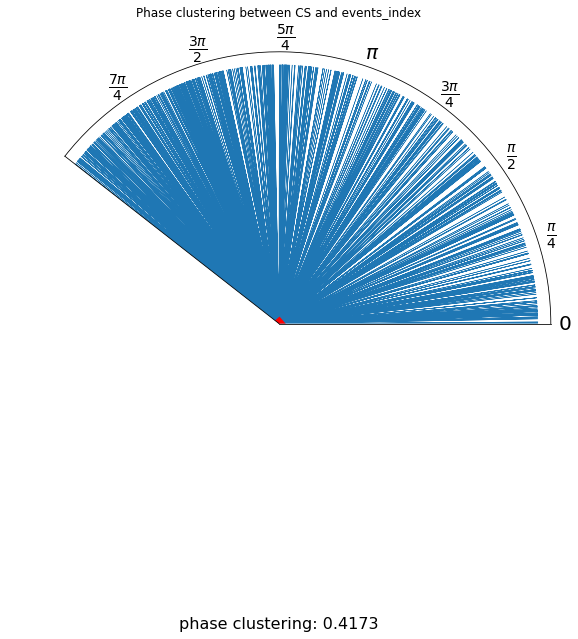

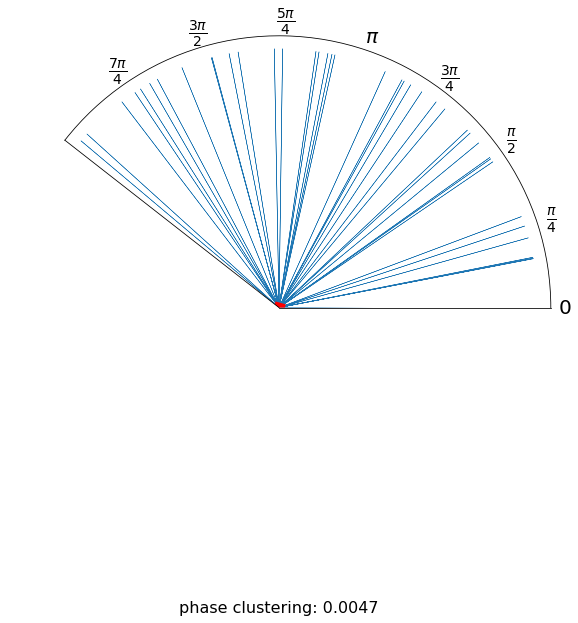

----------------------------------------------------------------------------------------------------
The synchronization between CS and events_behavior_TS_LFP is 0.4173


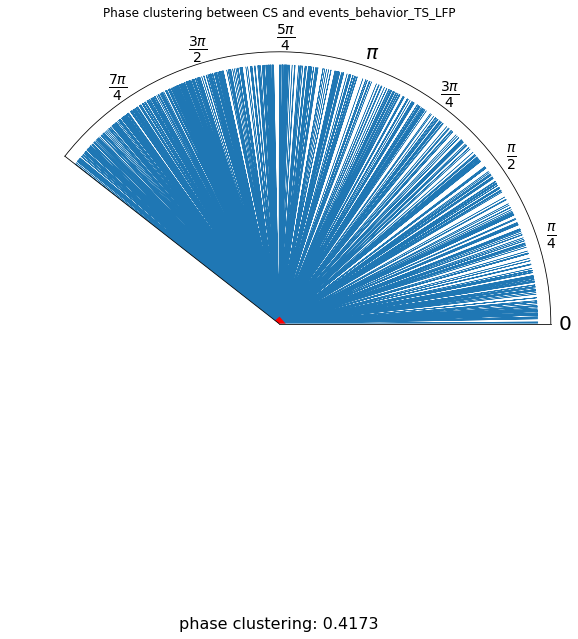

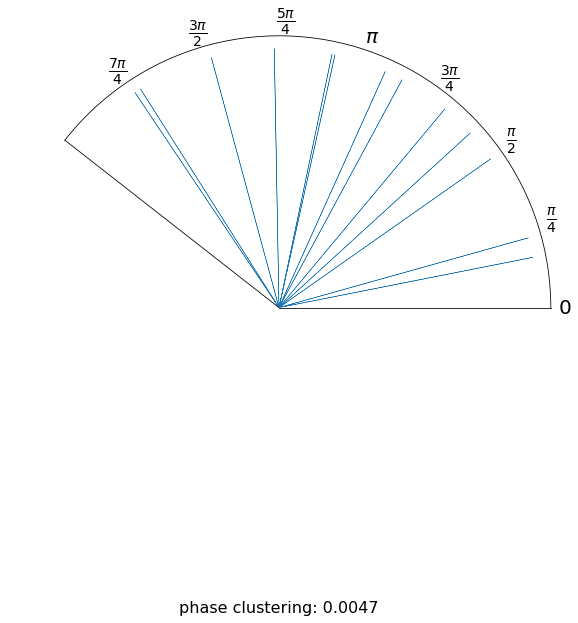

----------------------------------------------------------------------------------------------------


IndexError: single positional indexer is out-of-bounds

In [205]:
amygdala_range_in_dataframe = (10,14)

sliding_window_size = 3.0 # seconds
event_time = event_data.Time.to_numpy()
window_size = np.round(event_time[-1] - event_time[0], 0)
print(f"The event has a duration of {window_size} seconds")
number_of_windows = int(window_size//sliding_window_size)
print(f"The sliding windows has durations of {sliding_window_size} seconds")
print("-"*100+"\n")

for column_number in range(amygdala_range_in_dataframe[0], amygdala_range_in_dataframe[1]):
    
    amygdala_data = event_data.iloc[:,column_number]
    analytic_signal_amygdala = hilbert(amygdala_data)
    phase_data_amygdala = np.unwrap(np.angle(analytic_signal_amygdala))
    phase_angle_diff = phase_data_CS - phase_data_ic1
    euler_phase_diff = np.exp(1j*phase_angle_diff)
    mean_phase_diff = np.mean(euler_phase_diff)
    phase_sync = np.abs(mean_phase_diff)
    print(f"The synchronization between CS and {data.columns[column_number]} is {np.round(phase_sync, 4)}")
    
    ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
    ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
    ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
    ax.set_title(f"Phase clustering between CS and {data.columns[column_number]}")
    plt.show()

    sliding_window_mean_phase_clustering(
        amygdala_data,
        TimeSampling,
        sliding_window_size,
        window_size
    )
    
    print("-"*100)

In [ ]:
ic_data_complete = event_data.Amygdala_lateral_1


sliding_window_mean_phase_clustering(
    ic_data_complete,
    TimeSampling,
    sliding_window_size,
    window_size
)

# **Event 2**

## Selecting the data related to the event 2

In [ ]:
samples_before = 0
samples_after = 0
event_number = 2
fs = 1e3

event_data = select_event_window(
    df=data,
    event_number=event_number,
    samples_before=samples_before,
    samples_after=samples_after
)

In [ ]:
event_data

In [ ]:
time = event_data.Time

In [ ]:
CS = event_data.CS_modulating
analytic_signal_CS = hilbert(CS)
phase_data_CS = np.unwrap(np.angle(analytic_signal_CS))

In [ ]:
amygdala_range_in_dataframe = (10,14)

sliding_window_size = 3.0 # seconds
event_time = event_data.Time.to_numpy()
window_size = np.round(event_time[-1] - event_time[0], 0)
print(f"The event has a duration of {window_size} seconds")
number_of_windows = int(window_size//sliding_window_size)
print(f"The sliding windows has durations of {sliding_window_size} seconds")
print("-"*100+"\n")

for column_number in range(amygdala_range_in_dataframe[0], amygdala_range_in_dataframe[1]):
    
    amygdala_data = event_data.iloc[:,column_number]
    analytic_signal_amygdala = hilbert(amygdala_data)
    phase_data_amygdala = np.unwrap(np.angle(analytic_signal_amygdala))
    phase_angle_diff = phase_data_CS - phase_data_ic1
    euler_phase_diff = np.exp(1j*phase_angle_diff)
    mean_phase_diff = np.mean(euler_phase_diff)
    phase_sync = np.abs(mean_phase_diff)
    print(f"The synchronization between CS and {data.columns[column_number]} is {np.round(phase_sync, 4)}")
    
    ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
    ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
    ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
    ax.set_title(f"Phase clustering between CS and {data.columns[column_number]}")
    plt.show()

    sliding_window_mean_phase_clustering(
        amygdala_data,
        TimeSampling,
        sliding_window_size,
        window_size
    )
    
    print("-"*100)

# **Event 3**

## Selecting the data related to the event 1

In [ ]:
samples_before = 0
samples_after = 0
event_number = 3
fs = 1e3

event_data = select_event_window(
    df=data,
    event_number=event_number,
    samples_before=samples_before,
    samples_after=samples_after
)

In [ ]:
event_data

In [ ]:
time = event_data.Time

In [ ]:
CS = event_data.CS_modulating
analytic_signal_CS = hilbert(CS)
phase_data_CS = np.unwrap(np.angle(analytic_signal_CS))

In [ ]:
amygdala_range_in_dataframe = (10,14)

sliding_window_size = 3.0 # seconds
event_time = event_data.Time.to_numpy()
window_size = np.round(event_time[-1] - event_time[0], 0)
print(f"The event has a duration of {window_size} seconds")
number_of_windows = int(window_size//sliding_window_size)
print(f"The sliding windows has durations of {sliding_window_size} seconds")
print("-"*100+"\n")

for column_number in range(amygdala_range_in_dataframe[0], amygdala_range_in_dataframe[1]):
    
    amygdala_data = event_data.iloc[:,column_number]
    analytic_signal_amygdala = hilbert(amygdala_data)
    phase_data_amygdala = np.unwrap(np.angle(analytic_signal_amygdala))
    phase_angle_diff = phase_data_CS - phase_data_ic1
    euler_phase_diff = np.exp(1j*phase_angle_diff)
    mean_phase_diff = np.mean(euler_phase_diff)
    phase_sync = np.abs(mean_phase_diff)
    print(f"The synchronization between CS and {data.columns[column_number]} is {np.round(phase_sync, 4)}")
    
    ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
    ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
    ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
    ax.set_title(f"Phase clustering between CS and {data.columns[column_number]}")
    plt.show()

    sliding_window_mean_phase_clustering(
        amygdala_data,
        TimeSampling,
        sliding_window_size,
        window_size
    )
    
    print("-"*100)

# **Event 4**

## Selecting the data related to the event 4

In [ ]:
samples_before = 0
samples_after = 0
event_number = 4
fs = 1e3

event_data = select_event_window(
    df=data,
    event_number=event_number,
    samples_before=samples_before,
    samples_after=samples_after
)

In [ ]:
event_data

In [ ]:
time = event_data.Time

In [ ]:
CS = event_data.CS_modulating
analytic_signal_CS = hilbert(CS)
phase_data_CS = np.unwrap(np.angle(analytic_signal_CS))

In [ ]:
amygdala_range_in_dataframe = (10,14)

sliding_window_size = 3.0 # seconds
event_time = event_data.Time.to_numpy()
window_size = np.round(event_time[-1] - event_time[0], 0)
print(f"The event has a duration of {window_size} seconds")
number_of_windows = int(window_size//sliding_window_size)
print(f"The sliding windows has durations of {sliding_window_size} seconds")
print("-"*100+"\n")

for column_number in range(amygdala_range_in_dataframe[0], amygdala_range_in_dataframe[1]):
    
    amygdala_data = event_data.iloc[:,column_number]
    analytic_signal_amygdala = hilbert(amygdala_data)
    phase_data_amygdala = np.unwrap(np.angle(analytic_signal_amygdala))
    phase_angle_diff = phase_data_CS - phase_data_ic1
    euler_phase_diff = np.exp(1j*phase_angle_diff)
    mean_phase_diff = np.mean(euler_phase_diff)
    phase_sync = np.abs(mean_phase_diff)
    print(f"The synchronization between CS and {data.columns[column_number]} is {np.round(phase_sync, 4)}")
    
    ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
    ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
    ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
    ax.set_title(f"Phase clustering between CS and {data.columns[column_number]}")
    plt.show()

    sliding_window_mean_phase_clustering(
        amygdala_data,
        TimeSampling,
        sliding_window_size,
        window_size
    )
    
    print("-"*100)

# **Event 5**

## Selecting the data related to the event 5

In [ ]:
samples_before = 0
samples_after = 0
event_number = 5
fs = 1e3

event_data = select_event_window(
    df=data,
    event_number=event_number,
    samples_before=samples_before,
    samples_after=samples_after
)

In [ ]:
event_data

In [ ]:
time = event_data.Time

In [ ]:
CS = event_data.CS_modulating
analytic_signal_CS = hilbert(CS)
phase_data_CS = np.unwrap(np.angle(analytic_signal_CS))

In [ ]:
amygdala_range_in_dataframe = (10,14)

sliding_window_size = 3.0 # seconds
event_time = event_data.Time.to_numpy()
window_size = np.round(event_time[-1] - event_time[0], 0)
print(f"The event has a duration of {window_size} seconds")
number_of_windows = int(window_size//sliding_window_size)
print(f"The sliding windows has durations of {sliding_window_size} seconds")
print("-"*100+"\n")

for column_number in range(amygdala_range_in_dataframe[0], amygdala_range_in_dataframe[1]):
    
    amygdala_data = event_data.iloc[:,column_number]
    analytic_signal_amygdala = hilbert(amygdala_data)
    phase_data_amygdala = np.unwrap(np.angle(analytic_signal_amygdala))
    phase_angle_diff = phase_data_CS - phase_data_ic1
    euler_phase_diff = np.exp(1j*phase_angle_diff)
    mean_phase_diff = np.mean(euler_phase_diff)
    phase_sync = np.abs(mean_phase_diff)
    print(f"The synchronization between CS and {data.columns[column_number]} is {np.round(phase_sync, 4)}")
    
    ax = PolarPlotPhasors.plot_array_angles(phase_angle_diff, color=None, linewidth=0.5)
    ax = PolarPlotPhasors.add_vector_polar(ax, angle=np.angle(mean_phase_diff), module=phase_sync, linewidth=10, color='red')
    ax.set_xlabel(f"\nphase clustering: {np.round(phase_sync, 4)}", fontsize=16)
    ax.set_title(f"Phase clustering between CS and {data.columns[column_number]}")
    plt.show()

    sliding_window_mean_phase_clustering(
        amygdala_data,
        TimeSampling,
        sliding_window_size,
        window_size
    )
    
    print("-"*100)

In [ ]:
end_time = perf_counter()
elapsed_time_in_seconds = end_time - begin_time
print(f"Elapsed time: {strftime('%H:%M:%S', gmtime(elapsed_time_in_seconds))}")